### **Installation**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 98.1 MB/s eta 0:00:00
  

In [4]:
import tensorflow as tf
print(tf.__version__)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, RepeatVector
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### **LSTM**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Load and preprocess the data
def load_and_preprocess_data(file_path):
    """
    Load the CSV file and preprocess the data for LSTM training
    """
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Convert DATE column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Sort by USER_ID and DATE
    df = df.sort_values(['USER_ID', 'DATE']).reset_index(drop=True)

    # Extract hourly columns (12am through 11pm)
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    return df, hourly_columns

def create_sequences_full_data(data, sequence_length):
    """
    Create sequences from ALL data for training
    """
    sequences = []
    targets = []
    user_info = []  # Keep track of which user each sequence belongs to

    # Group by user to create sequences
    for user_id in data['USER_ID'].unique()[:1000]:
        print(user_id)
        user_data = data[data['USER_ID'] == user_id].sort_values('DATE')


        # Extract hourly features
        hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                         '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                         '8pm', '9pm', '10pm', '11pm']

        features = user_data[hourly_columns].values
        dates = user_data['DATE'].values

        # Create sequences for this user
        for i in range(len(features) - sequence_length):
            sequence = features[i:i+sequence_length]
            next_day_activity = features[i+sequence_length]

            # Target: predict next day's hourly pattern
            # We'll create multiple targets - one for each hour
            sequences.append(sequence)
            targets.append(next_day_activity)  # Full 24-hour pattern
            user_info.append({
                'user_id': user_id,
                'start_date': dates[i],
                'end_date': dates[i+sequence_length-1],
                'target_date': dates[i+sequence_length]
            })

    return np.array(sequences), np.array(targets), user_info

def create_lstm_model_multi_output(input_shape, output_dim=24):
    """
    Create LSTM model for predicting full 24-hour patterns
    """
    model = Sequential([
        LSTM(256, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(output_dim, activation='sigmoid')  # 24 outputs for 24 hours
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model



# Main training function
def train_full_model():
    """
    Train the model on ALL available data
    """
    # Configuration
    FILE_PATH = '/content/drive/MyDrive/3M-timestamp.csv'
    SEQUENCE_LENGTH = 7  # Use 7 days to predict next day

    print("Loading and preprocessing data...")
    df, hourly_columns = load_and_preprocess_data(FILE_PATH)

    print(f"Data shape: {df.shape}")
    print(f"Number of unique users: {df['USER_ID'].nunique()}")
    print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")

    # Create sequences from ALL data
    print("Creating sequences from ALL data...")
    X, y, user_info = create_sequences_full_data(df, SEQUENCE_LENGTH)

    print(f"Total sequences: {len(X)}")
    print(f"Sequence shape: {X.shape}")
    print(f"Target shape: {y.shape}")

    # Create and compile model
    print("Creating LSTM model")
    model = create_lstm_model_multi_output(
        input_shape=(SEQUENCE_LENGTH, len(hourly_columns)),
        output_dim=24
    )

    print("Model architecture:")
    model.summary()

    # Set up callbacks
    early_stopping = EarlyStopping(
        monitor='loss',
        patience=15,
        restore_best_weights=True
    )

    # Train the model on ALL data
    print("Training model on FULL dataset...")
    history = model.fit(
        X, y,
        batch_size=16,
        epochs=5,
        callbacks=[early_stopping],
        verbose=1
    )


    # Save the model
    model.save('notification_lstm_full_model.h5')
    print("Model saved as 'notification_lstm_full_model.h5'")

    # Save additional info
    np.save('model_info.npy', {
        'hourly_columns': hourly_columns,
        'sequence_length': SEQUENCE_LENGTH,
        'user_info_sample': user_info[:5]  # Save a sample for reference
    }, allow_pickle=True)
    return model, history, df, hourly_columns
    # print("=== EXAMPLE PREDICTION ===")
    # user_id = "00001d6eecdf78d72d9cc90d9a0a99c7"
    # df_result, predictions = notification_lstm_full_model(
    #     user_id=user_id,
    #     save_csv=True)


def quick_test_model(model, df, hourly_columns, sequence_length=7):
    """
    Quick test of the trained model
    """
    # Test on a sample user
    sample_user = df['USER_ID'].iloc[8]
    user_data = df[df['USER_ID'] == sample_user].copy()
    user_data = user_data.sort_values('DATE')

    if len(user_data) >= sequence_length + 1:
        features = user_data[hourly_columns].values
        test_sequence = features[:sequence_length].reshape(1, sequence_length, 24)
        actual_next_day = features[sequence_length]

        prediction = model.predict(test_sequence)[0]
        predicted_binary = (prediction > 0.5).astype(int)

        print(f"\nQuick test for user: {sample_user}")
        print(f"Actual next day:    {actual_next_day}")
        print(f"Predicted (prob):   {prediction}")
        print(f"Predicted (binary): {predicted_binary}")
        print(f"Accuracy: {np.mean(actual_next_day == predicted_binary):.2f}")

if __name__ == "__main__":
    # Train the model
    model, history, df, hourly_columns = train_full_model()

    # Quick test
    quick_test_model(model, df, hourly_columns)

Loading and preprocessing data...
Data shape: (6279000, 26)
Number of unique users: 232840
Date range: 2025-01-05 00:00:00 to 2025-04-28 00:00:00
Creating sequences from ALL data...
00001d6eecdf78d72d9cc90d9a0a99c7
000033ef96774b50806529379c6b69c3
00020d3a2f68244d04c004aade84fe4f
00020ff0c04a2a03c307faedc8a389ab
000253845e38533e9e156dd4973d85c5
0002609e9c9d4cd8a3b776edf7336d94
000267d3ece9dcf6551f22d8a7299016
0002eab010b3470b84df7a280d135af9
000303db4509d199169157cc02baa8a9
00031510761c00a9f6477671538283db
0003296bc65a205cd51f3554e18dd9a8
000373f37f604bd69193d151b495d66e
0004439d44f7d6ff1a3afd476d3a2464
00047b703bddb24809f8105adf1e55fc
000491e233d3dd6db4ea9edd6e58ca45
0005337f505e41a2aced763e12765fb6
0005ace1a289c3785d4908f4ac595b51
0005f33361b1a9d464a0be3002dc6e02
00067773bfd7cf20efff8ead3b6ad8ff
0006af147c1b496dabf781dd9cc063e4
0006b5e53f804f7fa54ef8a8b505ade3
0007e832ebbb4a72ba75d41f400b27a0
000874f3174049d88e8badbb210d63ca
00087f24bd314206aab2dd7a38b925c4
0009c7a905521cae11a50f9f5a

Raw Data ( LSTM NEural Network Random forest )

raw data + probability  (LSTM NEural Network Random forest)

Raw data + clusters  (LSTM NEural Network Random forest)

### **Neural Network(Raw)**

Loading and preprocessing data...
Data shape: (6279000, 30)
Number of unique users: 232840
Date range: 2025-01-05 00:00:00 to 2025-04-28 00:00:00
Unique weeks: 18

Selecting up to 1000 users including target user 2ff2cf3f81bf3e3f8c3c486b648e217a...
Total users in dataset: 232840
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a exists in dataset: True
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a added - has 15 complete weeks
Selected 1000 users with sufficient data
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a is included: True
First 10 selected users: ['2ff2cf3f81bf3e3f8c3c486b648e217a', '00001d6eecdf78d72d9cc90d9a0a99c7', '000033ef96774b50806529379c6b69c3', '00020d3a2f68244d04c004aade84fe4f', '00020ff0c04a2a03c307faedc8a389ab', '000303db4509d199169157cc02baa8a9', '00031510761c00a9f6477671538283db', '0003296bc65a205cd51f3554e18dd9a8', '000373f37f604bd69193d151b495d66e', '0005ace1a289c3785d4908f4ac595b51']
Creating weekly sequences...
Processing 1000 selected users...
Processing user 1/1000:

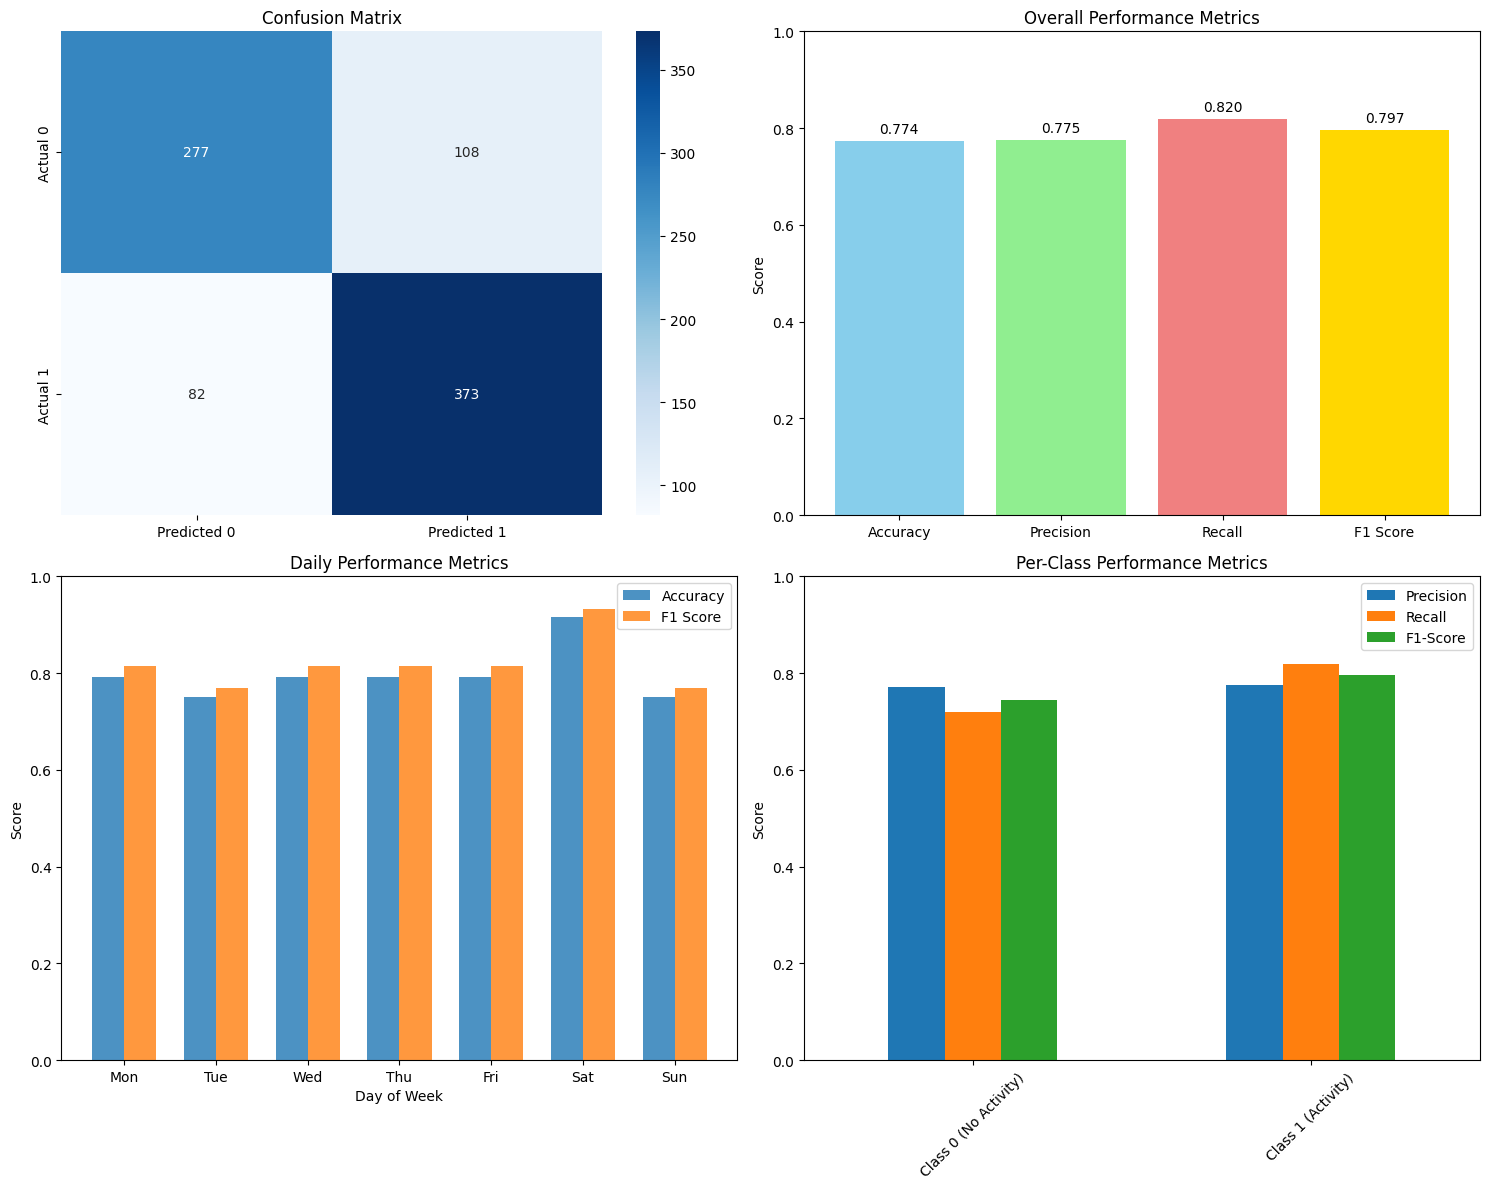


Generating weekly pattern visualization...


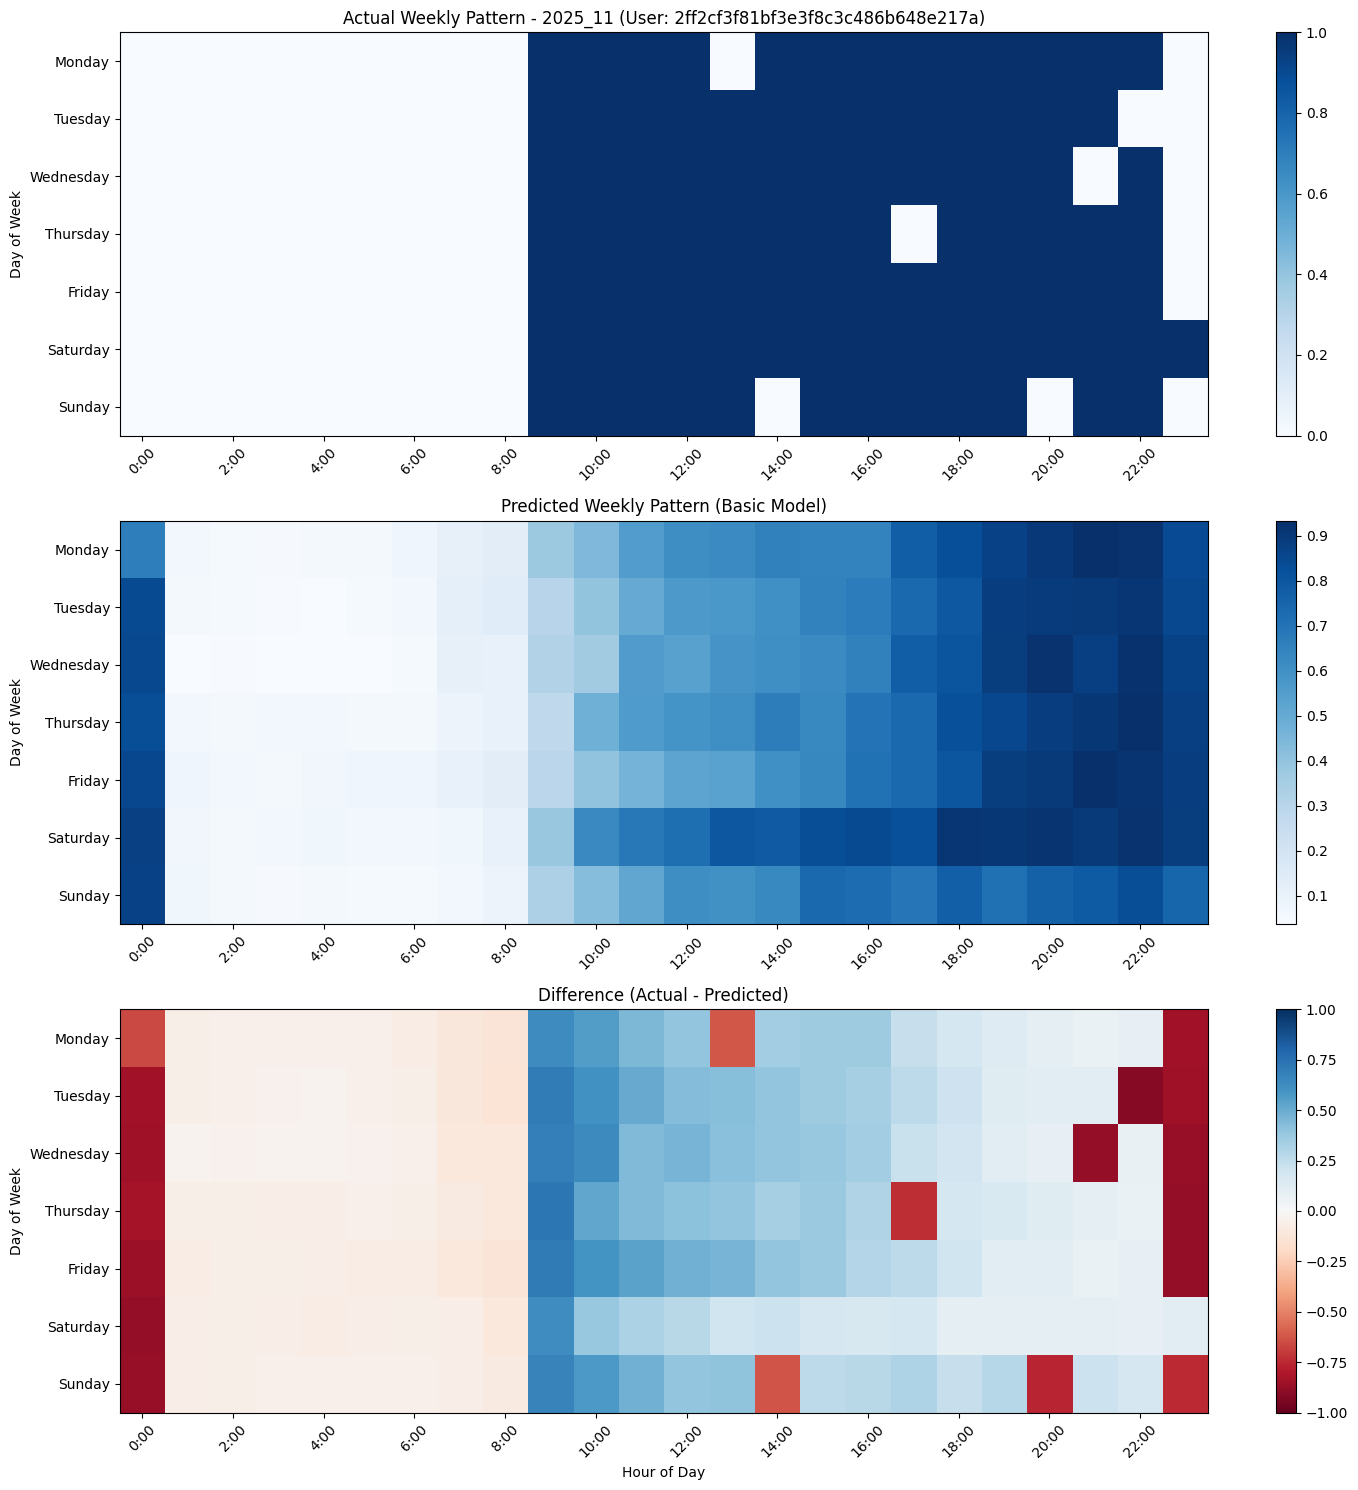


Metrics for this specific prediction:
Accuracy: 0.7976
Precision: 0.8041
Recall: 0.8387
F1 Score: 0.8211


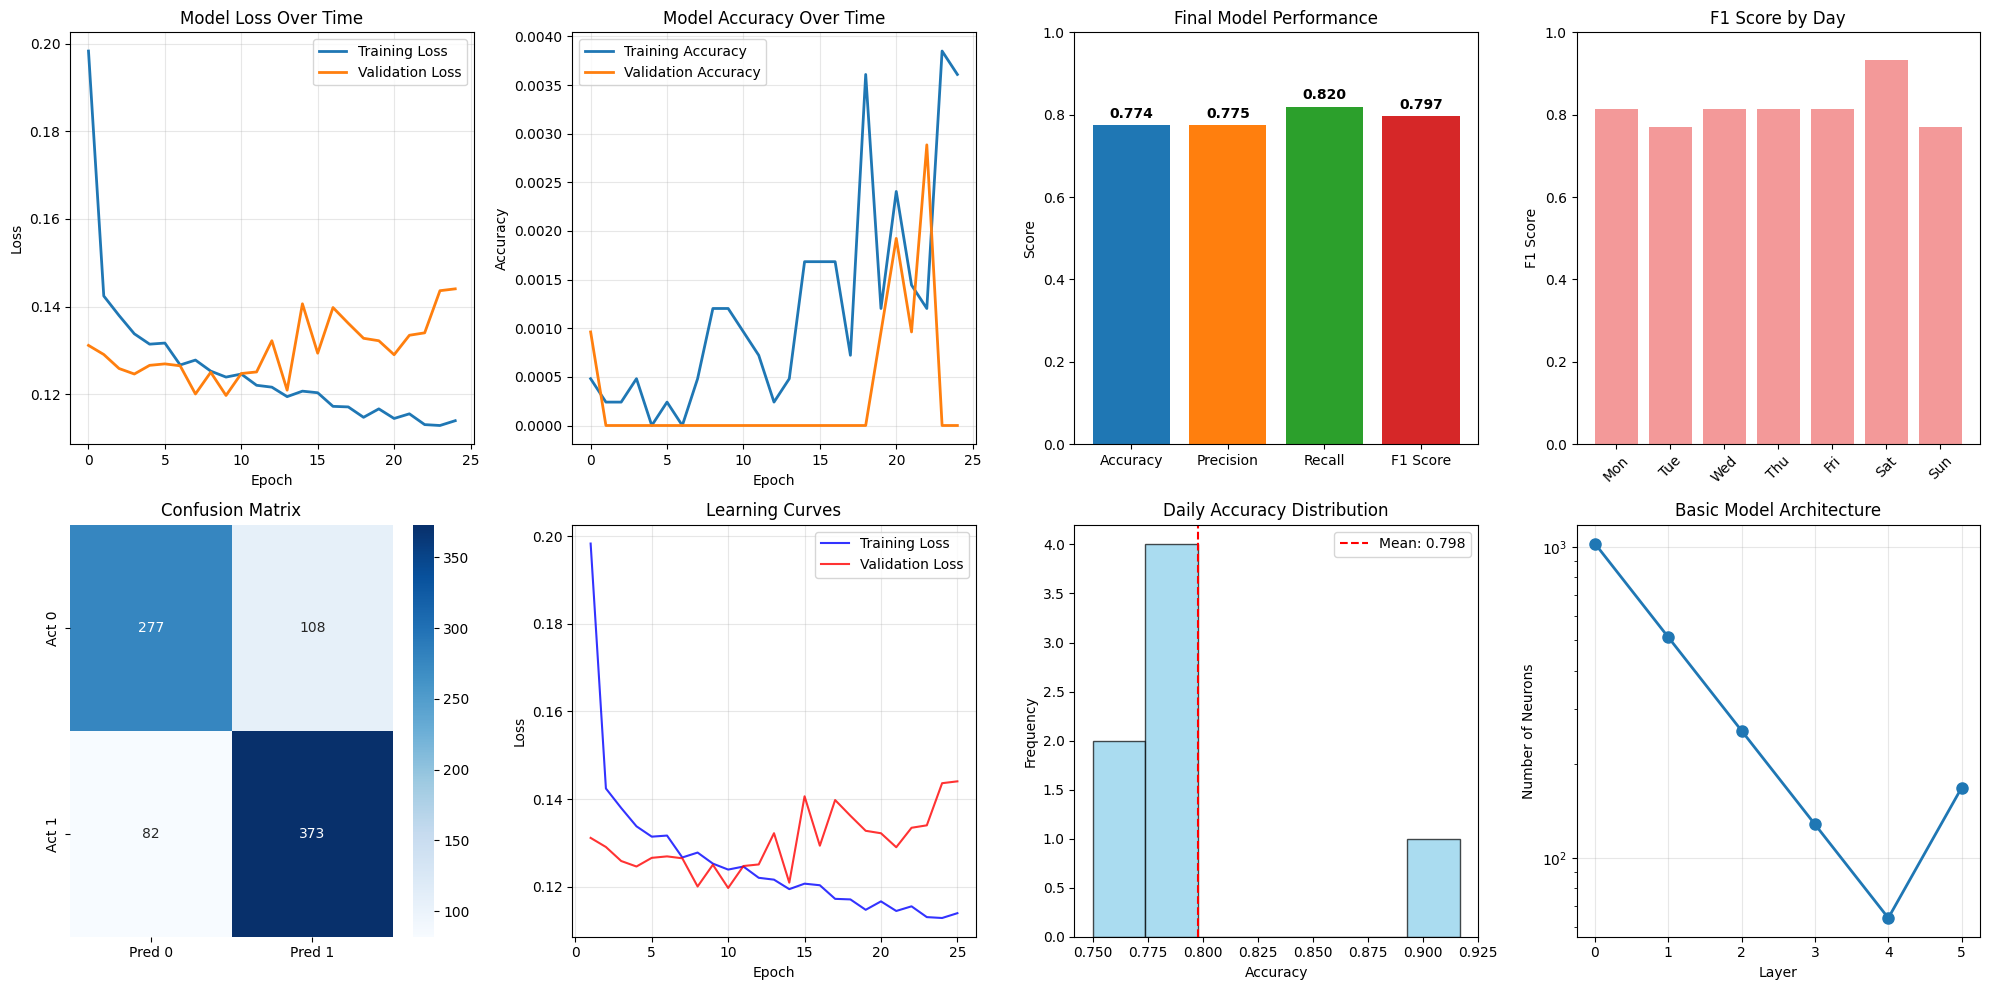


FINAL EVALUATION SUMMARY - BASIC MODEL
Model Type: Basic Neural Network (Timestamp features only)
Model Architecture: 6-layer Neural Network with Dropout and BatchNorm
Input Features: 168 (Timestamp features only)
Output: 168 binary predictions (7 days × 24 hours)
Training Method: Early stopping with validation monitoring
Target User ID: 2ff2cf3f81bf3e3f8c3c486b648e217a

PERFORMANCE METRICS:
  • Overall Accuracy: 0.7738
  • Precision: 0.7755
  • Recall: 0.8198
  • F1 Score: 0.7970

DAILY PERFORMANCE:
  • Average Daily Accuracy: 0.7976
  • Average Daily F1 Score: 0.8187
  • Best Performing Day: Saturday (F1: 0.9333)
  • Worst Performing Day: Tuesday (F1: 0.7692)

CONFUSION MATRIX:
  True Negatives:     277    False Positives:    108
  False Negatives:     82    True Positives:     373

MODEL CHARACTERISTICS:
  • Type: Basic Model (No probability features)
  • Input: Weekly timestamp patterns only
  • Complexity: Medium (6 hidden layers)
  • Regularization: Dropout + Batch Normalization

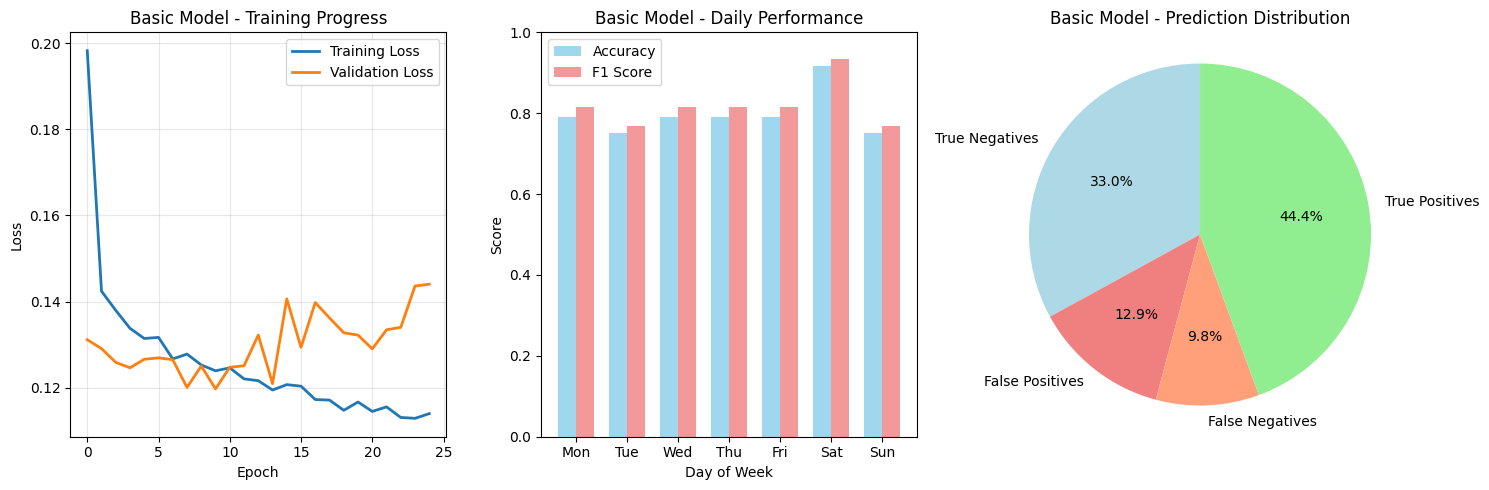

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_data(file_path):
    """
    Load the CSV file and preprocess the data for Neural Network training
    """
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Convert DATE column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Add day of week information
    df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
    df['WEEK_NUMBER'] = df['DATE'].dt.isocalendar().week
    df['YEAR'] = df['DATE'].dt.year
    df['WEEK_YEAR'] = df['YEAR'].astype(str) + '_' + df['WEEK_NUMBER'].astype(str)

    # Sort by USER_ID and DATE
    df = df.sort_values(['USER_ID', 'DATE']).reset_index(drop=True)

    # Extract hourly columns (12am through 11pm)
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    return df, hourly_columns

def select_consistent_users(data, target_user_id='2ff2cf3f81bf3e3f8c3c486b648e217a', max_users=1000):
    """
    Select consistent users including the target user
    """
    print(f"Total users in dataset: {data['USER_ID'].nunique()}")

    # Check if target user exists
    target_user_exists = target_user_id in data['USER_ID'].values
    print(f"Target user {target_user_id} exists in dataset: {target_user_exists}")

    # Select users with sufficient data
    valid_users = []

    # First, validate and add target user if it exists
    if target_user_exists:
        user_data = data[data['USER_ID'] == target_user_id]

        if len(user_data) > 0:
            # Check for weekly completeness
            user_weeks = user_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks
                valid_users.append(target_user_id)
                print(f"Target user {target_user_id} added - has {complete_weeks} complete weeks")
            else:
                print(f"Target user {target_user_id} has insufficient data - only {complete_weeks} complete weeks")
        else:
            print(f"Target user {target_user_id} has no data")

    # Now add other users (excluding target user to avoid duplicates)
    all_users = list(data['USER_ID'].unique())
    other_users = [user for user in all_users if user != target_user_id]

    for user_id in other_users:
        if len(valid_users) >= max_users:
            break

        user_data = data[data['USER_ID'] == user_id]

        if len(user_data) > 0:
            # Check for weekly completeness
            user_weeks = user_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks for training
                valid_users.append(user_id)

    print(f"Selected {len(valid_users)} users with sufficient data")
    print(f"Target user {target_user_id} is included: {target_user_id in valid_users}")
    print(f"First 10 selected users: {valid_users[:10]}")

    return valid_users

def create_weekly_sequences(data, selected_users, sequence_weeks=1):
    """
    Create weekly sequences from data for Neural Network training
    Input: sequence_weeks weeks to predict next week's pattern
    """
    sequences = []
    targets = []
    user_info = []

    # Days of week in order
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Hourly columns
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    print(f"Processing {len(selected_users)} selected users...")

    # Group by user to create sequences
    for idx, user_id in enumerate(selected_users):
        if idx % 100 == 0:
            print(f"Processing user {idx+1}/{len(selected_users)}: {user_id}")

        user_data = data[data['USER_ID'] == user_id].sort_values('DATE')

        # Group by week for this user
        weekly_data = {}
        for week_year in user_data['WEEK_YEAR'].unique():
            week_data = user_data[user_data['WEEK_YEAR'] == week_year]

            # Check if we have all 7 days for this week
            if len(week_data) == 7:
                # Sort by day of week to ensure Monday-Sunday order
                week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()

                # Check if we have data for all days (no NaN after reindexing)
                if not week_data[hourly_columns].isnull().any().any():
                    weekly_data[week_year] = week_data[hourly_columns].values  # Shape: (7, 24)

        # Create sequences from complete weeks
        week_keys = sorted(weekly_data.keys())

        for i in range(len(week_keys) - sequence_weeks):
            # Get input weeks (flatten them)
            input_weeks = []
            for j in range(sequence_weeks):
                week_data = weekly_data[week_keys[i + j]]  # Shape: (7, 24)
                input_weeks.append(week_data.flatten())  # Flatten to (168,)

            # Concatenate all input weeks
            sequence = np.concatenate(input_weeks)  # Shape: (sequence_weeks * 168,)

            # Get target week
            target_week = weekly_data[week_keys[i + sequence_weeks]]  # Shape: (7, 24)
            target = target_week.flatten()  # Flatten to (168,)

            sequences.append(sequence)
            targets.append(target)
            user_info.append({
                'user_id': user_id,
                'input_weeks': [week_keys[i + j] for j in range(sequence_weeks)],
                'target_week': week_keys[i + sequence_weeks]
            })

    return np.array(sequences), np.array(targets), user_info

def create_nn_model_weekly(input_dim, output_dim=168):  # 7 days * 24 hours = 168
    """
    Create Neural Network model for predicting full weekly patterns (Monday-Sunday, 12am-11pm)
    """
    model = Sequential([
        Dense(1024, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        Dropout(0.2),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # 168 outputs for 7 days * 24 hours
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def calculate_comprehensive_metrics(y_true, y_pred, y_pred_binary=None):
    """
    Calculate comprehensive evaluation metrics including F1, recall, precision, confusion matrix
    """
    if y_pred_binary is None:
        y_pred_binary = (y_pred > 0.5).astype(int)

    # Flatten arrays if they're multi-dimensional
    if len(y_true.shape) > 1:
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
        y_pred_binary_flat = y_pred_binary.flatten()
    else:
        y_true_flat = y_true
        y_pred_flat = y_pred
        y_pred_binary_flat = y_pred_binary

    # Calculate metrics
    accuracy = accuracy_score(y_true_flat, y_pred_binary_flat)
    precision = precision_score(y_true_flat, y_pred_binary_flat, average='binary', zero_division=0)
    recall = recall_score(y_true_flat, y_pred_binary_flat, average='binary', zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_binary_flat, average='binary', zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_binary_flat)

    # Classification report
    class_report = classification_report(y_true_flat, y_pred_binary_flat, output_dict=True, zero_division=0)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'classification_report': class_report
    }

    return metrics

def evaluate_model_comprehensive(model, X_test, y_test, scaler=None, verbose=True):
    """
    Comprehensive model evaluation with all metrics
    """
    if scaler is not None:
        X_test_scaled = scaler.transform(X_test)
    else:
        X_test_scaled = X_test

    # Get predictions
    y_pred_proba = model.predict(X_test_scaled, verbose=0)
    y_pred_binary = (y_pred_proba > 0.5).astype(int)

    # Calculate comprehensive metrics
    metrics = calculate_comprehensive_metrics(y_test, y_pred_proba, y_pred_binary)

    if verbose:
        print("=" * 60)
        print("COMPREHENSIVE MODEL EVALUATION RESULTS")
        print("=" * 60)
        print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1_score']:.4f}")
        print()

        print("Confusion Matrix:")
        print(metrics['confusion_matrix'])
        print()

        print("Classification Report:")
        for class_name, class_metrics in metrics['classification_report'].items():
            if isinstance(class_metrics, dict):
                print(f"{class_name}: Precision={class_metrics['precision']:.4f}, "
                      f"Recall={class_metrics['recall']:.4f}, F1={class_metrics['f1-score']:.4f}")

    return metrics, y_pred_proba, y_pred_binary

def quick_test_weekly_model_with_metrics(model, df, hourly_columns, scaler, sequence_weeks=1):
    """
    Enhanced quick test with comprehensive metrics for the target user
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    print(f"\nTesting specifically with target user: {TARGET_USER_ID}")

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in data")
        return None, None

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')
    print(f"User has {len(user_data)} records")

    weekly_data = {}
    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

    week_keys = sorted(weekly_data.keys())
    print(f"User has {len(week_keys)} complete weeks: {week_keys}")

    if len(week_keys) < 2:
        print("Insufficient complete weeks for testing")
        return None, None

    # Collect all available predictions for comprehensive evaluation
    all_predictions = []
    all_actuals = []
    all_predictions_binary = []

    # Test on multiple weeks if available
    test_weeks = min(len(week_keys) - 1, 5)  # Test up to 5 weeks

    for i in range(test_weeks):
        input_week = weekly_data[week_keys[i]].flatten().reshape(1, -1)
        actual_next_week = weekly_data[week_keys[i + 1]].flatten()

        # Scale input and predict
        input_week_scaled = scaler.transform(input_week)
        prediction = model.predict(input_week_scaled, verbose=0)[0]
        predicted_binary = (prediction > 0.5).astype(int)

        all_predictions.extend(prediction)
        all_actuals.extend(actual_next_week)
        all_predictions_binary.extend(predicted_binary)

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_actuals = np.array(all_actuals)
    all_predictions_binary = np.array(all_predictions_binary)

    # Calculate comprehensive metrics
    metrics = calculate_comprehensive_metrics(all_actuals, all_predictions, all_predictions_binary)

    print(f"\nCOMPREHENSIVE EVALUATION RESULTS for Target User {TARGET_USER_ID}:")
    print(f"Tested on {test_weeks} week predictions")
    print("=" * 50)
    print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print()

    print("Confusion Matrix:")
    print("                 Predicted")
    print("                 0      1")
    print(f"Actual    0   {metrics['confusion_matrix'][0][0]:6d} {metrics['confusion_matrix'][0][1]:6d}")
    print(f"          1   {metrics['confusion_matrix'][1][0]:6d} {metrics['confusion_matrix'][1][1]:6d}")
    print()

    # Day-by-day analysis for the first prediction
    print("Day-by-day accuracy for first prediction:")
    input_week = weekly_data[week_keys[0]].flatten().reshape(1, -1)
    actual_next_week = weekly_data[week_keys[1]].flatten()
    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled, verbose=0)[0]
    predicted_binary = (prediction > 0.5).astype(int)

    daily_metrics = []
    for day_idx, day in enumerate(days_order):
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        day_actual = actual_next_week[start_idx:end_idx]
        day_predicted = predicted_binary[start_idx:end_idx]

        day_accuracy = accuracy_score(day_actual, day_predicted)
        day_f1 = f1_score(day_actual, day_predicted, average='binary', zero_division=0)
        day_recall = recall_score(day_actual, day_predicted, average='binary', zero_division=0)
        day_precision = precision_score(day_actual, day_predicted, average='binary', zero_division=0)

        daily_metrics.append({
            'day': day,
            'accuracy': day_accuracy,
            'f1': day_f1,
            'recall': day_recall,
            'precision': day_precision
        })

        print(f"{day}: Acc={day_accuracy:.3f}, F1={day_f1:.3f}, Recall={day_recall:.3f}, Prec={day_precision:.3f}")

    # Detailed comparison for first 7 days
    print(f"\nDetailed comparison for first 7 days (Input: {week_keys[0]} -> Target: {week_keys[1]}):")
    for day_idx in range(7):
        day = days_order[day_idx]
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        day_actual = actual_next_week[start_idx:end_idx]
        day_predicted = predicted_binary[start_idx:end_idx]
        day_probs = prediction[start_idx:end_idx]

        print(f"{day}:")
        print(f"  Actual:    {day_actual}")
        print(f"  Predicted: {day_predicted}")
        print(f"  Prob scores (first 12h): {day_probs[:12].round(3)}")
        print()

    return metrics, daily_metrics

def visualize_comprehensive_results(metrics, daily_metrics=None):
    """
    Create comprehensive visualizations of the evaluation results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Confusion Matrix Heatmap
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'], ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')

    # 2. Metrics Bar Chart
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    metric_values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']]

    bars = axes[0,1].bar(metric_names, metric_values, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    axes[0,1].set_title('Overall Performance Metrics')
    axes[0,1].set_ylabel('Score')
    axes[0,1].set_ylim(0, 1)

    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{value:.3f}', ha='center', va='bottom')

    # 3. Daily Metrics (if available)
    if daily_metrics:
        days = [dm['day'][:3] for dm in daily_metrics]  # Abbreviated day names
        daily_acc = [dm['accuracy'] for dm in daily_metrics]
        daily_f1 = [dm['f1'] for dm in daily_metrics]

        x = np.arange(len(days))
        width = 0.35

        axes[1,0].bar(x - width/2, daily_acc, width, label='Accuracy', alpha=0.8)
        axes[1,0].bar(x + width/2, daily_f1, width, label='F1 Score', alpha=0.8)
        axes[1,0].set_xlabel('Day of Week')
        axes[1,0].set_ylabel('Score')
        axes[1,0].set_title('Daily Performance Metrics')
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(days)
        axes[1,0].legend()
        axes[1,0].set_ylim(0, 1)

    # 4. Classification Report Visualization
    if 'classification_report' in metrics:
        class_report = metrics['classification_report']
        metrics_df = pd.DataFrame({
            'Precision': [class_report['0']['precision'], class_report['1']['precision']],
            'Recall': [class_report['0']['recall'], class_report['1']['recall']],
            'F1-Score': [class_report['0']['f1-score'], class_report['1']['f1-score']]
        }, index=['Class 0 (No Activity)', 'Class 1 (Activity)'])

        metrics_df.plot(kind='bar', ax=axes[1,1], rot=45)
        axes[1,1].set_title('Per-Class Performance Metrics')
        axes[1,1].set_ylabel('Score')
        axes[1,1].legend()
        axes[1,1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

def visualize_weekly_prediction_enhanced(model, df, hourly_columns, scaler):
    """
    Create enhanced visualization of weekly prediction vs actual for target user
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in data")
        return

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')

    weekly_data = {}
    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

    if len(weekly_data) < 2:
        print("Insufficient data for visualization")
        return

    # Get prediction
    week_keys = sorted(weekly_data.keys())
    input_week = weekly_data[week_keys[0]].flatten().reshape(1, -1)
    actual_next_week = weekly_data[week_keys[1]]

    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled, verbose=0)[0]
    predicted_week = prediction.reshape(7, 24)

    # Create enhanced visualization
    fig, axes = plt.subplots(3, 1, figsize=(15, 15))

    # Actual pattern
    im1 = axes[0].imshow(actual_next_week, cmap='Blues', aspect='auto')
    axes[0].set_title(f'Actual Weekly Pattern - {week_keys[1]} (User: {TARGET_USER_ID})')
    axes[0].set_ylabel('Day of Week')
    axes[0].set_yticks(range(7))
    axes[0].set_yticklabels(days_order)
    axes[0].set_xticks(range(0, 24, 2))
    axes[0].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)
    plt.colorbar(im1, ax=axes[0])

    # Predicted pattern
    im2 = axes[1].imshow(predicted_week, cmap='Blues', aspect='auto')
    axes[1].set_title(f'Predicted Weekly Pattern (Basic Model)')
    axes[1].set_ylabel('Day of Week')
    axes[1].set_yticks(range(7))
    axes[1].set_yticklabels(days_order)
    axes[1].set_xticks(range(0, 24, 2))
    axes[1].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)
    plt.colorbar(im2, ax=axes[1])

    # Difference heatmap
    difference = actual_next_week - predicted_week
    im3 = axes[2].imshow(difference, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
    axes[2].set_title('Difference (Actual - Predicted)')
    axes[2].set_ylabel('Day of Week')
    axes[2].set_xlabel('Hour of Day')
    axes[2].set_yticks(range(7))
    axes[2].set_yticklabels(days_order)
    axes[2].set_xticks(range(0, 24, 2))
    axes[2].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)
    plt.colorbar(im3, ax=axes[2])

    plt.tight_layout()
    plt.show()

    # Calculate and display metrics for this specific prediction
    actual_flat = actual_next_week.flatten()
    predicted_flat = predicted_week.flatten()
    predicted_binary_flat = (predicted_flat > 0.5).astype(int)

    metrics = calculate_comprehensive_metrics(actual_flat, predicted_flat, predicted_binary_flat)

    print(f"\nMetrics for this specific prediction:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")

def train_weekly_model():
    """
    Train the model on weekly patterns with comprehensive evaluation
    """
    # Configuration
    FILE_PATH = '/content/drive/MyDrive/3M-timestamp.csv'
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    SEQUENCE_WEEKS = 1  # Use 1 week to predict next week
    MAX_USERS = 1000

    print("Loading and preprocessing data...")
    df, hourly_columns = load_and_preprocess_data(FILE_PATH)

    print(f"Data shape: {df.shape}")
    print(f"Number of unique users: {df['USER_ID'].nunique()}")
    print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")
    print(f"Unique weeks: {df['WEEK_YEAR'].nunique()}")

    # Select consistent users including target user
    print(f"\nSelecting up to {MAX_USERS} users including target user {TARGET_USER_ID}...")
    selected_users = select_consistent_users(df, TARGET_USER_ID, MAX_USERS)

    if len(selected_users) == 0:
        print("No users with sufficient data found!")
        return None, None, None, None, None

    # Create weekly sequences
    print("Creating weekly sequences...")
    X, y, user_info = create_weekly_sequences(df, selected_users, SEQUENCE_WEEKS)

    print(f"Total weekly sequences: {len(X)}")
    print(f"Input sequence shape: {X.shape}")  # Should be (n_samples, 168) for 1 week
    print(f"Target shape: {y.shape}")          # Should be (n_samples, 168) for 1 week

    if len(X) == 0:
        print("No complete weekly sequences found! Check your data.")
        return None, None, None, None, None

    # Split data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create and compile model
    print("Creating Neural Network model for weekly prediction")
    model = create_nn_model_weekly(
        input_dim=X_train_scaled.shape[1],  # 168 features for 1 week input
        output_dim=168  # 168 outputs for 1 week prediction
    )

    print("Model architecture:")
    model.summary()

    # Set up callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    # Train the model
    print("Training model on weekly patterns...")
    history = model.fit(
        X_train_scaled, y_train,
        batch_size=16,  # Smaller batch size for weekly data
        epochs=100,     # More epochs for weekly patterns
        callbacks=[early_stopping],
        verbose=1,
        validation_data=(X_test_scaled, y_test)
    )

    # Comprehensive evaluation on test set
    print("\n" + "="*60)
    print("COMPREHENSIVE MODEL EVALUATION ON TEST SET")
    print("="*60)

    test_metrics, y_pred_proba, y_pred_binary = evaluate_model_comprehensive(
        model, X_test, y_test, scaler, verbose=True
    )

    # Save the model and scaler
    model.save('notification_nn_weekly_basic_model.h5')
    print("\nBasic model saved as 'notification_nn_weekly_basic_model.h5'")

    # Save additional info including scaler and selected users
    np.save('weekly_basic_model_info.npy', {
        'hourly_columns': hourly_columns,
        'sequence_weeks': SEQUENCE_WEEKS,
        'user_info_sample': user_info[:5],
        'scaler_mean': scaler.mean_,
        'scaler_scale': scaler.scale_,
        'selected_users': selected_users,
        'target_user_id': TARGET_USER_ID,
        'test_metrics': test_metrics
    }, allow_pickle=True)

    return model, history, df, hourly_columns, scaler

def create_detailed_evaluation_report(model, df, hourly_columns, scaler):
    """
    Create a detailed evaluation report with multiple test cases
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'

    print("=" * 80)
    print("DETAILED EVALUATION REPORT - BASIC MODEL")
    print("=" * 80)

    # Test on target user with comprehensive metrics
    target_metrics, daily_metrics = quick_test_weekly_model_with_metrics(
        model, df, hourly_columns, scaler
    )

    if target_metrics is None:
        print("Could not generate evaluation report - insufficient target user data")
        return None, None

    # Create visualizations
    print("\nGenerating comprehensive visualizations...")
    visualize_comprehensive_results(target_metrics, daily_metrics)

    # Weekly pattern visualization
    print("\nGenerating weekly pattern visualization...")
    visualize_weekly_prediction_enhanced(model, df, hourly_columns, scaler)

    return target_metrics, daily_metrics

if __name__ == "__main__":
    # Train the weekly model with comprehensive evaluation
    model, history, df, hourly_columns, scaler = train_weekly_model()

    if model is not None:
        # Create detailed evaluation report
        target_metrics, daily_metrics = create_detailed_evaluation_report(
            model, df, hourly_columns, scaler
        )

        if target_metrics is not None:
            # Plot comprehensive training history and results
            plt.figure(figsize=(20, 10))

            # Training metrics
            plt.subplot(2, 4, 1)
            plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
            if 'val_loss' in history.history:
                plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
            plt.title('Model Loss Over Time')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)

            plt.subplot(2, 4, 2)
            plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
            if 'val_accuracy' in history.history:
                plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
            plt.title('Model Accuracy Over Time')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Final metrics summary
            plt.subplot(2, 4, 3)
            final_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
            final_values = [
                target_metrics['accuracy'],
                target_metrics['precision'],
                target_metrics['recall'],
                target_metrics['f1_score']
            ]
            bars = plt.bar(final_metrics, final_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
            plt.title('Final Model Performance')
            plt.ylabel('Score')
            plt.ylim(0, 1)
            for bar, value in zip(bars, final_values):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

            # Daily performance
            if daily_metrics:
                plt.subplot(2, 4, 4)
                days = [dm['day'][:3] for dm in daily_metrics]
                daily_f1 = [dm['f1'] for dm in daily_metrics]
                plt.bar(days, daily_f1, color='lightcoral', alpha=0.8)
                plt.title('F1 Score by Day')
                plt.ylabel('F1 Score')
                plt.ylim(0, 1)
                plt.xticks(rotation=45)

            # Confusion matrix visualization
            plt.subplot(2, 4, 5)
            cm = target_metrics['confusion_matrix']
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Pred 0', 'Pred 1'],
                       yticklabels=['Act 0', 'Act 1'])
            plt.title('Confusion Matrix')

            # Learning curves comparison
            plt.subplot(2, 4, 6)
            epochs = range(1, len(history.history['loss']) + 1)
            plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss', alpha=0.8)
            if 'val_loss' in history.history:
                plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', alpha=0.8)
            plt.title('Learning Curves')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Performance distribution
            plt.subplot(2, 4, 7)
            if daily_metrics:
                daily_accuracies = [dm['accuracy'] for dm in daily_metrics]
                plt.hist(daily_accuracies, bins=7, alpha=0.7, color='skyblue', edgecolor='black')
                plt.title('Daily Accuracy Distribution')
                plt.xlabel('Accuracy')
                plt.ylabel('Frequency')
                plt.axvline(np.mean(daily_accuracies), color='red', linestyle='--',
                           label=f'Mean: {np.mean(daily_accuracies):.3f}')
                plt.legend()

            # Model complexity visualization
            plt.subplot(2, 4, 8)
            layer_sizes = [1024, 512, 256, 128, 64, 168]  # Your model architecture
            plt.plot(range(len(layer_sizes)), layer_sizes, 'o-', linewidth=2, markersize=8)
            plt.title('Basic Model Architecture')
            plt.xlabel('Layer')
            plt.ylabel('Number of Neurons')
            plt.yscale('log')
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # Print comprehensive summary
            print("\n" + "=" * 80)
            print("FINAL EVALUATION SUMMARY - BASIC MODEL")
            print("=" * 80)
            print(f"Model Type: Basic Neural Network (Timestamp features only)")
            print(f"Model Architecture: 6-layer Neural Network with Dropout and BatchNorm")
            print(f"Input Features: {scaler.mean_.shape[0]} (Timestamp features only)")
            print(f"Output: 168 binary predictions (7 days × 24 hours)")
            print(f"Training Method: Early stopping with validation monitoring")
            print(f"Target User ID: 2ff2cf3f81bf3e3f8c3c486b648e217a")
            print()
            print("PERFORMANCE METRICS:")
            print(f"  • Overall Accuracy: {target_metrics['accuracy']:.4f}")
            print(f"  • Precision: {target_metrics['precision']:.4f}")
            print(f"  • Recall: {target_metrics['recall']:.4f}")
            print(f"  • F1 Score: {target_metrics['f1_score']:.4f}")
            print()
            if daily_metrics:
                avg_daily_acc = np.mean([dm['accuracy'] for dm in daily_metrics])
                avg_daily_f1 = np.mean([dm['f1'] for dm in daily_metrics])
                print("DAILY PERFORMANCE:")
                print(f"  • Average Daily Accuracy: {avg_daily_acc:.4f}")
                print(f"  • Average Daily F1 Score: {avg_daily_f1:.4f}")
                print(f"  • Best Performing Day: {max(daily_metrics, key=lambda x: x['f1'])['day']} (F1: {max(daily_metrics, key=lambda x: x['f1'])['f1']:.4f})")
                print(f"  • Worst Performing Day: {min(daily_metrics, key=lambda x: x['f1'])['day']} (F1: {min(daily_metrics, key=lambda x: x['f1'])['f1']:.4f})")
            print()
            print("CONFUSION MATRIX:")
            cm = target_metrics['confusion_matrix']
            print(f"  True Negatives:  {cm[0][0]:6d}    False Positives: {cm[0][1]:6d}")
            print(f"  False Negatives: {cm[1][0]:6d}    True Positives:  {cm[1][1]:6d}")
            print()
            print("MODEL CHARACTERISTICS:")
            print(f"  • Type: Basic Model (No probability features)")
            print(f"  • Input: Weekly timestamp patterns only")
            print(f"  • Complexity: Medium (6 hidden layers)")
            print(f"  • Regularization: Dropout + Batch Normalization")
            print("=" * 80)

            # Additional comparison plots
            plt.figure(figsize=(15, 5))

            # Training vs Validation Loss
            plt.subplot(1, 3, 1)
            plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
            if 'val_loss' in history.history:
                plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
            plt.title('Basic Model - Training Progress')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Daily metrics radar chart (if available)
            if daily_metrics and len(daily_metrics) == 7:
                plt.subplot(1, 3, 2)
                days = [dm['day'][:3] for dm in daily_metrics]
                accuracies = [dm['accuracy'] for dm in daily_metrics]
                f1_scores = [dm['f1'] for dm in daily_metrics]

                x = np.arange(len(days))
                width = 0.35

                plt.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8, color='skyblue')
                plt.bar(x + width/2, f1_scores, width, label='F1 Score', alpha=0.8, color='lightcoral')
                plt.xlabel('Day of Week')
                plt.ylabel('Score')
                plt.title('Basic Model - Daily Performance')
                plt.xticks(x, days)
                plt.legend()
                plt.ylim(0, 1)

            # Performance summary pie chart
            plt.subplot(1, 3, 3)
            cm = target_metrics['confusion_matrix']
            labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
            sizes = [cm[0][0], cm[0][1], cm[1][0], cm[1][1]]
            colors = ['lightblue', 'lightcoral', 'lightsalmon', 'lightgreen']

            plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
            plt.title('Basic Model - Prediction Distribution')
            plt.axis('equal')

            plt.tight_layout()
            plt.show()

        else:
            print("Could not create evaluation report due to insufficient target user data")
    else:
        print("Training failed. Please check your data format and completeness.")

### **Neural Network (Raw data + weighted prob)**

Loading and preprocessing data...
Timestamp data shape: (6279000, 30)
Probability data shape: (5588160, 6)
Number of unique users in timestamp data: 232840
Number of unique users in probability data: 232840
Date range: 2025-01-05 00:00:00 to 2025-04-28 00:00:00
Unique weeks: 18

Selecting up to 1000 users including target user 2ff2cf3f81bf3e3f8c3c486b648e217a...
Total common users between datasets: 232840
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a exists in both datasets: True
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a added - has 15 complete weeks
Selected 1000 users with sufficient data in both datasets
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a is included: True
First 10 selected users: ['2ff2cf3f81bf3e3f8c3c486b648e217a', '00001d6eecdf78d72d9cc90d9a0a99c7', '000033ef96774b50806529379c6b69c3', '00020d3a2f68244d04c004aade84fe4f', '00020ff0c04a2a03c307faedc8a389ab', '000303db4509d199169157cc02baa8a9', '00031510761c00a9f6477671538283db', '0003296bc65a205cd51f3554e18dd9a8', '00037

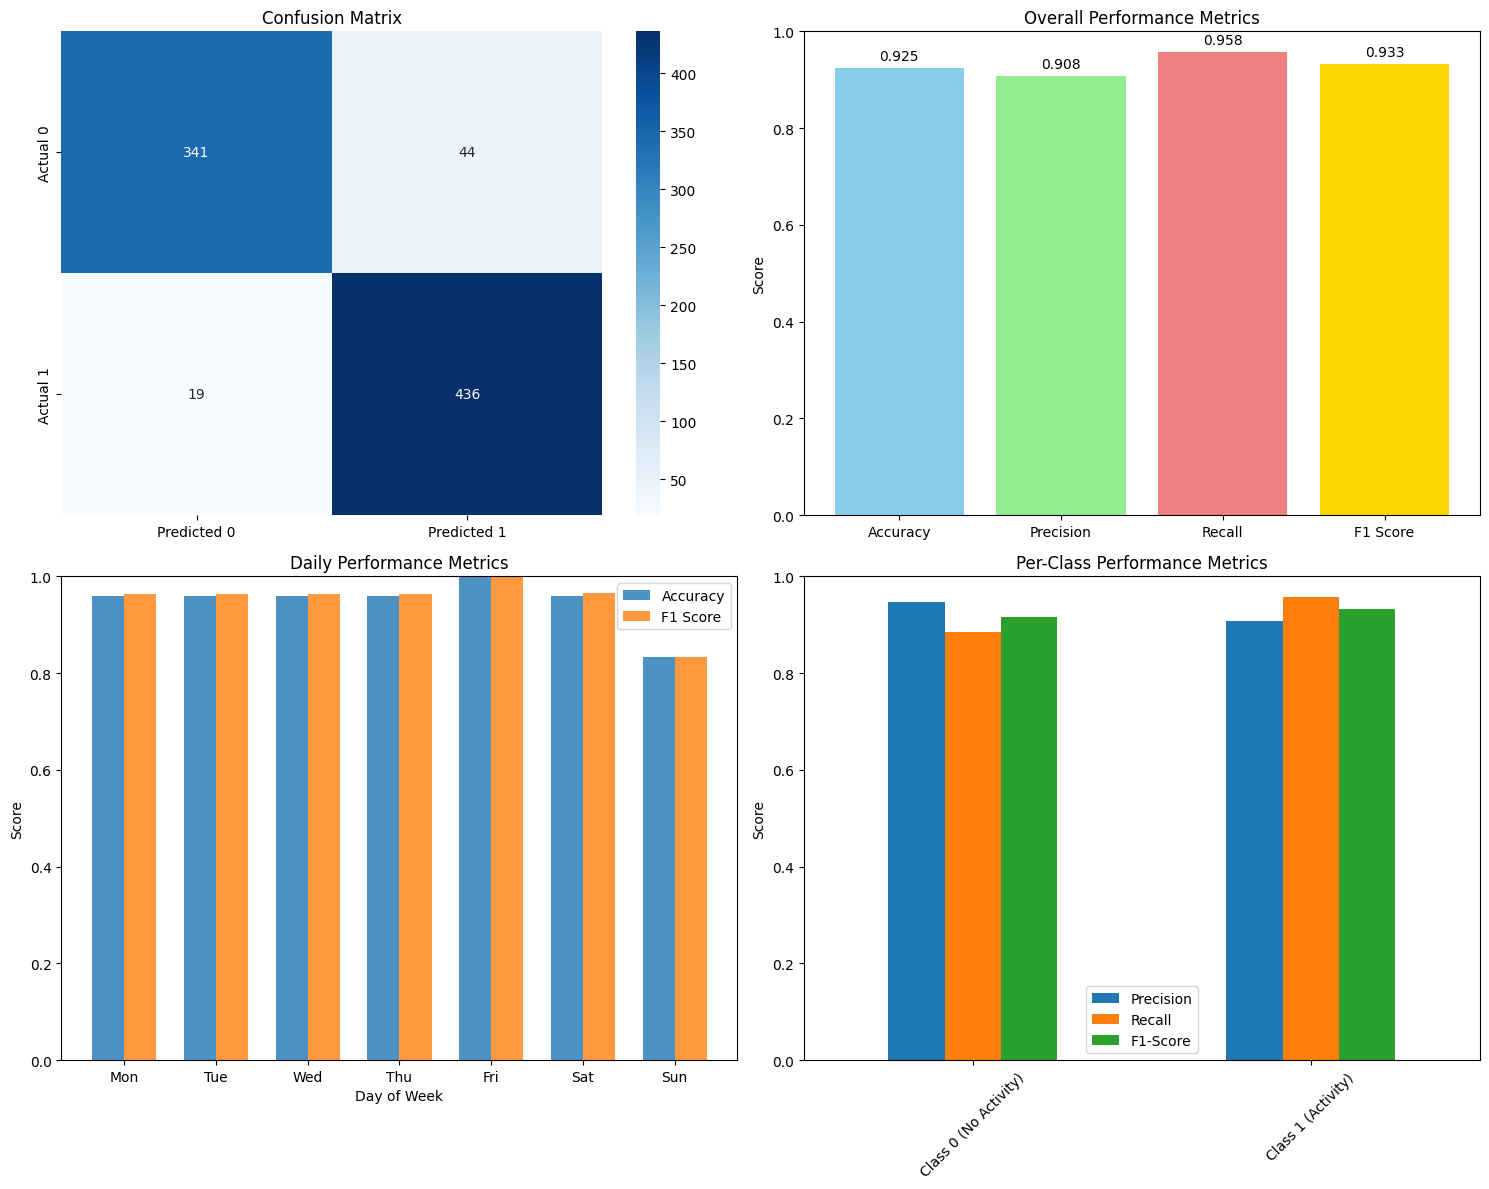


Generating weekly pattern visualization...


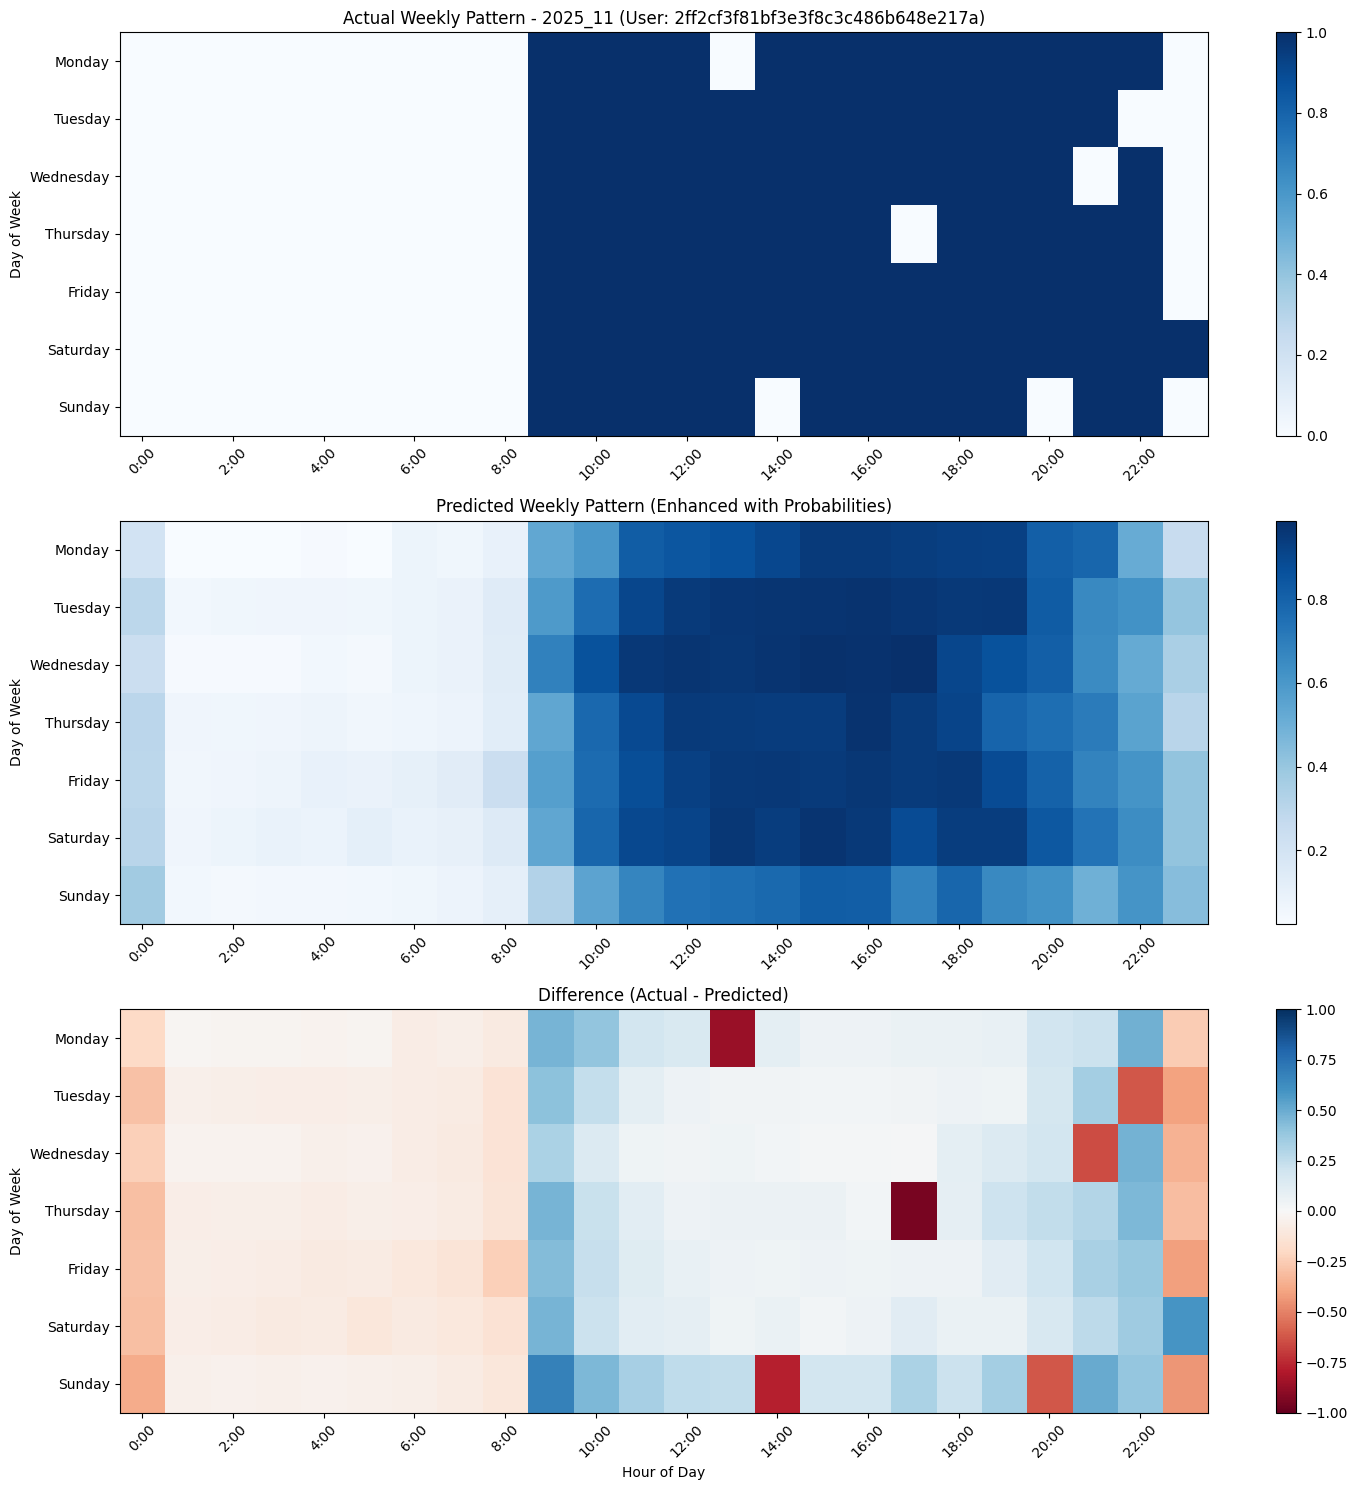


Metrics for this specific prediction:
Accuracy: 0.9464
Precision: 0.9375
Recall: 0.9677
F1 Score: 0.9524


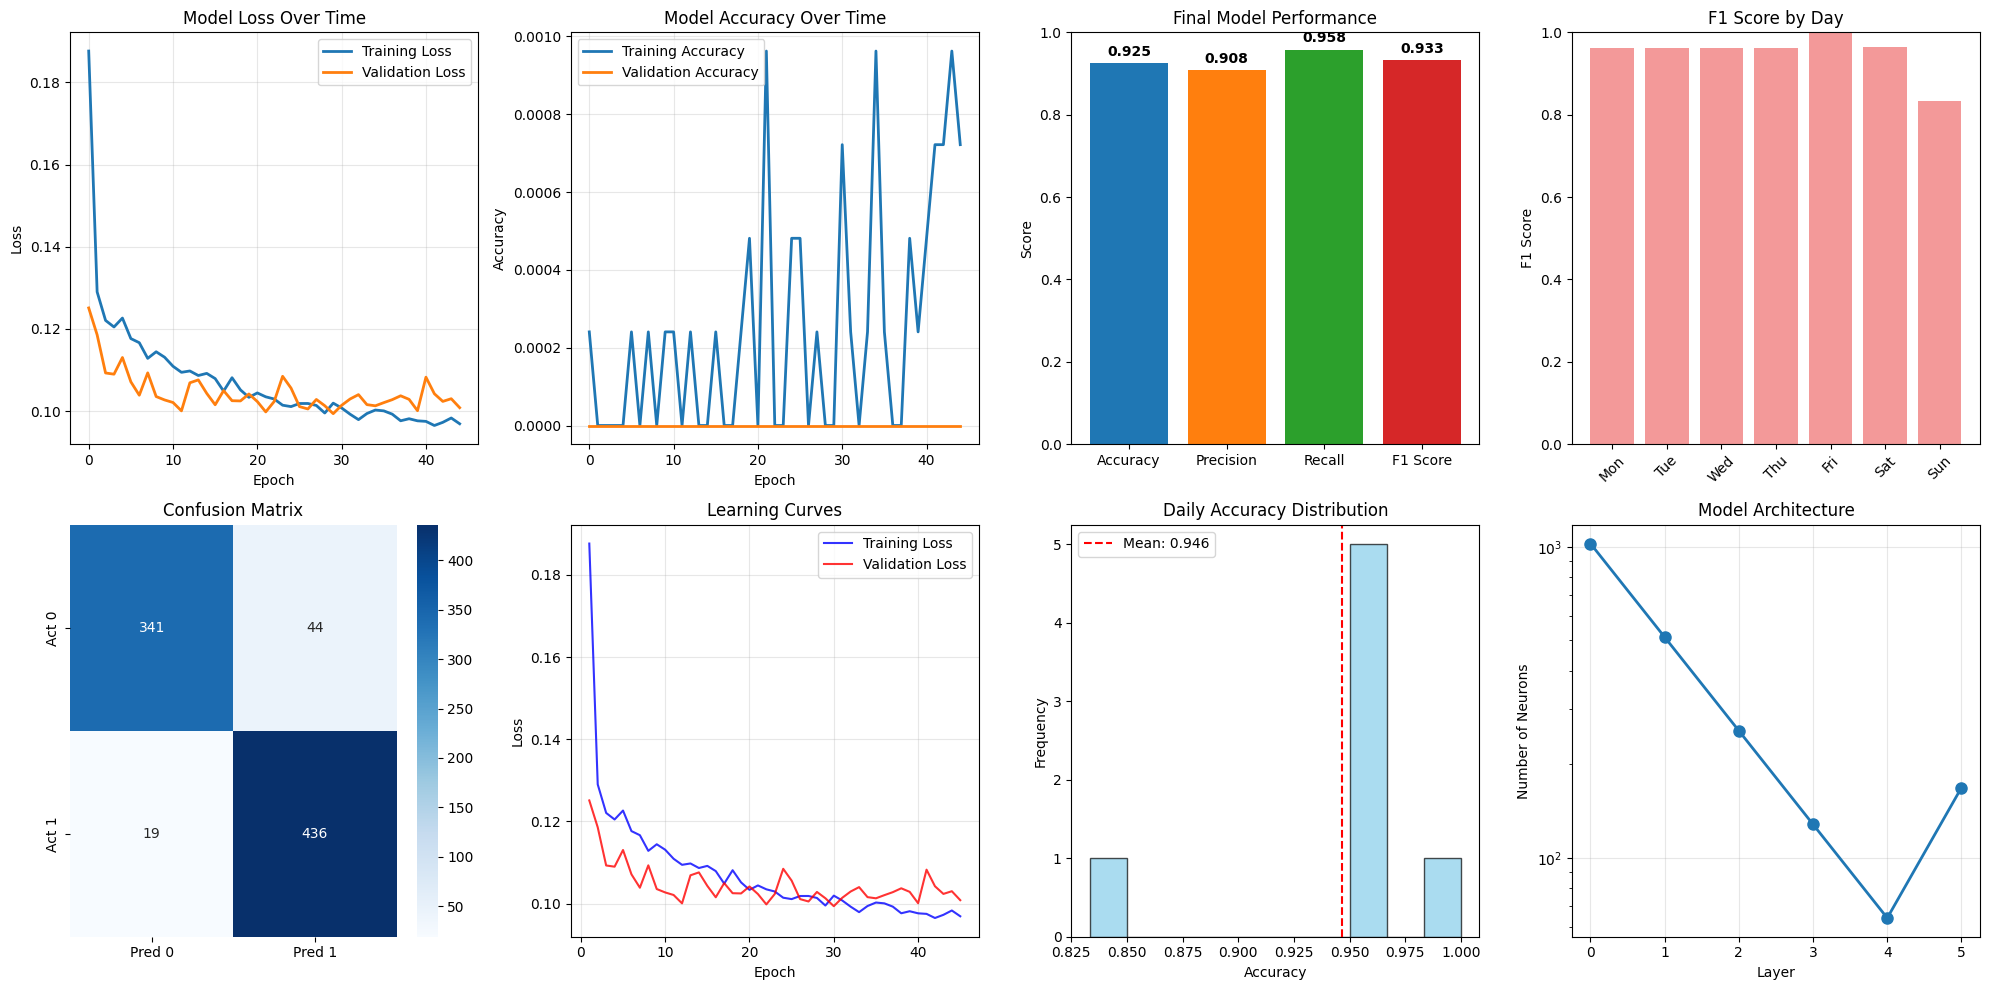


FINAL EVALUATION SUMMARY
Model Architecture: 6-layer Neural Network with Dropout and BatchNorm
Input Features: 504 (Timestamps + Probability features)
Output: 168 binary predictions (7 days × 24 hours)
Training Method: Early stopping with validation monitoring

PERFORMANCE METRICS:
  • Overall Accuracy: 0.9250
  • Precision: 0.9083
  • Recall: 0.9582
  • F1 Score: 0.9326

DAILY PERFORMANCE:
  • Average Daily Accuracy: 0.9464
  • Average Daily F1 Score: 0.9501
  • Best Performing Day: Friday (F1: 1.0000)
  • Worst Performing Day: Sunday (F1: 0.8333)

CONFUSION MATRIX:
  True Negatives:     341    False Positives:     44
  False Negatives:     19    True Positives:     436


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_data(file_path, probability_file_path):
    """
    Load the CSV file and preprocess the data for Neural Network training
    Now also loads probability data to enhance features
    """
    # Read the timestamp CSV file
    df = pd.read_csv(file_path)

    # Read the probability CSV file
    prob_df = pd.read_csv(probability_file_path)

    # Convert DATE column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Add day of week information
    df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
    df['WEEK_NUMBER'] = df['DATE'].dt.isocalendar().week
    df['YEAR'] = df['DATE'].dt.year
    df['WEEK_YEAR'] = df['YEAR'].astype(str) + '_' + df['WEEK_NUMBER'].astype(str)

    # Sort by USER_ID and DATE
    df = df.sort_values(['USER_ID', 'DATE']).reset_index(drop=True)

    # Extract hourly columns (12am through 11pm)
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    return df, prob_df, hourly_columns

def select_consistent_users(data, prob_data, target_user_id='2ff2cf3f81bf3e3f8c3c486b648e217a', max_users=1000):
    """
    Select consistent users from both datasets, ensuring target user is included
    """
    # Get common users between both datasets
    timestamp_users = set(data['USER_ID'].unique())
    prob_users = set(prob_data['USER_ID'].unique())
    common_users = list(timestamp_users.intersection(prob_users))

    print(f"Total common users between datasets: {len(common_users)}")

    # Sort for consistent ordering
    common_users.sort()

    # Check if target user exists in common users
    target_user_exists = target_user_id in common_users
    print(f"Target user {target_user_id} exists in both datasets: {target_user_exists}")

    # Select users with sufficient data
    valid_users = []

    # First, validate and add target user if it exists
    if target_user_exists:
        user_timestamp_data = data[data['USER_ID'] == target_user_id]
        user_prob_data = prob_data[prob_data['USER_ID'] == target_user_id]

        # Check if target user has sufficient data
        if len(user_timestamp_data) > 0 and len(user_prob_data) > 0:
            # Check for weekly completeness
            user_weeks = user_timestamp_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks
                valid_users.append(target_user_id)
                print(f"Target user {target_user_id} added - has {complete_weeks} complete weeks")
            else:
                print(f"Target user {target_user_id} has insufficient data - only {complete_weeks} complete weeks")
        else:
            print(f"Target user {target_user_id} has no data in one or both datasets")

    # Now add other users (excluding target user to avoid duplicates)
    other_users = [user for user in common_users if user != target_user_id]

    for user_id in other_users:
        if len(valid_users) >= max_users:
            break

        user_timestamp_data = data[data['USER_ID'] == user_id]
        user_prob_data = prob_data[prob_data['USER_ID'] == user_id]

        if len(user_timestamp_data) > 0 and len(user_prob_data) > 0:
            # Check for weekly completeness
            user_weeks = user_timestamp_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks for training
                valid_users.append(user_id)

    print(f"Selected {len(valid_users)} users with sufficient data in both datasets")
    print(f"Target user {target_user_id} is included: {target_user_id in valid_users}")
    print(f"First 10 selected users: {valid_users[:10]}")

    return valid_users

def create_weekly_sequences_with_probabilities(data, prob_data, selected_users, sequence_weeks=1):
    """
    Create weekly sequences from data for Neural Network training
    Enhanced with probability features from the second dataset
    Input: sequence_weeks weeks to predict next week's pattern
    """
    sequences = []
    targets = []
    user_info = []

    # Days of week in order
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Hourly columns
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    print(f"Processing {len(selected_users)} selected users...")

    # Group by user to create sequences
    for idx, user_id in enumerate(selected_users):
        if idx % 100 == 0:
            print(f"Processing user {idx+1}/{len(selected_users)}: {user_id}")

        user_data = data[data['USER_ID'] == user_id].sort_values('DATE')
        user_prob_data = prob_data[prob_data['USER_ID'] == user_id]

        # Create probability lookup for this user
        prob_lookup = {}
        for _, row in user_prob_data.iterrows():
            prob_lookup[row['Timestamp']] = {
                'weighted_prob_0': row['Weighted_Prob_0'],
                'weighted_prob_1': row['Weighted_Prob_1']
            }

        # Group by week for this user
        weekly_data = {}
        weekly_prob_features = {}

        for week_year in user_data['WEEK_YEAR'].unique():
            week_data = user_data[user_data['WEEK_YEAR'] == week_year]

            # Check if we have all 7 days for this week
            if len(week_data) == 7:
                # Sort by day of week to ensure Monday-Sunday order
                week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()

                # Check if we have data for all days (no NaN after reindexing)
                if not week_data[hourly_columns].isnull().any().any():
                    weekly_data[week_year] = week_data[hourly_columns].values  # Shape: (7, 24)

                    # Create probability features for this week
                    week_prob_features = []
                    for day_idx in range(7):
                        day_probs = []
                        for hour_col in hourly_columns:
                            if hour_col in prob_lookup:
                                day_probs.extend([
                                    prob_lookup[hour_col]['weighted_prob_0'],
                                    prob_lookup[hour_col]['weighted_prob_1']
                                ])
                            else:
                                # Default probabilities if not found
                                day_probs.extend([0.5, 0.5])
                        week_prob_features.append(day_probs)

                    weekly_prob_features[week_year] = np.array(week_prob_features)  # Shape: (7, 48)

        # Create sequences from complete weeks
        week_keys = sorted(weekly_data.keys())

        for i in range(len(week_keys) - sequence_weeks):
            # Get input weeks (flatten them)
            input_weeks = []
            input_prob_features = []

            for j in range(sequence_weeks):
                week_data = weekly_data[week_keys[i + j]]  # Shape: (7, 24)
                week_prob = weekly_prob_features[week_keys[i + j]]  # Shape: (7, 48)

                input_weeks.append(week_data.flatten())  # Flatten to (168,)
                input_prob_features.append(week_prob.flatten())  # Flatten to (336,)

            # Concatenate all input weeks and probability features
            sequence_timestamps = np.concatenate(input_weeks)  # Shape: (sequence_weeks * 168,)
            sequence_probs = np.concatenate(input_prob_features)  # Shape: (sequence_weeks * 336,)
            sequence = np.concatenate([sequence_timestamps, sequence_probs])  # Combined features

            # Get target week
            target_week = weekly_data[week_keys[i + sequence_weeks]]  # Shape: (7, 24)
            target = target_week.flatten()  # Flatten to (168,)

            sequences.append(sequence)
            targets.append(target)
            user_info.append({
                'user_id': user_id,
                'input_weeks': [week_keys[i + j] for j in range(sequence_weeks)],
                'target_week': week_keys[i + sequence_weeks]
            })

    return np.array(sequences), np.array(targets), user_info

def create_nn_model_weekly_enhanced(input_dim, output_dim=168):  # 7 days * 24 hours = 168
    """
    Create Enhanced Neural Network model for predicting full weekly patterns
    Now handles combined timestamp and probability features
    """
    model = Sequential([
        Dense(1024, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        Dropout(0.2),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # 168 outputs for 7 days * 24 hours
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def calculate_comprehensive_metrics(y_true, y_pred, y_pred_binary=None):
    """
    Calculate comprehensive evaluation metrics including F1, recall, precision, confusion matrix
    """
    if y_pred_binary is None:
        y_pred_binary = (y_pred > 0.5).astype(int)

    # Flatten arrays if they're multi-dimensional
    if len(y_true.shape) > 1:
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
        y_pred_binary_flat = y_pred_binary.flatten()
    else:
        y_true_flat = y_true
        y_pred_flat = y_pred
        y_pred_binary_flat = y_pred_binary

    # Calculate metrics
    accuracy = accuracy_score(y_true_flat, y_pred_binary_flat)
    precision = precision_score(y_true_flat, y_pred_binary_flat, average='binary')
    recall = recall_score(y_true_flat, y_pred_binary_flat, average='binary')
    f1 = f1_score(y_true_flat, y_pred_binary_flat, average='binary')

    # Confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_binary_flat)

    # Classification report
    class_report = classification_report(y_true_flat, y_pred_binary_flat, output_dict=True)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'classification_report': class_report
    }

    return metrics

def evaluate_model_comprehensive(model, X_test, y_test, scaler=None, verbose=True):
    """
    Comprehensive model evaluation with all metrics
    """
    if scaler is not None:
        X_test_scaled = scaler.transform(X_test)
    else:
        X_test_scaled = X_test

    # Get predictions
    y_pred_proba = model.predict(X_test_scaled, verbose=0)
    y_pred_binary = (y_pred_proba > 0.5).astype(int)

    # Calculate comprehensive metrics
    metrics = calculate_comprehensive_metrics(y_test, y_pred_proba, y_pred_binary)

    if verbose:
        print("=" * 60)
        print("COMPREHENSIVE MODEL EVALUATION RESULTS")
        print("=" * 60)
        print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1_score']:.4f}")
        print()

        print("Confusion Matrix:")
        print(metrics['confusion_matrix'])
        print()

        print("Classification Report:")
        for class_name, class_metrics in metrics['classification_report'].items():
            if isinstance(class_metrics, dict):
                print(f"{class_name}: Precision={class_metrics['precision']:.4f}, "
                      f"Recall={class_metrics['recall']:.4f}, F1={class_metrics['f1-score']:.4f}")

    return metrics, y_pred_proba, y_pred_binary

def quick_test_weekly_enhanced_model_with_metrics(model, df, prob_df, hourly_columns, scaler, sequence_weeks=1):
    """
    Enhanced quick test with comprehensive metrics for the target user
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    print(f"\nTesting specifically with target user: {TARGET_USER_ID}")

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in timestamp data")
        return

    if TARGET_USER_ID not in prob_df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in probability data")
        return

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')
    user_prob_data = prob_df[prob_df['USER_ID'] == TARGET_USER_ID]

    print(f"User has {len(user_data)} timestamp records and {len(user_prob_data)} probability records")

    # Create probability lookup
    prob_lookup = {}
    for _, row in user_prob_data.iterrows():
        prob_lookup[row['Timestamp']] = {
            'weighted_prob_0': row['Weighted_Prob_0'],
            'weighted_prob_1': row['Weighted_Prob_1']
        }

    weekly_data = {}
    weekly_prob_features = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

                # Create probability features
                week_prob_features = []
                for day_idx in range(7):
                    day_probs = []
                    for hour_col in hourly_columns:
                        if hour_col in prob_lookup:
                            day_probs.extend([
                                prob_lookup[hour_col]['weighted_prob_0'],
                                prob_lookup[hour_col]['weighted_prob_1']
                            ])
                        else:
                            day_probs.extend([0.5, 0.5])
                    week_prob_features.append(day_probs)

                weekly_prob_features[week_year] = np.array(week_prob_features)

    week_keys = sorted(weekly_data.keys())
    print(f"User has {len(week_keys)} complete weeks: {week_keys}")

    if len(week_keys) < 2:
        print("Insufficient complete weeks for testing")
        return

    # Collect all available predictions for comprehensive evaluation
    all_predictions = []
    all_actuals = []
    all_predictions_binary = []

    # Test on multiple weeks if available
    test_weeks = min(len(week_keys) - 1, 5)  # Test up to 5 weeks

    for i in range(test_weeks):
        input_week_timestamps = weekly_data[week_keys[i]].flatten()
        input_week_probs = weekly_prob_features[week_keys[i]].flatten()
        input_week = np.concatenate([input_week_timestamps, input_week_probs]).reshape(1, -1)

        actual_next_week = weekly_data[week_keys[i + 1]].flatten()

        # Scale input and predict
        input_week_scaled = scaler.transform(input_week)
        prediction = model.predict(input_week_scaled, verbose=0)[0]
        predicted_binary = (prediction > 0.5).astype(int)

        all_predictions.extend(prediction)
        all_actuals.extend(actual_next_week)
        all_predictions_binary.extend(predicted_binary)

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_actuals = np.array(all_actuals)
    all_predictions_binary = np.array(all_predictions_binary)

    # Calculate comprehensive metrics
    metrics = calculate_comprehensive_metrics(all_actuals, all_predictions, all_predictions_binary)

    print(f"\nCOMPREHENSIVE EVALUATION RESULTS for Target User {TARGET_USER_ID}:")
    print(f"Tested on {test_weeks} week predictions")
    print("=" * 50)
    print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print()

    print("Confusion Matrix:")
    print("                 Predicted")
    print("                 0      1")
    print(f"Actual    0   {metrics['confusion_matrix'][0][0]:6d} {metrics['confusion_matrix'][0][1]:6d}")
    print(f"          1   {metrics['confusion_matrix'][1][0]:6d} {metrics['confusion_matrix'][1][1]:6d}")
    print()

    # Day-by-day analysis for the first prediction
    print("Day-by-day accuracy for first prediction:")
    input_week_timestamps = weekly_data[week_keys[0]].flatten()
    input_week_probs = weekly_prob_features[week_keys[0]].flatten()
    input_week = np.concatenate([input_week_timestamps, input_week_probs]).reshape(1, -1)
    actual_next_week = weekly_data[week_keys[1]].flatten()
    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled, verbose=0)[0]
    predicted_binary = (prediction > 0.5).astype(int)

    daily_metrics = []
    for day_idx, day in enumerate(days_order):
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        day_actual = actual_next_week[start_idx:end_idx]
        day_predicted = predicted_binary[start_idx:end_idx]

        day_accuracy = accuracy_score(day_actual, day_predicted)
        day_f1 = f1_score(day_actual, day_predicted, average='binary', zero_division=0)
        day_recall = recall_score(day_actual, day_predicted, average='binary', zero_division=0)
        day_precision = precision_score(day_actual, day_predicted, average='binary', zero_division=0)

        daily_metrics.append({
            'day': day,
            'accuracy': day_accuracy,
            'f1': day_f1,
            'recall': day_recall,
            'precision': day_precision
        })

        print(f"{day}: Acc={day_accuracy:.3f}, F1={day_f1:.3f}, Recall={day_recall:.3f}, Prec={day_precision:.3f}")

    # Detailed comparison for first 3 days
    print(f"\nDetailed comparison for first 3 days (Input: {week_keys[0]} -> Target: {week_keys[1]}):")
    for day_idx in range(3):
        day = days_order[day_idx]
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        day_actual = actual_next_week[start_idx:end_idx]
        day_predicted = predicted_binary[start_idx:end_idx]
        day_probs = prediction[start_idx:end_idx]

        print(f"{day}:")
        print(f"  Actual:    {day_actual}")
        print(f"  Predicted: {day_predicted}")
        print(f"  Prob scores (first 12h): {day_probs[:12].round(3)}")
        print()

    return metrics, daily_metrics

def visualize_comprehensive_results(metrics, daily_metrics=None):
    """
    Create comprehensive visualizations of the evaluation results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Confusion Matrix Heatmap
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'], ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')

    # 2. Metrics Bar Chart
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    metric_values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']]

    bars = axes[0,1].bar(metric_names, metric_values, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    axes[0,1].set_title('Overall Performance Metrics')
    axes[0,1].set_ylabel('Score')
    axes[0,1].set_ylim(0, 1)

    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{value:.3f}', ha='center', va='bottom')

    # 3. Daily Metrics (if available)
    if daily_metrics:
        days = [dm['day'][:3] for dm in daily_metrics]  # Abbreviated day names
        daily_acc = [dm['accuracy'] for dm in daily_metrics]
        daily_f1 = [dm['f1'] for dm in daily_metrics]

        x = np.arange(len(days))
        width = 0.35

        axes[1,0].bar(x - width/2, daily_acc, width, label='Accuracy', alpha=0.8)
        axes[1,0].bar(x + width/2, daily_f1, width, label='F1 Score', alpha=0.8)
        axes[1,0].set_xlabel('Day of Week')
        axes[1,0].set_ylabel('Score')
        axes[1,0].set_title('Daily Performance Metrics')
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(days)
        axes[1,0].legend()
        axes[1,0].set_ylim(0, 1)

    # 4. Classification Report Visualization
    if 'classification_report' in metrics:
        class_report = metrics['classification_report']
        metrics_df = pd.DataFrame({
            'Precision': [class_report['0']['precision'], class_report['1']['precision']],
            'Recall': [class_report['0']['recall'], class_report['1']['recall']],
            'F1-Score': [class_report['0']['f1-score'], class_report['1']['f1-score']]
        }, index=['Class 0 (No Activity)', 'Class 1 (Activity)'])

        metrics_df.plot(kind='bar', ax=axes[1,1], rot=45)
        axes[1,1].set_title('Per-Class Performance Metrics')
        axes[1,1].set_ylabel('Score')
        axes[1,1].legend()
        axes[1,1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

def train_weekly_model():
    """
    Train the enhanced model on weekly patterns with comprehensive evaluation
    """
    # Configuration
    FILE_PATH = '/content/drive/MyDrive/3M-timestamp.csv'
    PROBABILITY_FILE_PATH = '/content/drive/MyDrive/weighted_time_probabilities_by_user.csv'
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    SEQUENCE_WEEKS = 1  # Use 1 week to predict next week
    MAX_USERS = 1000

    print("Loading and preprocessing data...")
    df, prob_df, hourly_columns = load_and_preprocess_data(FILE_PATH, PROBABILITY_FILE_PATH)

    print(f"Timestamp data shape: {df.shape}")
    print(f"Probability data shape: {prob_df.shape}")
    print(f"Number of unique users in timestamp data: {df['USER_ID'].nunique()}")
    print(f"Number of unique users in probability data: {prob_df['USER_ID'].nunique()}")
    print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")
    print(f"Unique weeks: {df['WEEK_YEAR'].nunique()}")

    # Select consistent users including target user
    print(f"\nSelecting up to {MAX_USERS} users including target user {TARGET_USER_ID}...")
    selected_users = select_consistent_users(df, prob_df, TARGET_USER_ID, MAX_USERS)

    if len(selected_users) == 0:
        print("No users with sufficient data found!")
        return None, None, None, None, None, None

    # Create weekly sequences with probability features
    print("Creating enhanced weekly sequences...")
    X, y, user_info = create_weekly_sequences_with_probabilities(df, prob_df, selected_users, SEQUENCE_WEEKS)

    print(f"Total weekly sequences: {len(X)}")
    print(f"Enhanced input sequence shape: {X.shape}")
    print(f"Target shape: {y.shape}")

    if len(X) == 0:
        print("No complete weekly sequences found! Check your data.")
        return None, None, None, None, None, None

    # Split data for training and testing
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create and compile enhanced model
    print("Creating Enhanced Neural Network model for weekly prediction")
    model = create_nn_model_weekly_enhanced(
        input_dim=X_train_scaled.shape[1],
        output_dim=168
    )

    print("Enhanced Model architecture:")
    model.summary()

    # Set up callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    # Train the model
    print("Training enhanced model on weekly patterns...")
    history = model.fit(
        X_train_scaled, y_train,
        batch_size=16,
        epochs=100,
        callbacks=[early_stopping],
        verbose=1,
        validation_data=(X_test_scaled, y_test)
    )

    # Comprehensive evaluation on test set
    print("\n" + "="*60)
    print("COMPREHENSIVE MODEL EVALUATION ON TEST SET")
    print("="*60)

    test_metrics, y_pred_proba, y_pred_binary = evaluate_model_comprehensive(
        model, X_test, y_test, scaler, verbose=True
    )

    # Save the model and scaler
    model.save('notification_nn_weekly_enhanced_model.h5')
    print("\nEnhanced model saved as 'notification_nn_weekly_enhanced_model.h5'")

    # Save additional info
    np.save('weekly_enhanced_model_info.npy', {
        'hourly_columns': hourly_columns,
        'sequence_weeks': SEQUENCE_WEEKS,
        'user_info_sample': user_info[:5],
        'scaler_mean': scaler.mean_,
        'scaler_scale': scaler.scale_,
        'selected_users': selected_users,
        'target_user_id': TARGET_USER_ID,
        'test_metrics': test_metrics
    }, allow_pickle=True)

    return model, history, df, prob_df, hourly_columns, scaler

def visualize_weekly_prediction_enhanced(model, df, prob_df, hourly_columns, scaler):
    """
    Create visualization of enhanced weekly prediction vs actual for target user
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values or TARGET_USER_ID not in prob_df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in datasets")
        return

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')
    user_prob_data = prob_df[prob_df['USER_ID'] == TARGET_USER_ID]

    prob_lookup = {}
    for _, row in user_prob_data.iterrows():
        prob_lookup[row['Timestamp']] = {
            'weighted_prob_0': row['Weighted_Prob_0'],
            'weighted_prob_1': row['Weighted_Prob_1']
        }

    weekly_data = {}
    weekly_prob_features = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

                week_prob_features = []
                for day_idx in range(7):
                    day_probs = []
                    for hour_col in hourly_columns:
                        if hour_col in prob_lookup:
                            day_probs.extend([
                                prob_lookup[hour_col]['weighted_prob_0'],
                                prob_lookup[hour_col]['weighted_prob_1']
                            ])
                        else:
                            day_probs.extend([0.5, 0.5])
                    week_prob_features.append(day_probs)

                weekly_prob_features[week_year] = np.array(week_prob_features)

    if len(weekly_data) < 2:
        print("Insufficient data for visualization")
        return

    # Get prediction
    week_keys = sorted(weekly_data.keys())
    input_week_timestamps = weekly_data[week_keys[0]].flatten()
    input_week_probs = weekly_prob_features[week_keys[0]].flatten()
    input_week = np.concatenate([input_week_timestamps, input_week_probs]).reshape(1, -1)

    actual_next_week = weekly_data[week_keys[1]]

    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled, verbose=0)[0]
    predicted_week = prediction.reshape(7, 24)

    # Create comprehensive visualization
    fig, axes = plt.subplots(3, 1, figsize=(15, 15))

    # Actual pattern
    im1 = axes[0].imshow(actual_next_week, cmap='Blues', aspect='auto')
    axes[0].set_title(f'Actual Weekly Pattern - {week_keys[1]} (User: {TARGET_USER_ID})')
    axes[0].set_ylabel('Day of Week')
    axes[0].set_yticks(range(7))
    axes[0].set_yticklabels(days_order)
    axes[0].set_xticks(range(0, 24, 2))
    axes[0].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)
    plt.colorbar(im1, ax=axes[0])

    # Predicted pattern
    im2 = axes[1].imshow(predicted_week, cmap='Blues', aspect='auto')
    axes[1].set_title(f'Predicted Weekly Pattern (Enhanced with Probabilities)')
    axes[1].set_ylabel('Day of Week')
    axes[1].set_yticks(range(7))
    axes[1].set_yticklabels(days_order)
    axes[1].set_xticks(range(0, 24, 2))
    axes[1].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)
    plt.colorbar(im2, ax=axes[1])

    # Difference heatmap
    difference = actual_next_week - predicted_week
    im3 = axes[2].imshow(difference, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
    axes[2].set_title('Difference (Actual - Predicted)')
    axes[2].set_ylabel('Day of Week')
    axes[2].set_xlabel('Hour of Day')
    axes[2].set_yticks(range(7))
    axes[2].set_yticklabels(days_order)
    axes[2].set_xticks(range(0, 24, 2))
    axes[2].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)
    plt.colorbar(im3, ax=axes[2])

    plt.tight_layout()
    plt.show()

    # Calculate and display metrics for this specific prediction
    actual_flat = actual_next_week.flatten()
    predicted_flat = predicted_week.flatten()
    predicted_binary_flat = (predicted_flat > 0.5).astype(int)

    metrics = calculate_comprehensive_metrics(actual_flat, predicted_flat, predicted_binary_flat)

    print(f"\nMetrics for this specific prediction:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")

def create_detailed_evaluation_report(model, df, prob_df, hourly_columns, scaler):
    """
    Create a detailed evaluation report with multiple test cases
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'

    print("=" * 80)
    print("DETAILED EVALUATION REPORT")
    print("=" * 80)

    # Test on target user with comprehensive metrics
    target_metrics, daily_metrics = quick_test_weekly_enhanced_model_with_metrics(
        model, df, prob_df, hourly_columns, scaler
    )

    # Create visualizations
    print("\nGenerating comprehensive visualizations...")
    visualize_comprehensive_results(target_metrics, daily_metrics)

    # Weekly pattern visualization
    print("\nGenerating weekly pattern visualization...")
    visualize_weekly_prediction_enhanced(model, df, prob_df, hourly_columns, scaler)

    return target_metrics, daily_metrics

if __name__ == "__main__":
    # Train the enhanced weekly model with comprehensive evaluation
    model, history, df, prob_df, hourly_columns, scaler = train_weekly_model()

    if model is not None:
        # Create detailed evaluation report
        target_metrics, daily_metrics = create_detailed_evaluation_report(
            model, df, prob_df, hourly_columns, scaler
        )

        # Plot comprehensive training history
        plt.figure(figsize=(20, 10))

        # Training metrics
        plt.subplot(2, 4, 1)
        plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
        plt.title('Model Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(2, 4, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        plt.title('Model Accuracy Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Final metrics summary
        plt.subplot(2, 4, 3)
        final_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
        final_values = [
            target_metrics['accuracy'],
            target_metrics['precision'],
            target_metrics['recall'],
            target_metrics['f1_score']
        ]
        bars = plt.bar(final_metrics, final_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
        plt.title('Final Model Performance')
        plt.ylabel('Score')
        plt.ylim(0, 1)
        for bar, value in zip(bars, final_values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

        # Daily performance
        if daily_metrics:
            plt.subplot(2, 4, 4)
            days = [dm['day'][:3] for dm in daily_metrics]
            daily_f1 = [dm['f1'] for dm in daily_metrics]
            plt.bar(days, daily_f1, color='lightcoral', alpha=0.8)
            plt.title('F1 Score by Day')
            plt.ylabel('F1 Score')
            plt.ylim(0, 1)
            plt.xticks(rotation=45)

        # Confusion matrix visualization
        plt.subplot(2, 4, 5)
        cm = target_metrics['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Pred 0', 'Pred 1'],
                   yticklabels=['Act 0', 'Act 1'])
        plt.title('Confusion Matrix')

        # Learning curves comparison
        plt.subplot(2, 4, 6)
        epochs = range(1, len(history.history['loss']) + 1)
        plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss', alpha=0.8)
        if 'val_loss' in history.history:
            plt.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', alpha=0.8)
        plt.title('Learning Curves')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Performance distribution
        plt.subplot(2, 4, 7)
        if daily_metrics:
            daily_accuracies = [dm['accuracy'] for dm in daily_metrics]
            plt.hist(daily_accuracies, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
            plt.title('Daily Accuracy Distribution')
            plt.xlabel('Accuracy')
            plt.ylabel('Frequency')
            plt.axvline(np.mean(daily_accuracies), color='red', linestyle='--',
                       label=f'Mean: {np.mean(daily_accuracies):.3f}')
            plt.legend()

        # Model complexity visualization
        plt.subplot(2, 4, 8)
        layer_sizes = [1024, 512, 256, 128, 64, 168]  # Your model architecture
        plt.plot(range(len(layer_sizes)), layer_sizes, 'o-', linewidth=2, markersize=8)
        plt.title('Model Architecture')
        plt.xlabel('Layer')
        plt.ylabel('Number of Neurons')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Print comprehensive summary
        print("\n" + "=" * 80)
        print("FINAL EVALUATION SUMMARY")
        print("=" * 80)
        print(f"Model Architecture: 6-layer Neural Network with Dropout and BatchNorm")
        print(f"Input Features: {scaler.mean_.shape[0]} (Timestamps + Probability features)")
        print(f"Output: 168 binary predictions (7 days × 24 hours)")
        print(f"Training Method: Early stopping with validation monitoring")
        print()
        print("PERFORMANCE METRICS:")
        print(f"  • Overall Accuracy: {target_metrics['accuracy']:.4f}")
        print(f"  • Precision: {target_metrics['precision']:.4f}")
        print(f"  • Recall: {target_metrics['recall']:.4f}")
        print(f"  • F1 Score: {target_metrics['f1_score']:.4f}")
        print()
        if daily_metrics:
            avg_daily_acc = np.mean([dm['accuracy'] for dm in daily_metrics])
            avg_daily_f1 = np.mean([dm['f1'] for dm in daily_metrics])
            print("DAILY PERFORMANCE:")
            print(f"  • Average Daily Accuracy: {avg_daily_acc:.4f}")
            print(f"  • Average Daily F1 Score: {avg_daily_f1:.4f}")
            print(f"  • Best Performing Day: {max(daily_metrics, key=lambda x: x['f1'])['day']} (F1: {max(daily_metrics, key=lambda x: x['f1'])['f1']:.4f})")
            print(f"  • Worst Performing Day: {min(daily_metrics, key=lambda x: x['f1'])['day']} (F1: {min(daily_metrics, key=lambda x: x['f1'])['f1']:.4f})")
        print()
        print("CONFUSION MATRIX:")
        cm = target_metrics['confusion_matrix']
        print(f"  True Negatives:  {cm[0][0]:6d}    False Positives: {cm[0][1]:6d}")
        print(f"  False Negatives: {cm[1][0]:6d}    True Positives:  {cm[1][1]:6d}")
        print("=" * 80)

    else:
        print("Training failed. Please check your data format and completeness.")

### **Random Forest(Raw data)**

Loading and preprocessing data...
Data shape: (6279000, 30)
Number of unique users: 232840
Date range: 2025-01-05 00:00:00 to 2025-04-28 00:00:00
Unique weeks: 18

Selecting up to 1000 users including target user 2ff2cf3f81bf3e3f8c3c486b648e217a...
Total users in dataset: 232840
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a exists in dataset: True
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a added - has 15 complete weeks
Selected 1000 users with sufficient data
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a is included: True
First 10 selected users: ['2ff2cf3f81bf3e3f8c3c486b648e217a', '00001d6eecdf78d72d9cc90d9a0a99c7', '000033ef96774b50806529379c6b69c3', '00020d3a2f68244d04c004aade84fe4f', '00020ff0c04a2a03c307faedc8a389ab', '000303db4509d199169157cc02baa8a9', '00031510761c00a9f6477671538283db', '0003296bc65a205cd51f3554e18dd9a8', '000373f37f604bd69193d151b495d66e', '0005ace1a289c3785d4908f4ac595b51']
Creating weekly sequences...
Processing 1000 selected users...
Processing user 1/1000:

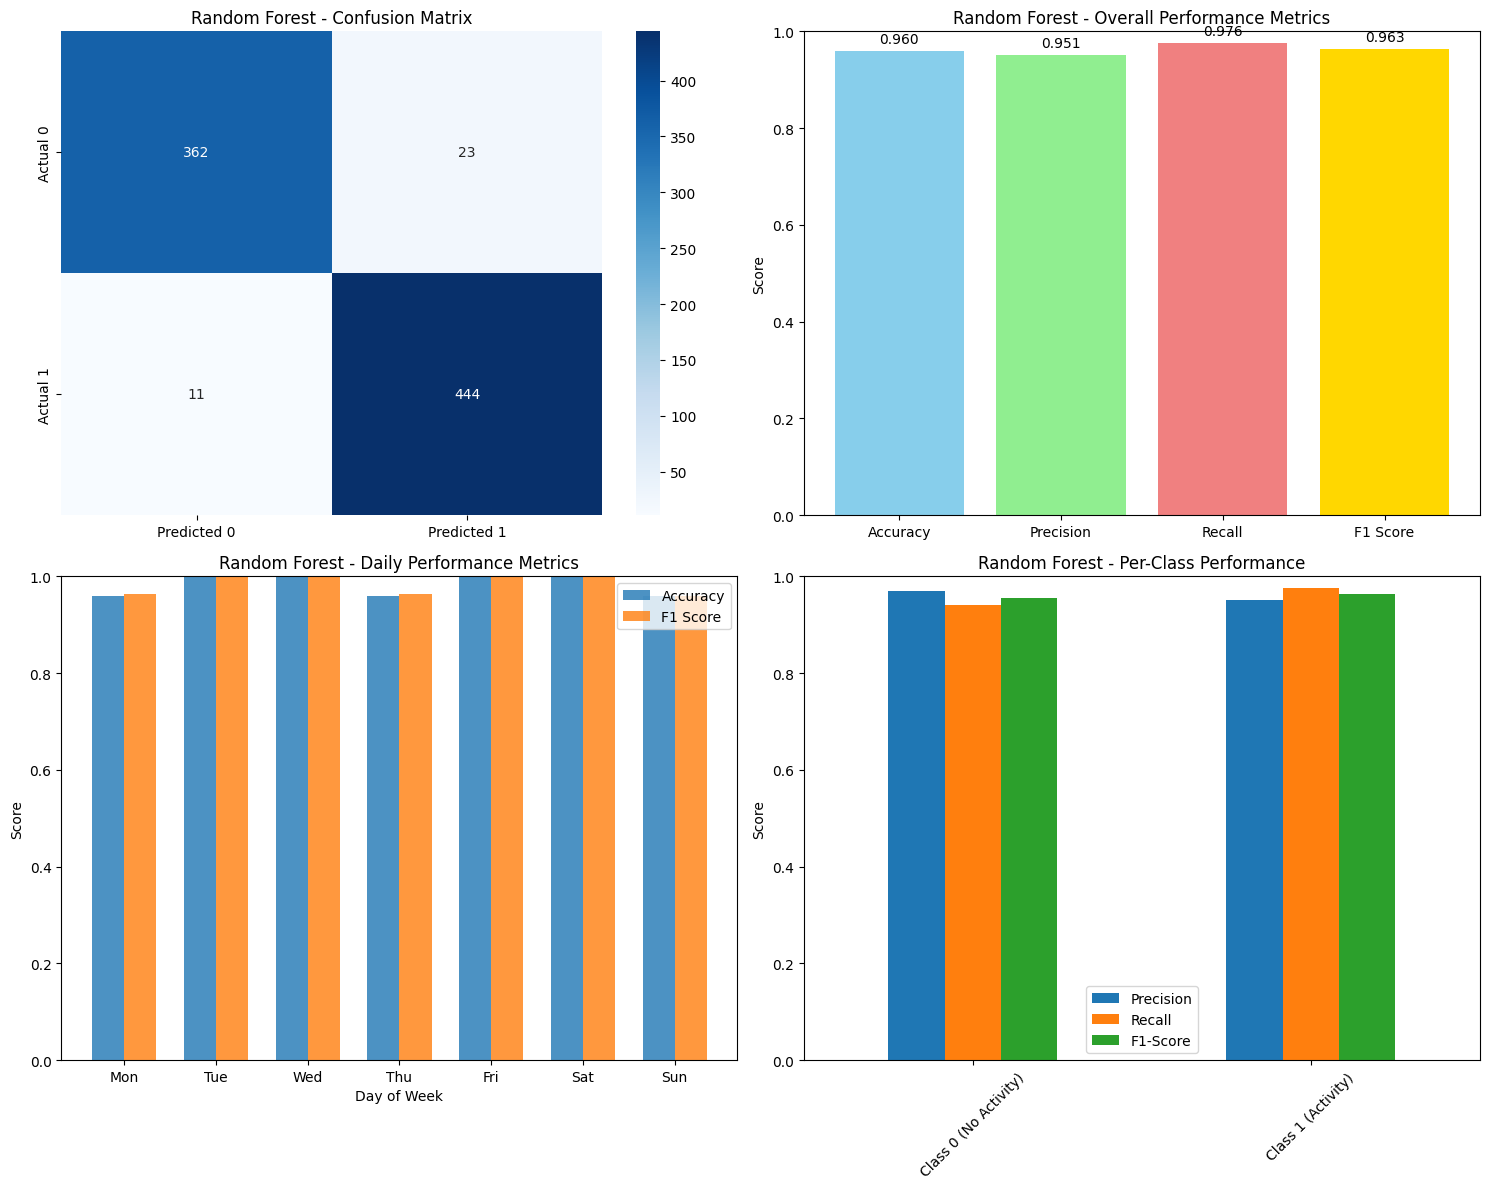


Generating weekly pattern visualization...


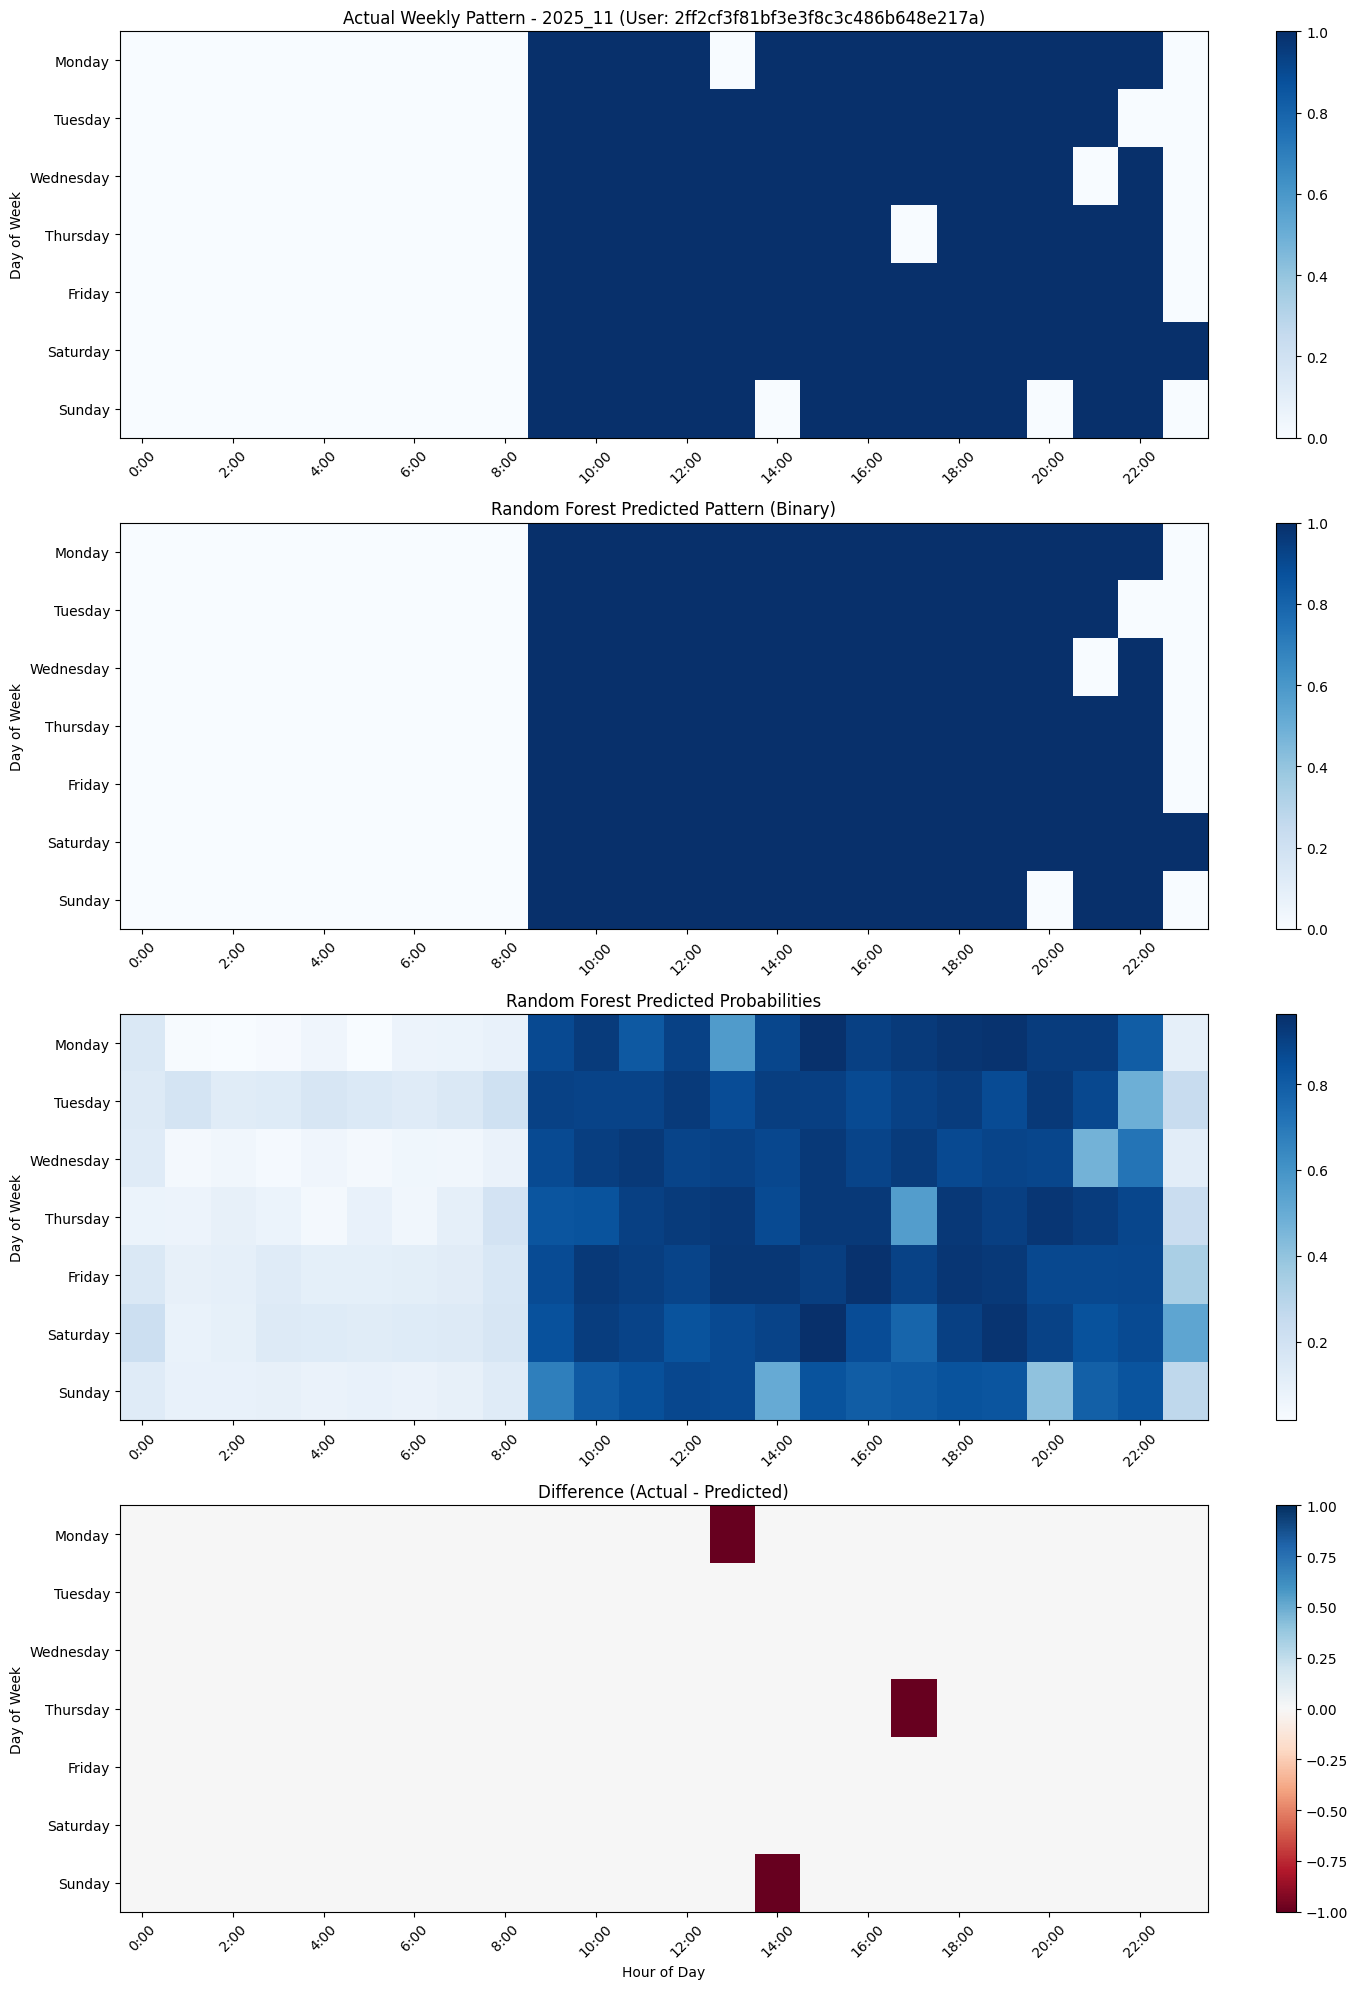


Metrics for this specific prediction:
Accuracy: 0.9821
Precision: 0.9688
Recall: 1.0000
F1 Score: 0.9841


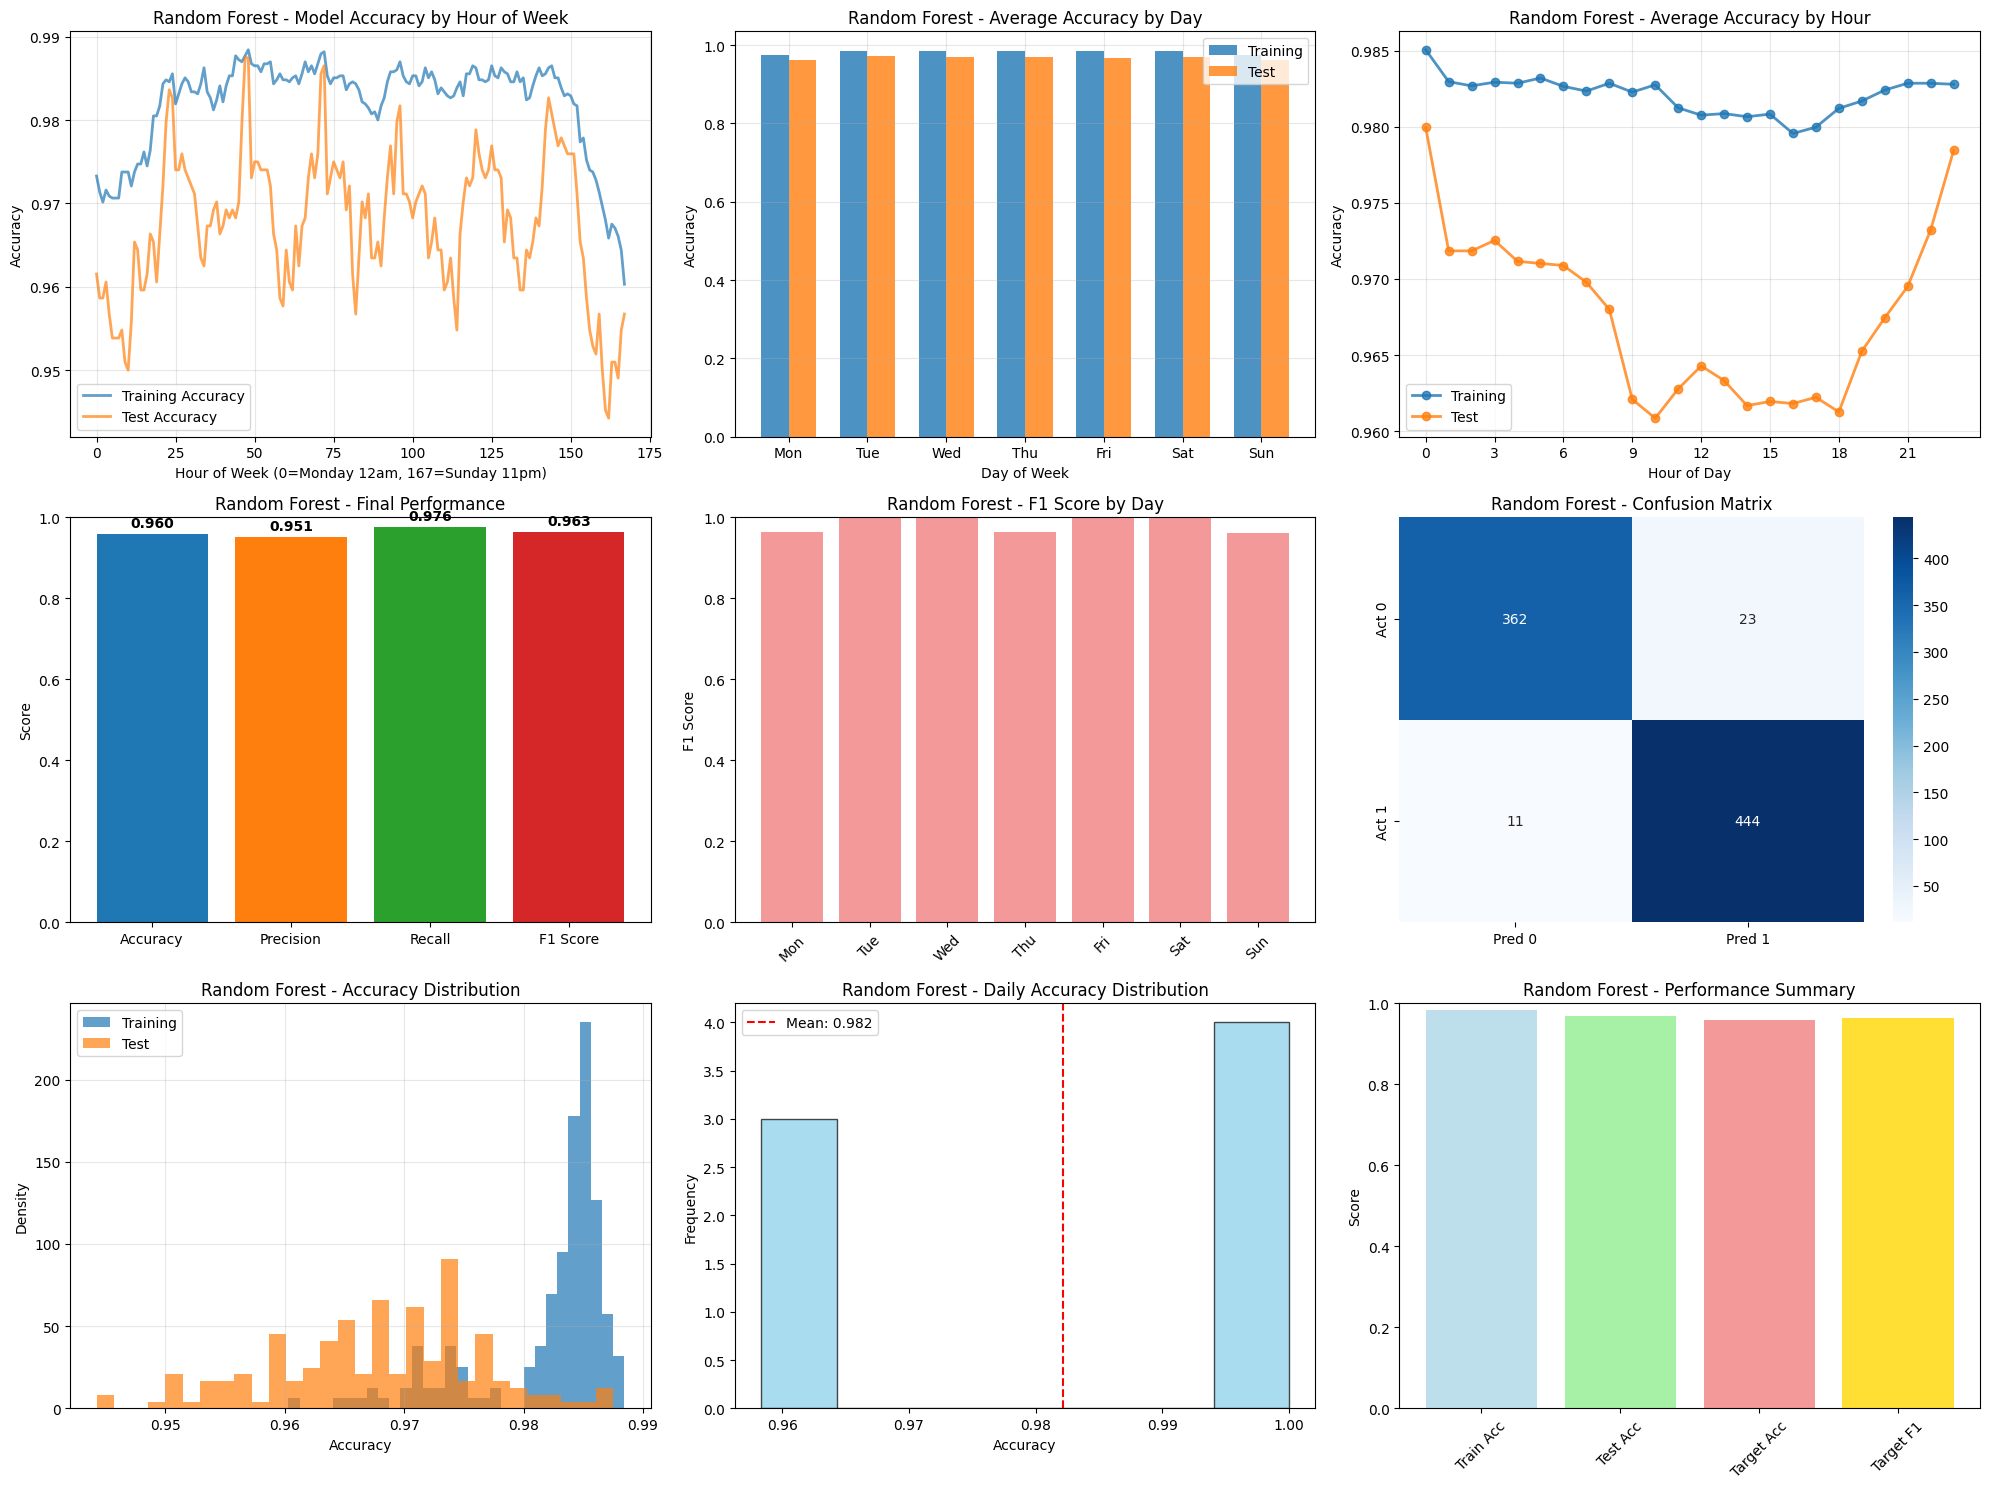


FINAL EVALUATION SUMMARY - RANDOM FOREST MODEL
Model Type: Random Forest (168 individual models)
Model Architecture: One RF per hour (168 total models)
Input Features: 168 (Timestamp features only)
Output: 168 binary predictions (7 days × 24 hours)
Training Method: Individual Random Forest per hour
Target User ID: 2ff2cf3f81bf3e3f8c3c486b648e217a

PERFORMANCE METRICS:
  • Overall Accuracy: 0.9595
  • Precision: 0.9507
  • Recall: 0.9758
  • F1 Score: 0.9631

TRAINING PERFORMANCE:
  • Average Training Accuracy: 0.9821 ± 0.0056
  • Average Test Accuracy: 0.9676 ± 0.0086
  • Best Performing Hour: 47 (accuracy: 0.9875)
  • Worst Performing Hour: 162 (accuracy: 0.9442)

DAILY PERFORMANCE:
  • Average Daily Accuracy: 0.9821
  • Average Daily F1 Score: 0.9837
  • Best Performing Day: Tuesday (F1: 1.0000)
  • Worst Performing Day: Sunday (F1: 0.9600)

CONFUSION MATRIX:
  True Negatives:     362    False Positives:     23
  False Negatives:     11    True Positives:     444

MODEL CHARACTERIST

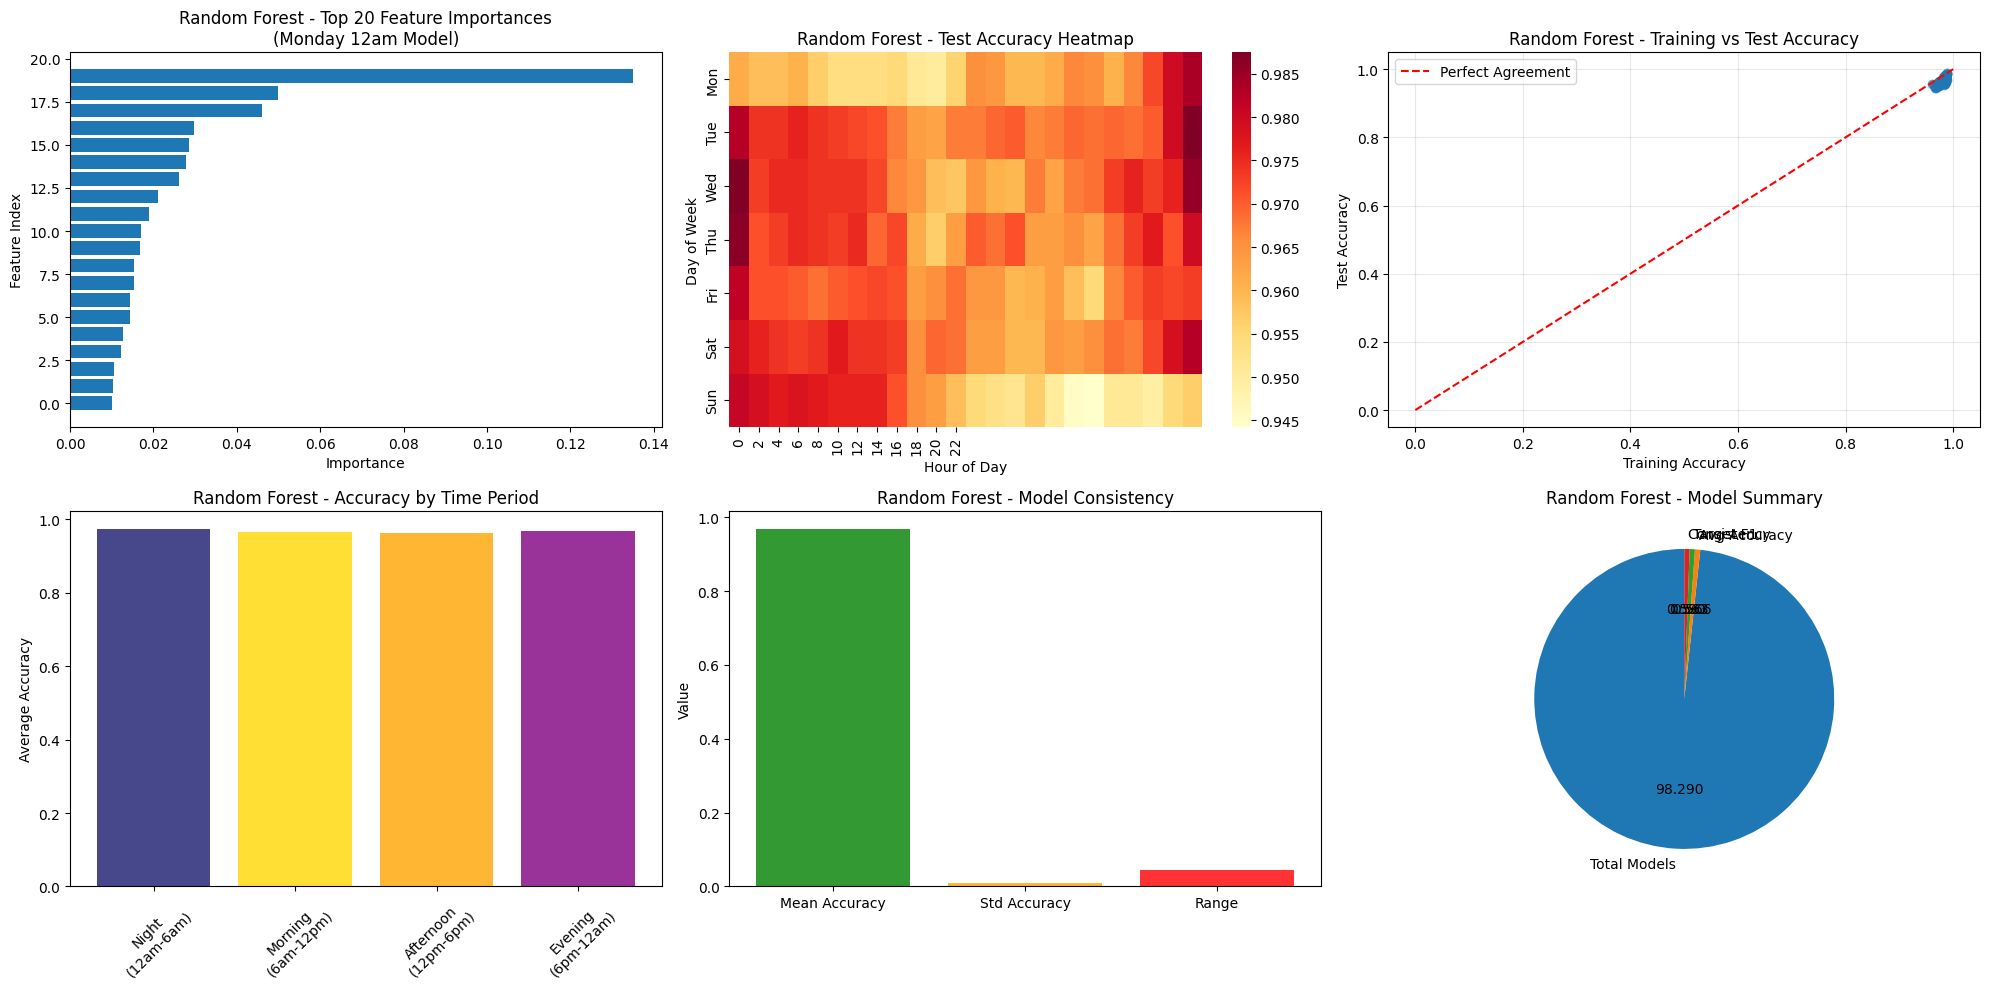

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_data(file_path):
    """
    Load the CSV file and preprocess the data for Random Forest training
    """
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Convert DATE column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Add day of week information
    df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
    df['WEEK_NUMBER'] = df['DATE'].dt.isocalendar().week
    df['YEAR'] = df['DATE'].dt.year
    df['WEEK_YEAR'] = df['YEAR'].astype(str) + '_' + df['WEEK_NUMBER'].astype(str)

    # Sort by USER_ID and DATE
    df = df.sort_values(['USER_ID', 'DATE']).reset_index(drop=True)

    # Extract hourly columns (12am through 11pm)
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    return df, hourly_columns

def select_consistent_users(data, target_user_id='2ff2cf3f81bf3e3f8c3c486b648e217a', max_users=1000):
    """
    Select consistent users including the target user
    """
    print(f"Total users in dataset: {data['USER_ID'].nunique()}")

    # Check if target user exists
    target_user_exists = target_user_id in data['USER_ID'].values
    print(f"Target user {target_user_id} exists in dataset: {target_user_exists}")

    # Select users with sufficient data
    valid_users = []

    # First, validate and add target user if it exists
    if target_user_exists:
        user_data = data[data['USER_ID'] == target_user_id]

        if len(user_data) > 0:
            # Check for weekly completeness
            user_weeks = user_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks
                valid_users.append(target_user_id)
                print(f"Target user {target_user_id} added - has {complete_weeks} complete weeks")
            else:
                print(f"Target user {target_user_id} has insufficient data - only {complete_weeks} complete weeks")
        else:
            print(f"Target user {target_user_id} has no data")

    # Now add other users (excluding target user to avoid duplicates)
    all_users = list(data['USER_ID'].unique())
    other_users = [user for user in all_users if user != target_user_id]

    for user_id in other_users:
        if len(valid_users) >= max_users:
            break

        user_data = data[data['USER_ID'] == user_id]

        if len(user_data) > 0:
            # Check for weekly completeness
            user_weeks = user_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks for training
                valid_users.append(user_id)

    print(f"Selected {len(valid_users)} users with sufficient data")
    print(f"Target user {target_user_id} is included: {target_user_id in valid_users}")
    print(f"First 10 selected users: {valid_users[:10]}")

    return valid_users

def create_weekly_sequences(data, selected_users, sequence_weeks=1):
    """
    Create weekly sequences from data for Random Forest training
    Input: sequence_weeks weeks to predict next week's pattern
    """
    sequences = []
    targets = []
    user_info = []

    # Days of week in order
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Hourly columns
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    print(f"Processing {len(selected_users)} selected users...")

    # Group by user to create sequences
    for idx, user_id in enumerate(selected_users):
        if idx % 100 == 0:
            print(f"Processing user {idx+1}/{len(selected_users)}: {user_id}")

        user_data = data[data['USER_ID'] == user_id].sort_values('DATE')

        # Group by week for this user
        weekly_data = {}
        for week_year in user_data['WEEK_YEAR'].unique():
            week_data = user_data[user_data['WEEK_YEAR'] == week_year]

            # Check if we have all 7 days for this week
            if len(week_data) == 7:
                # Sort by day of week to ensure Monday-Sunday order
                week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()

                # Check if we have data for all days (no NaN after reindexing)
                if not week_data[hourly_columns].isnull().any().any():
                    weekly_data[week_year] = week_data[hourly_columns].values  # Shape: (7, 24)

        # Create sequences from complete weeks
        week_keys = sorted(weekly_data.keys())

        for i in range(len(week_keys) - sequence_weeks):
            # Get input weeks (flatten them)
            input_weeks = []
            for j in range(sequence_weeks):
                week_data = weekly_data[week_keys[i + j]]  # Shape: (7, 24)
                input_weeks.append(week_data.flatten())  # Flatten to (168,)

            # Concatenate all input weeks
            sequence = np.concatenate(input_weeks)  # Shape: (sequence_weeks * 168,)

            # Get target week
            target_week = weekly_data[week_keys[i + sequence_weeks]]  # Shape: (7, 24)
            target = target_week.flatten()  # Flatten to (168,)

            sequences.append(sequence)
            targets.append(target)
            user_info.append({
                'user_id': user_id,
                'input_weeks': [week_keys[i + j] for j in range(sequence_weeks)],
                'target_week': week_keys[i + sequence_weeks]
            })

    return np.array(sequences), np.array(targets), user_info

def create_rf_models_weekly(output_dim=168):
    """
    Create Random Forest models for predicting full weekly patterns (Monday-Sunday, 12am-11pm)
    We'll create one model for each hour of the week (168 models total)
    """
    models = []

    for i in range(output_dim):
        # Create a Random Forest for each hour of the week
        rf = RandomForestClassifier(
            n_estimators=100,        # Increased for better performance
            max_depth=15,            # Increased for better learning
            min_samples_split=5,     # Minimum samples required to split
            min_samples_leaf=2,      # Minimum samples required at leaf
            max_features='sqrt',     # Number of features to consider at each split
            random_state=42,         # For reproducibility
            n_jobs=-1               # Use all available cores
        )
        models.append(rf)

    return models

def calculate_comprehensive_metrics(y_true, y_pred, y_pred_binary=None):
    """
    Calculate comprehensive evaluation metrics including F1, recall, precision, confusion matrix
    """
    if y_pred_binary is None:
        y_pred_binary = (y_pred > 0.5).astype(int)

    # Flatten arrays if they're multi-dimensional
    if len(y_true.shape) > 1:
        y_true_flat = y_true.flatten()
        y_pred_flat = y_pred.flatten()
        y_pred_binary_flat = y_pred_binary.flatten()
    else:
        y_true_flat = y_true
        y_pred_flat = y_pred
        y_pred_binary_flat = y_pred_binary

    # Calculate metrics
    accuracy = accuracy_score(y_true_flat, y_pred_binary_flat)
    precision = precision_score(y_true_flat, y_pred_binary_flat, average='binary', zero_division=0)
    recall = recall_score(y_true_flat, y_pred_binary_flat, average='binary', zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_binary_flat, average='binary', zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_binary_flat)

    # Classification report
    class_report = classification_report(y_true_flat, y_pred_binary_flat, output_dict=True, zero_division=0)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'classification_report': class_report
    }

    return metrics

def predict_weekly_pattern(models, scaler, input_week):
    """
    Predict weekly pattern using trained Random Forest models
    """
    # Scale input
    input_scaled = scaler.transform(input_week.reshape(1, -1))

    # Get predictions from all models
    predictions = []
    prediction_probabilities = []

    for model in models:
        pred = model.predict(input_scaled)[0]
        pred_proba = model.predict_proba(input_scaled)[0]

        predictions.append(pred)
        # Get probability of class 1 (notification)
        if len(pred_proba) > 1:
            prediction_probabilities.append(pred_proba[1])
        else:
            prediction_probabilities.append(pred_proba[0] if pred == 1 else 1 - pred_proba[0])

    return np.array(predictions), np.array(prediction_probabilities)

def evaluate_model_comprehensive(models, X_test, y_test, scaler=None, verbose=True):
    """
    Comprehensive model evaluation with all metrics for Random Forest
    """
    if scaler is not None:
        X_test_scaled = scaler.transform(X_test)
    else:
        X_test_scaled = X_test

    # Get predictions from all models
    all_predictions = []
    all_probabilities = []

    for i, model in enumerate(models):
        pred = model.predict(X_test_scaled)
        pred_proba = model.predict_proba(X_test_scaled)

        all_predictions.append(pred)
        # Get probability of class 1 for each prediction
        if pred_proba.shape[1] > 1:
            all_probabilities.append(pred_proba[:, 1])
        else:
            all_probabilities.append(pred_proba[:, 0])

    # Reshape predictions to match target format
    y_pred_binary = np.array(all_predictions).T  # Shape: (n_samples, 168)
    y_pred_proba = np.array(all_probabilities).T  # Shape: (n_samples, 168)

    # Calculate comprehensive metrics
    metrics = calculate_comprehensive_metrics(y_test, y_pred_proba, y_pred_binary)

    if verbose:
        print("=" * 60)
        print("COMPREHENSIVE RANDOM FOREST EVALUATION RESULTS")
        print("=" * 60)
        print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1_score']:.4f}")
        print()

        print("Confusion Matrix:")
        print(metrics['confusion_matrix'])
        print()

        print("Classification Report:")
        for class_name, class_metrics in metrics['classification_report'].items():
            if isinstance(class_metrics, dict):
                print(f"{class_name}: Precision={class_metrics['precision']:.4f}, "
                      f"Recall={class_metrics['recall']:.4f}, F1={class_metrics['f1-score']:.4f}")

    return metrics, y_pred_proba, y_pred_binary

def quick_test_weekly_model_with_metrics(models, df, hourly_columns, scaler, sequence_weeks=1):
    """
    Enhanced quick test with comprehensive metrics for the target user
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    print(f"\nTesting specifically with target user: {TARGET_USER_ID}")

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in data")
        return None, None

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')
    print(f"User has {len(user_data)} records")

    weekly_data = {}
    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

    week_keys = sorted(weekly_data.keys())
    print(f"User has {len(week_keys)} complete weeks: {week_keys}")

    if len(week_keys) < 2:
        print("Insufficient complete weeks for testing")
        return None, None

    # Collect all available predictions for comprehensive evaluation
    all_predictions = []
    all_actuals = []
    all_predictions_binary = []

    # Test on multiple weeks if available
    test_weeks = min(len(week_keys) - 1, 5)  # Test up to 5 weeks

    for i in range(test_weeks):
        input_week = weekly_data[week_keys[i]].flatten()
        actual_next_week = weekly_data[week_keys[i + 1]].flatten()

        # Get predictions
        predicted_binary, prediction_probabilities = predict_weekly_pattern(models, scaler, input_week)

        all_predictions.extend(prediction_probabilities)
        all_actuals.extend(actual_next_week)
        all_predictions_binary.extend(predicted_binary)

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_actuals = np.array(all_actuals)
    all_predictions_binary = np.array(all_predictions_binary)

    # Calculate comprehensive metrics
    metrics = calculate_comprehensive_metrics(all_actuals, all_predictions, all_predictions_binary)

    print(f"\nCOMPREHENSIVE EVALUATION RESULTS for Target User {TARGET_USER_ID}:")
    print(f"Tested on {test_weeks} week predictions")
    print("=" * 50)
    print(f"Overall Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print()

    print("Confusion Matrix:")
    print("                 Predicted")
    print("                 0      1")
    print(f"Actual    0   {metrics['confusion_matrix'][0][0]:6d} {metrics['confusion_matrix'][0][1]:6d}")
    print(f"          1   {metrics['confusion_matrix'][1][0]:6d} {metrics['confusion_matrix'][1][1]:6d}")
    print()

    # Day-by-day analysis for the first prediction
    print("Day-by-day accuracy for first prediction:")
    input_week = weekly_data[week_keys[0]].flatten()
    actual_next_week = weekly_data[week_keys[1]].flatten()
    predicted_binary, prediction_probabilities = predict_weekly_pattern(models, scaler, input_week)

    daily_metrics = []
    for day_idx, day in enumerate(days_order):
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        day_actual = actual_next_week[start_idx:end_idx]
        day_predicted = predicted_binary[start_idx:end_idx]

        day_accuracy = accuracy_score(day_actual, day_predicted)
        day_f1 = f1_score(day_actual, day_predicted, average='binary', zero_division=0)
        day_recall = recall_score(day_actual, day_predicted, average='binary', zero_division=0)
        day_precision = precision_score(day_actual, day_predicted, average='binary', zero_division=0)

        daily_metrics.append({
            'day': day,
            'accuracy': day_accuracy,
            'f1': day_f1,
            'recall': day_recall,
            'precision': day_precision
        })

        print(f"{day}: Acc={day_accuracy:.3f}, F1={day_f1:.3f}, Recall={day_recall:.3f}, Prec={day_precision:.3f}")

    # Detailed comparison for first 7 days
    print(f"\nDetailed comparison for first 7 days (Input: {week_keys[0]} -> Target: {week_keys[1]}):")
    for day_idx in range(7):
        day = days_order[day_idx]
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        day_actual = actual_next_week[start_idx:end_idx]
        day_predicted = predicted_binary[start_idx:end_idx]
        day_probs = prediction_probabilities[start_idx:end_idx]

        print(f"{day}:")
        print(f"  Actual:    {day_actual}")
        print(f"  Predicted: {day_predicted}")
        print(f"  Prob scores (first 12h): {day_probs[:12].round(3)}")
        print()

    return metrics, daily_metrics

def visualize_comprehensive_results(metrics, daily_metrics=None):
    """
    Create comprehensive visualizations of the evaluation results
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Confusion Matrix Heatmap
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'], ax=axes[0,0])
    axes[0,0].set_title('Random Forest - Confusion Matrix')

    # 2. Metrics Bar Chart
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    metric_values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']]

    bars = axes[0,1].bar(metric_names, metric_values, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
    axes[0,1].set_title('Random Forest - Overall Performance Metrics')
    axes[0,1].set_ylabel('Score')
    axes[0,1].set_ylim(0, 1)

    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                      f'{value:.3f}', ha='center', va='bottom')

    # 3. Daily Metrics (if available)
    if daily_metrics:
        days = [dm['day'][:3] for dm in daily_metrics]  # Abbreviated day names
        daily_acc = [dm['accuracy'] for dm in daily_metrics]
        daily_f1 = [dm['f1'] for dm in daily_metrics]

        x = np.arange(len(days))
        width = 0.35

        axes[1,0].bar(x - width/2, daily_acc, width, label='Accuracy', alpha=0.8)
        axes[1,0].bar(x + width/2, daily_f1, width, label='F1 Score', alpha=0.8)
        axes[1,0].set_xlabel('Day of Week')
        axes[1,0].set_ylabel('Score')
        axes[1,0].set_title('Random Forest - Daily Performance Metrics')
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels(days)
        axes[1,0].legend()
        axes[1,0].set_ylim(0, 1)

    # 4. Classification Report Visualization
    if 'classification_report' in metrics:
        class_report = metrics['classification_report']
        metrics_df = pd.DataFrame({
            'Precision': [class_report['0']['precision'], class_report['1']['precision']],
            'Recall': [class_report['0']['recall'], class_report['1']['recall']],
            'F1-Score': [class_report['0']['f1-score'], class_report['1']['f1-score']]
        }, index=['Class 0 (No Activity)', 'Class 1 (Activity)'])

        metrics_df.plot(kind='bar', ax=axes[1,1], rot=45)
        axes[1,1].set_title('Random Forest - Per-Class Performance')
        axes[1,1].set_ylabel('Score')
        axes[1,1].legend()
        axes[1,1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

def visualize_weekly_prediction_enhanced(models, df, hourly_columns, scaler):
    """
    Create enhanced visualization of weekly prediction vs actual for target user
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in data")
        return

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')

    weekly_data = {}
    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

    if len(weekly_data) < 2:
        print("Insufficient data for visualization")
        return

    # Get prediction
    week_keys = sorted(weekly_data.keys())
    input_week = weekly_data[week_keys[0]].flatten()
    actual_next_week = weekly_data[week_keys[1]]

    predicted_binary, prediction_probabilities = predict_weekly_pattern(models, scaler, input_week)
    predicted_week = predicted_binary.reshape(7, 24)
    predicted_probs_week = prediction_probabilities.reshape(7, 24)

    # Create enhanced visualization
    fig, axes = plt.subplots(4, 1, figsize=(15, 20))

    # Actual pattern
    im1 = axes[0].imshow(actual_next_week, cmap='Blues', aspect='auto')
    axes[0].set_title(f'Actual Weekly Pattern - {week_keys[1]} (User: {TARGET_USER_ID})')
    axes[0].set_ylabel('Day of Week')
    axes[0].set_yticks(range(7))
    axes[0].set_yticklabels(days_order)
    axes[0].set_xticks(range(0, 24, 2))
    axes[0].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)
    plt.colorbar(im1, ax=axes[0])

    # Predicted pattern (binary)
    im2 = axes[1].imshow(predicted_week, cmap='Blues', aspect='auto')
    axes[1].set_title(f'Random Forest Predicted Pattern (Binary)')
    axes[1].set_ylabel('Day of Week')
    axes[1].set_yticks(range(7))
    axes[1].set_yticklabels(days_order)
    axes[1].set_xticks(range(0, 24, 2))
    axes[1].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)
    plt.colorbar(im2, ax=axes[1])

    # Predicted probabilities
    im3 = axes[2].imshow(predicted_probs_week, cmap='Blues', aspect='auto')
    axes[2].set_title(f'Random Forest Predicted Probabilities')
    axes[2].set_ylabel('Day of Week')
    axes[2].set_yticks(range(7))
    axes[2].set_yticklabels(days_order)
    axes[2].set_xticks(range(0, 24, 2))
    axes[2].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)
    plt.colorbar(im3, ax=axes[2])

    # Difference heatmap
    difference = actual_next_week - predicted_week
    im4 = axes[3].imshow(difference, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
    axes[3].set_title('Difference (Actual - Predicted)')
    axes[3].set_ylabel('Day of Week')
    axes[3].set_xlabel('Hour of Day')
    axes[3].set_yticks(range(7))
    axes[3].set_yticklabels(days_order)
    axes[3].set_xticks(range(0, 24, 2))
    axes[3].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)
    plt.colorbar(im4, ax=axes[3])

    plt.tight_layout()
    plt.show()

    # Calculate and display metrics for this specific prediction
    actual_flat = actual_next_week.flatten()
    predicted_flat = predicted_week.flatten()
    predicted_binary_flat = predicted_flat.astype(int)

    metrics = calculate_comprehensive_metrics(actual_flat, predicted_probs_week.flatten(), predicted_binary_flat)

    print(f"\nMetrics for this specific prediction:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")

def train_weekly_model():
    """
    Train the Random Forest models on weekly patterns with comprehensive evaluation
    """
    # Configuration
    FILE_PATH = '/content/drive/MyDrive/3M-timestamp.csv'
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    SEQUENCE_WEEKS = 1  # Use 1 week to predict next week
    MAX_USERS = 1000

    print("Loading and preprocessing data...")
    df, hourly_columns = load_and_preprocess_data(FILE_PATH)

    print(f"Data shape: {df.shape}")
    print(f"Number of unique users: {df['USER_ID'].nunique()}")
    print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")
    print(f"Unique weeks: {df['WEEK_YEAR'].nunique()}")

    # Select consistent users including target user
    print(f"\nSelecting up to {MAX_USERS} users including target user {TARGET_USER_ID}...")
    selected_users = select_consistent_users(df, TARGET_USER_ID, MAX_USERS)

    if len(selected_users) == 0:
        print("No users with sufficient data found!")
        return None, None, None, None, None

    # Create weekly sequences
    print("Creating weekly sequences...")
    X, y, user_info = create_weekly_sequences(df, selected_users, SEQUENCE_WEEKS)

    print(f"Total weekly sequences: {len(X)}")
    print(f"Input sequence shape: {X.shape}")  # Should be (n_samples, 168) for 1 week
    print(f"Target shape: {y.shape}")          # Should be (n_samples, 168) for 1 week

    if len(X) == 0:
        print("No complete weekly sequences found! Check your data.")
        return None, None, None, None, None

    # Split data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize the input features (Random Forest doesn't require this but can help)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create Random Forest models
    print("Creating Random Forest models for weekly prediction...")
    models = create_rf_models_weekly(output_dim=168)

    print(f"Created {len(models)} Random Forest models (one for each hour of the week)")

    # Train the models
    print("Training Random Forest models on weekly patterns...")
    trained_models = []
    training_scores = []
    validation_scores = []

    for i, model in enumerate(models):
        if i % 24 == 0:  # Print progress every 24 hours (1 day)
            day = i // 24
            days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            print(f"Training models for {days[day]}...")

        # Train model for this specific hour
        model.fit(X_train_scaled, y_train[:, i])

        # Calculate training and validation accuracy on individual hourly predictions
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)

        train_acc = accuracy_score(y_train[:, i], train_pred)
        test_acc = accuracy_score(y_test[:, i], test_pred)

        training_scores.append(train_acc)
        validation_scores.append(test_acc)

        trained_models.append(model)

    print(f"Training completed!")
    print(f"Average training accuracy: {np.mean(training_scores):.3f}")
    print(f"Average test accuracy: {np.mean(validation_scores):.3f}")

    # Comprehensive evaluation on test set
    print("\n" + "="*60)
    print("COMPREHENSIVE RANDOM FOREST EVALUATION ON TEST SET")
    print("="*60)

    test_metrics, y_pred_proba, y_pred_binary = evaluate_model_comprehensive(
        trained_models, X_test, y_test, scaler, verbose=True
    )

    # Save the models and scaler
    joblib.dump(trained_models, f'notification_rf_weekly_models_{TARGET_USER_ID}.pkl')
    joblib.dump(scaler, f'notification_rf_scaler_{TARGET_USER_ID}.pkl')
    print(f"\nModels saved as 'notification_rf_weekly_models_{TARGET_USER_ID}.pkl'")
    print(f"Scaler saved as 'notification_rf_scaler_{TARGET_USER_ID}.pkl'")

    # Save additional info
    model_info = {
        'user_id': TARGET_USER_ID,
        'hourly_columns': hourly_columns,
        'sequence_weeks': SEQUENCE_WEEKS,
        'user_info': user_info,
        'training_scores': training_scores,
        'validation_scores': validation_scores,
        'scaler_mean': scaler.mean_,
        'scaler_scale': scaler.scale_,
        'selected_users': selected_users,
        'target_user_id': TARGET_USER_ID,
        'test_metrics': test_metrics
    }
    np.save(f'weekly_rf_model_info_{TARGET_USER_ID}.npy', model_info, allow_pickle=True)

    return trained_models, (training_scores, validation_scores), df, hourly_columns, scaler

def create_detailed_evaluation_report(models, df, hourly_columns, scaler):
    """
    Create a detailed evaluation report with multiple test cases
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'

    print("=" * 80)
    print("DETAILED EVALUATION REPORT - RANDOM FOREST MODEL")
    print("=" * 80)

    # Test on target user with comprehensive metrics
    target_metrics, daily_metrics = quick_test_weekly_model_with_metrics(
        models, df, hourly_columns, scaler
    )

    if target_metrics is None:
        print("Could not generate evaluation report - insufficient target user data")
        return None, None

    # Create visualizations
    print("\nGenerating comprehensive visualizations...")
    visualize_comprehensive_results(target_metrics, daily_metrics)

    # Weekly pattern visualization
    print("\nGenerating weekly pattern visualization...")
    visualize_weekly_prediction_enhanced(models, df, hourly_columns, scaler)

    return target_metrics, daily_metrics

if __name__ == "__main__":
    # Train the weekly Random Forest model with comprehensive evaluation
    models, scores, df, hourly_columns, scaler = train_weekly_model()

    if models is not None:
        # Create detailed evaluation report
        target_metrics, daily_metrics = create_detailed_evaluation_report(
            models, df, hourly_columns, scaler
        )

        if target_metrics is not None:
            # Plot comprehensive training results
            training_scores, validation_scores = scores

            plt.figure(figsize=(20, 15))

            # Overall accuracy by hour of week
            plt.subplot(3, 3, 1)
            hours = range(168)
            plt.plot(hours, training_scores, label='Training Accuracy', alpha=0.7, linewidth=2)
            plt.plot(hours, validation_scores, label='Test Accuracy', alpha=0.7, linewidth=2)
            plt.title(f'Random Forest - Model Accuracy by Hour of Week')
            plt.xlabel('Hour of Week (0=Monday 12am, 167=Sunday 11pm)')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Daily average accuracy
            plt.subplot(3, 3, 2)
            days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
            daily_train_acc = [np.mean(training_scores[i*24:(i+1)*24]) for i in range(7)]
            daily_val_acc = [np.mean(validation_scores[i*24:(i+1)*24]) for i in range(7)]

            x = np.arange(len(days))
            width = 0.35
            plt.bar(x - width/2, daily_train_acc, width, label='Training', alpha=0.8)
            plt.bar(x + width/2, daily_val_acc, width, label='Test', alpha=0.8)
            plt.title('Random Forest - Average Accuracy by Day')
            plt.xlabel('Day of Week')
            plt.ylabel('Accuracy')
            plt.xticks(x, days)
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Hourly average accuracy (0-23 hours)
            plt.subplot(3, 3, 3)
            hourly_train_acc = []
            hourly_val_acc = []
            for hour in range(24):
                hour_indices = [hour + day*24 for day in range(7)]
                hourly_train_acc.append(np.mean([training_scores[i] for i in hour_indices]))
                hourly_val_acc.append(np.mean([validation_scores[i] for i in hour_indices]))

            plt.plot(range(24), hourly_train_acc, 'o-', label='Training', alpha=0.8, linewidth=2)
            plt.plot(range(24), hourly_val_acc, 'o-', label='Test', alpha=0.8, linewidth=2)
            plt.title('Random Forest - Average Accuracy by Hour')
            plt.xlabel('Hour of Day')
            plt.ylabel('Accuracy')
            plt.xticks(range(0, 24, 3))
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Final metrics summary
            plt.subplot(3, 3, 4)
            final_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
            final_values = [
                target_metrics['accuracy'],
                target_metrics['precision'],
                target_metrics['recall'],
                target_metrics['f1_score']
            ]
            bars = plt.bar(final_metrics, final_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
            plt.title('Random Forest - Final Performance')
            plt.ylabel('Score')
            plt.ylim(0, 1)
            for bar, value in zip(bars, final_values):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

            # Daily performance
            if daily_metrics:
                plt.subplot(3, 3, 5)
                days = [dm['day'][:3] for dm in daily_metrics]
                daily_f1 = [dm['f1'] for dm in daily_metrics]
                plt.bar(days, daily_f1, color='lightcoral', alpha=0.8)
                plt.title('Random Forest - F1 Score by Day')
                plt.ylabel('F1 Score')
                plt.ylim(0, 1)
                plt.xticks(rotation=45)

            # Confusion matrix visualization
            plt.subplot(3, 3, 6)
            cm = target_metrics['confusion_matrix']
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Pred 0', 'Pred 1'],
                       yticklabels=['Act 0', 'Act 1'])
            plt.title('Random Forest - Confusion Matrix')

            # Distribution of accuracies
            plt.subplot(3, 3, 7)
            plt.hist(training_scores, bins=30, alpha=0.7, label='Training', density=True)
            plt.hist(validation_scores, bins=30, alpha=0.7, label='Test', density=True)
            plt.title('Random Forest - Accuracy Distribution')
            plt.xlabel('Accuracy')
            plt.ylabel('Density')
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Performance distribution
            plt.subplot(3, 3, 8)
            if daily_metrics:
                daily_accuracies = [dm['accuracy'] for dm in daily_metrics]
                plt.hist(daily_accuracies, bins=7, alpha=0.7, color='skyblue', edgecolor='black')
                plt.title('Random Forest - Daily Accuracy Distribution')
                plt.xlabel('Accuracy')
                plt.ylabel('Frequency')
                plt.axvline(np.mean(daily_accuracies), color='red', linestyle='--',
                           label=f'Mean: {np.mean(daily_accuracies):.3f}')
                plt.legend()

            # Model complexity comparison
            plt.subplot(3, 3, 9)
            performance_comparison = [
                np.mean(training_scores),
                np.mean(validation_scores),
                target_metrics['accuracy'],
                target_metrics['f1_score']
            ]
            labels = ['Train Acc', 'Test Acc', 'Target Acc', 'Target F1']
            colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']
            plt.bar(labels, performance_comparison, color=colors, alpha=0.8)
            plt.title('Random Forest - Performance Summary')
            plt.ylabel('Score')
            plt.ylim(0, 1)
            plt.xticks(rotation=45)

            plt.tight_layout()
            plt.show()

            # Print comprehensive summary
            print("\n" + "=" * 80)
            print("FINAL EVALUATION SUMMARY - RANDOM FOREST MODEL")
            print("=" * 80)
            print(f"Model Type: Random Forest (168 individual models)")
            print(f"Model Architecture: One RF per hour (168 total models)")
            print(f"Input Features: {scaler.mean_.shape[0]} (Timestamp features only)")
            print(f"Output: 168 binary predictions (7 days × 24 hours)")
            print(f"Training Method: Individual Random Forest per hour")
            print(f"Target User ID: 2ff2cf3f81bf3e3f8c3c486b648e217a")
            print()
            print("PERFORMANCE METRICS:")
            print(f"  • Overall Accuracy: {target_metrics['accuracy']:.4f}")
            print(f"  • Precision: {target_metrics['precision']:.4f}")
            print(f"  • Recall: {target_metrics['recall']:.4f}")
            print(f"  • F1 Score: {target_metrics['f1_score']:.4f}")
            print()
            print("TRAINING PERFORMANCE:")
            print(f"  • Average Training Accuracy: {np.mean(training_scores):.4f} ± {np.std(training_scores):.4f}")
            print(f"  • Average Test Accuracy: {np.mean(validation_scores):.4f} ± {np.std(validation_scores):.4f}")
            print(f"  • Best Performing Hour: {np.argmax(validation_scores)} (accuracy: {np.max(validation_scores):.4f})")
            print(f"  • Worst Performing Hour: {np.argmin(validation_scores)} (accuracy: {np.min(validation_scores):.4f})")
            print()
            if daily_metrics:
                avg_daily_acc = np.mean([dm['accuracy'] for dm in daily_metrics])
                avg_daily_f1 = np.mean([dm['f1'] for dm in daily_metrics])
                print("DAILY PERFORMANCE:")
                print(f"  • Average Daily Accuracy: {avg_daily_acc:.4f}")
                print(f"  • Average Daily F1 Score: {avg_daily_f1:.4f}")
                print(f"  • Best Performing Day: {max(daily_metrics, key=lambda x: x['f1'])['day']} (F1: {max(daily_metrics, key=lambda x: x['f1'])['f1']:.4f})")
                print(f"  • Worst Performing Day: {min(daily_metrics, key=lambda x: x['f1'])['day']} (F1: {min(daily_metrics, key=lambda x: x['f1'])['f1']:.4f})")
            print()
            print("CONFUSION MATRIX:")
            cm = target_metrics['confusion_matrix']
            print(f"  True Negatives:  {cm[0][0]:6d}    False Positives: {cm[0][1]:6d}")
            print(f"  False Negatives: {cm[1][0]:6d}    True Positives:  {cm[1][1]:6d}")
            print()
            print("MODEL CHARACTERISTICS:")
            print(f"  • Type: Random Forest Ensemble (168 individual models)")
            print(f"  • Trees per model: 100")
            print(f"  • Max depth: 15")
            print(f"  • Features per split: sqrt(n_features)")
            print(f"  • Input: Weekly timestamp patterns only")
            print(f"  • Advantage: Handles non-linear patterns, feature importance")
            print("=" * 80)

            # Additional detailed plots
            plt.figure(figsize=(20, 10))

            # Feature importance analysis (for first few models)
            plt.subplot(2, 3, 1)
            # Get feature importance from first model (Monday 12am)
            feature_importance = models[0].feature_importances_
            top_features = np.argsort(feature_importance)[-20:]  # Top 20 features
            plt.barh(range(len(top_features)), feature_importance[top_features])
            plt.title('Random Forest - Top 20 Feature Importances\n(Monday 12am Model)')
            plt.xlabel('Importance')
            plt.ylabel('Feature Index')

            # Accuracy heatmap by day and hour
            plt.subplot(2, 3, 2)
            acc_matrix = np.array(validation_scores).reshape(7, 24)
            sns.heatmap(acc_matrix, annot=False, cmap='YlOrRd',
                       xticklabels=range(0, 24, 2),
                       yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
            plt.title('Random Forest - Test Accuracy Heatmap')
            plt.xlabel('Hour of Day')
            plt.ylabel('Day of Week')

            # Training vs Test accuracy scatter
            plt.subplot(2, 3, 3)
            plt.scatter(training_scores, validation_scores, alpha=0.6)
            plt.plot([0, 1], [0, 1], 'r--', label='Perfect Agreement')
            plt.xlabel('Training Accuracy')
            plt.ylabel('Test Accuracy')
            plt.title('Random Forest - Training vs Test Accuracy')
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Performance by time periods
            plt.subplot(2, 3, 4)
            morning_acc = np.mean(validation_scores[6:12] + validation_scores[30:36] +
                                validation_scores[54:60] + validation_scores[78:84] +
                                validation_scores[102:108] + validation_scores[126:132] +
                                validation_scores[150:156])  # 6am-12pm all days
            afternoon_acc = np.mean(validation_scores[12:18] + validation_scores[36:42] +
                                  validation_scores[60:66] + validation_scores[84:90] +
                                  validation_scores[108:114] + validation_scores[132:138] +
                                  validation_scores[156:162])  # 12pm-6pm all days
            evening_acc = np.mean(validation_scores[18:24] + validation_scores[42:48] +
                                validation_scores[66:72] + validation_scores[90:96] +
                                validation_scores[114:120] + validation_scores[138:144] +
                                validation_scores[162:168])  # 6pm-12am all days
            night_acc = np.mean(validation_scores[0:6] + validation_scores[24:30] +
                              validation_scores[48:54] + validation_scores[72:78] +
                              validation_scores[96:102] + validation_scores[120:126] +
                              validation_scores[144:150])  # 12am-6am all days

            periods = ['Night\n(12am-6am)', 'Morning\n(6am-12pm)', 'Afternoon\n(12pm-6pm)', 'Evening\n(6pm-12am)']
            period_accs = [night_acc, morning_acc, afternoon_acc, evening_acc]
            plt.bar(periods, period_accs, color=['midnightblue', 'gold', 'orange', 'purple'], alpha=0.8)
            plt.title('Random Forest - Accuracy by Time Period')
            plt.ylabel('Average Accuracy')
            plt.xticks(rotation=45)

            # Model performance consistency
            plt.subplot(2, 3, 5)
            accuracy_std = np.std(validation_scores)
            accuracy_range = np.max(validation_scores) - np.min(validation_scores)
            consistency_metrics = ['Mean Accuracy', 'Std Accuracy', 'Range']
            consistency_values = [np.mean(validation_scores), accuracy_std, accuracy_range]
            colors = ['green', 'orange', 'red']
            plt.bar(consistency_metrics, consistency_values, color=colors, alpha=0.8)
            plt.title('Random Forest - Model Consistency')
            plt.ylabel('Value')

            # Comparison summary
            plt.subplot(2, 3, 6)
            model_summary = {
                'Total Models': len(models),
                'Avg Accuracy': np.mean(validation_scores),
                'Target F1': target_metrics['f1_score'],
                'Consistency': 1 - accuracy_std  # Higher is better
            }

            plt.pie(model_summary.values(), labels=model_summary.keys(), autopct='%1.3f', startangle=90)
            plt.title('Random Forest - Model Summary')

            plt.tight_layout()
            plt.show()

        else:
            print("Could not create evaluation report due to insufficient target user data")
    else:
        print("Training failed. Please check your data format and completeness.")

### **Random Forest (Raw data + weighted prob)**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_data(file_path, probability_file_path):
    """
    Load the CSV file and preprocess the data for Random Forest training
    Now also loads probability data to enhance features
    """
    # Read the timestamp CSV file
    df = pd.read_csv(file_path)

    # Read the probability CSV file
    prob_df = pd.read_csv(probability_file_path)

    # Convert DATE column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Add day of week information
    df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
    df['WEEK_NUMBER'] = df['DATE'].dt.isocalendar().week
    df['YEAR'] = df['DATE'].dt.year
    df['WEEK_YEAR'] = df['YEAR'].astype(str) + '_' + df['WEEK_NUMBER'].astype(str)

    # Sort by USER_ID and DATE
    df = df.sort_values(['USER_ID', 'DATE']).reset_index(drop=True)

    # Extract hourly columns (12am through 11pm)
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    return df, prob_df, hourly_columns

def select_consistent_users(data, prob_data, target_user_id='2ff2cf3f81bf3e3f8c3c486b648e217a', max_users=1000):
    """
    Select consistent users from both datasets, ensuring target user is included
    """
    # Get common users between both datasets
    timestamp_users = set(data['USER_ID'].unique())
    prob_users = set(prob_data['USER_ID'].unique())
    common_users = list(timestamp_users.intersection(prob_users))

    print(f"Total common users between datasets: {len(common_users)}")

    # Sort for consistent ordering
    common_users.sort()

    # Check if target user exists in common users
    target_user_exists = target_user_id in common_users
    print(f"Target user {target_user_id} exists in both datasets: {target_user_exists}")

    # Select users with sufficient data
    valid_users = []

    # First, validate and add target user if it exists
    if target_user_exists:
        user_timestamp_data = data[data['USER_ID'] == target_user_id]
        user_prob_data = prob_data[prob_data['USER_ID'] == target_user_id]

        # Check if target user has sufficient data
        if len(user_timestamp_data) > 0 and len(user_prob_data) > 0:
            # Check for weekly completeness
            user_weeks = user_timestamp_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks
                valid_users.append(target_user_id)
                print(f"Target user {target_user_id} added - has {complete_weeks} complete weeks")
            else:
                print(f"Target user {target_user_id} has insufficient data - only {complete_weeks} complete weeks")
        else:
            print(f"Target user {target_user_id} has no data in one or both datasets")

    # Now add other users (excluding target user to avoid duplicates)
    other_users = [user for user in common_users if user != target_user_id]

    for user_id in other_users:
        if len(valid_users) >= max_users:
            break

        user_timestamp_data = data[data['USER_ID'] == user_id]
        user_prob_data = prob_data[prob_data['USER_ID'] == user_id]

        if len(user_timestamp_data) > 0 and len(user_prob_data) > 0:
            # Check for weekly completeness
            user_weeks = user_timestamp_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks for training
                valid_users.append(user_id)

    print(f"Selected {len(valid_users)} users with sufficient data in both datasets")
    print(f"Target user {target_user_id} is included: {target_user_id in valid_users}")
    print(f"First 10 selected users: {valid_users[:10]}")

    return valid_users

def create_weekly_sequences_with_probabilities(data, prob_data, selected_users, sequence_weeks=1):
    """
    Create weekly sequences from data for Random Forest training
    Enhanced with probability features from the second dataset
    Input: sequence_weeks weeks to predict next week's pattern
    """
    sequences = []
    targets = []
    user_info = []

    # Days of week in order
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Hourly columns
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    print(f"Processing {len(selected_users)} selected users...")

    # Group by user to create sequences
    for idx, user_id in enumerate(selected_users):
        if idx % 100 == 0:
            print(f"Processing user {idx+1}/{len(selected_users)}: {user_id}")

        user_data = data[data['USER_ID'] == user_id].sort_values('DATE')
        user_prob_data = prob_data[prob_data['USER_ID'] == user_id]

        # Create probability lookup for this user
        prob_lookup = {}
        for _, row in user_prob_data.iterrows():
            prob_lookup[row['Timestamp']] = {
                'weighted_prob_0': row['Weighted_Prob_0'],
                'weighted_prob_1': row['Weighted_Prob_1']
            }

        # Group by week for this user
        weekly_data = {}
        weekly_prob_features = {}

        for week_year in user_data['WEEK_YEAR'].unique():
            week_data = user_data[user_data['WEEK_YEAR'] == week_year]

            # Check if we have all 7 days for this week
            if len(week_data) == 7:
                # Sort by day of week to ensure Monday-Sunday order
                week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()

                # Check if we have data for all days (no NaN after reindexing)
                if not week_data[hourly_columns].isnull().any().any():
                    weekly_data[week_year] = week_data[hourly_columns].values  # Shape: (7, 24)

                    # Create probability features for this week
                    week_prob_features = []
                    for day_idx in range(7):
                        day_probs = []
                        for hour_col in hourly_columns:
                            if hour_col in prob_lookup:
                                day_probs.extend([
                                    prob_lookup[hour_col]['weighted_prob_0'],
                                    prob_lookup[hour_col]['weighted_prob_1']
                                ])
                            else:
                                # Default probabilities if not found
                                day_probs.extend([0.5, 0.5])
                        week_prob_features.append(day_probs)

                    weekly_prob_features[week_year] = np.array(week_prob_features)  # Shape: (7, 48)

        # Create sequences from complete weeks
        week_keys = sorted(weekly_data.keys())

        for i in range(len(week_keys) - sequence_weeks):
            # Get input weeks (flatten them)
            input_weeks = []
            input_prob_features = []

            for j in range(sequence_weeks):
                week_data = weekly_data[week_keys[i + j]]  # Shape: (7, 24)
                week_prob = weekly_prob_features[week_keys[i + j]]  # Shape: (7, 48)

                input_weeks.append(week_data.flatten())  # Flatten to (168,)
                input_prob_features.append(week_prob.flatten())  # Flatten to (336,)

            # Concatenate all input weeks and probability features
            sequence_timestamps = np.concatenate(input_weeks)  # Shape: (sequence_weeks * 168,)
            sequence_probs = np.concatenate(input_prob_features)  # Shape: (sequence_weeks * 336,)
            sequence = np.concatenate([sequence_timestamps, sequence_probs])  # Combined features

            # Get target week
            target_week = weekly_data[week_keys[i + sequence_weeks]]  # Shape: (7, 24)
            target = target_week.flatten()  # Flatten to (168,)

            sequences.append(sequence)
            targets.append(target)
            user_info.append({
                'user_id': user_id,
                'input_weeks': [week_keys[i + j] for j in range(sequence_weeks)],
                'target_week': week_keys[i + sequence_weeks]
            })

    return np.array(sequences), np.array(targets), user_info

def create_rf_model_weekly_enhanced(n_estimators=100, max_depth=None, random_state=42):
    """
    Create Enhanced Random Forest model for predicting full weekly patterns
    Now handles combined timestamp and probability features using MultiOutput
    """
    # Base Random Forest for multi-output classification
    rf_base = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state,
        n_jobs=-1,  # Use all available cores
        class_weight='balanced',  # Handle class imbalance
        min_samples_split=5,
        min_samples_leaf=2
    )

    # Wrap with MultiOutputClassifier for 168 binary outputs
    model = MultiOutputClassifier(rf_base, n_jobs=-1)

    return model

def train_weekly_model():
    """
    Train the enhanced Random Forest model on weekly patterns with probability features
    """
    # Configuration
    FILE_PATH = '/content/drive/MyDrive/3M-timestamp.csv'
    PROBABILITY_FILE_PATH = '/content/drive/MyDrive/weighted_time_probabilities_by_user.csv'
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    SEQUENCE_WEEKS = 1  # Use 1 week to predict next week
    MAX_USERS = 1000

    print("Loading and preprocessing data...")
    df, prob_df, hourly_columns = load_and_preprocess_data(FILE_PATH, PROBABILITY_FILE_PATH)

    print(f"Timestamp data shape: {df.shape}")
    print(f"Probability data shape: {prob_df.shape}")
    print(f"Number of unique users in timestamp data: {df['USER_ID'].nunique()}")
    print(f"Number of unique users in probability data: {prob_df['USER_ID'].nunique()}")
    print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")
    print(f"Unique weeks: {df['WEEK_YEAR'].nunique()}")

    # Select consistent users including target user
    print(f"\nSelecting up to {MAX_USERS} users including target user {TARGET_USER_ID}...")
    selected_users = select_consistent_users(df, prob_df, TARGET_USER_ID, MAX_USERS)

    if len(selected_users) == 0:
        print("No users with sufficient data found!")
        return None, None, None, None, None, None

    # Create weekly sequences with probability features
    print("Creating enhanced weekly sequences...")
    X, y, user_info = create_weekly_sequences_with_probabilities(df, prob_df, selected_users, SEQUENCE_WEEKS)

    print(f"Total weekly sequences: {len(X)}")
    print(f"Enhanced input sequence shape: {X.shape}")  # Should be (n_samples, 168+336) for 1 week + prob features
    print(f"Target shape: {y.shape}")          # Should be (n_samples, 168) for 1 week

    if len(X) == 0:
        print("No complete weekly sequences found! Check your data.")
        return None, None, None, None, None, None

    # Normalize the input features (Random Forest can benefit from normalization)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create and train Enhanced Random Forest model
    print("Creating Enhanced Random Forest model for weekly prediction")
    model = create_rf_model_weekly_enhanced(
        n_estimators=200,  # More trees for better performance
        max_depth=20,      # Limit depth to prevent overfitting
        random_state=42
    )

    print("Enhanced Random Forest Model parameters:")
    print(f"Base estimator: {model.estimators_[0].__class__.__name__}")
    print(f"Number of estimators per output: {model.estimators_[0].n_estimators}")
    print(f"Number of outputs: 168 (7 days × 24 hours)")

    # Train the model
    print("Training enhanced Random Forest model on weekly patterns...")
    print("This may take a few minutes due to multi-output nature...")

    model.fit(X_scaled, y)
    print("Training completed!")

    # Calculate training accuracy
    y_pred_train = model.predict(X_scaled)
    train_accuracy = accuracy_score(y.flatten(), y_pred_train.flatten())
    print(f"Training accuracy: {train_accuracy:.4f}")

    # Save the model and scaler
    joblib.dump(model, 'notification_rf_weekly_enhanced_model.pkl')
    joblib.dump(scaler, 'notification_rf_weekly_scaler.pkl')
    print("Enhanced Random Forest model saved as 'notification_rf_weekly_enhanced_model.pkl'")
    print("Scaler saved as 'notification_rf_weekly_scaler.pkl'")

    # Save additional info
    model_info = {
        'hourly_columns': hourly_columns,
        'sequence_weeks': SEQUENCE_WEEKS,
        'user_info_sample': user_info[:5],
        'selected_users': selected_users,
        'target_user_id': TARGET_USER_ID,
        'training_accuracy': train_accuracy,
        'n_samples': len(X),
        'feature_dim': X_scaled.shape[1]
    }

    joblib.dump(model_info, 'weekly_enhanced_rf_model_info.pkl')

    return model, None, df, prob_df, hourly_columns, scaler  # None for history (RF doesn't have training history)

def get_feature_importance(model, hourly_columns):
    """
    Get and display feature importance from Random Forest model
    """
    print("\nAnalyzing feature importance...")

    # Get feature importance from first estimator (they should be similar across outputs)
    feature_importances = model.estimators_[0].feature_importances_

    # Create feature names
    timestamp_features = [f"timestamp_day{d}_hour{h}" for d in range(7) for h in range(24)]
    prob_features = [f"prob_day{d}_hour{h}_{p}" for d in range(7) for h in range(24) for p in ['0', '1']]
    feature_names = timestamp_features + prob_features

    # Get top 20 most important features
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values('importance', ascending=False)

    print("Top 20 most important features:")
    print(importance_df.head(20))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importances - Random Forest Model')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return importance_df

def quick_test_weekly_enhanced_model_rf(model, df, prob_df, hourly_columns, scaler, sequence_weeks=1):
    """
    Quick test of the trained enhanced Random Forest weekly model with detailed comparison
    Now specifically tests on the target user
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    print(f"\nTesting specifically with target user: {TARGET_USER_ID}")

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in timestamp data")
        return

    if TARGET_USER_ID not in prob_df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in probability data")
        return

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')
    user_prob_data = prob_df[prob_df['USER_ID'] == TARGET_USER_ID]

    print(f"User has {len(user_data)} timestamp records and {len(user_prob_data)} probability records")

    # Create probability lookup
    prob_lookup = {}
    for _, row in user_prob_data.iterrows():
        prob_lookup[row['Timestamp']] = {
            'weighted_prob_0': row['Weighted_Prob_0'],
            'weighted_prob_1': row['Weighted_Prob_1']
        }

    weekly_data = {}
    weekly_prob_features = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

                # Create probability features
                week_prob_features = []
                for day_idx in range(7):
                    day_probs = []
                    for hour_col in hourly_columns:
                        if hour_col in prob_lookup:
                            day_probs.extend([
                                prob_lookup[hour_col]['weighted_prob_0'],
                                prob_lookup[hour_col]['weighted_prob_1']
                            ])
                        else:
                            day_probs.extend([0.5, 0.5])
                    week_prob_features.append(day_probs)

                weekly_prob_features[week_year] = np.array(week_prob_features)

    week_keys = sorted(weekly_data.keys())
    print(f"User has {len(week_keys)} complete weeks: {week_keys}")

    if len(week_keys) < 2:
        print("Insufficient complete weeks for testing")
        return

    # Use first week to predict second week
    input_week_timestamps = weekly_data[week_keys[0]].flatten()
    input_week_probs = weekly_prob_features[week_keys[0]].flatten()
    input_week = np.concatenate([input_week_timestamps, input_week_probs]).reshape(1, -1)

    actual_next_week = weekly_data[week_keys[1]].flatten()

    # Scale input and predict
    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled)[0]  # Random Forest gives binary predictions directly

    # Calculate overall accuracy
    overall_accuracy = np.mean(actual_next_week == prediction)

    print(f"\nEnhanced Random Forest Weekly Prediction Results for Target User {TARGET_USER_ID}:")
    print(f"Input week: {week_keys[0]}")
    print(f"Target week: {week_keys[1]}")
    print(f"Overall weekly accuracy: {overall_accuracy:.3f}")

    # Day-by-day comparison
    print("\nDay-by-day accuracy:")
    for day_idx, day in enumerate(days_order):
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        day_actual = actual_next_week[start_idx:end_idx]
        day_predicted = prediction[start_idx:end_idx]
        day_accuracy = np.mean(day_actual == day_predicted)

        print(f"{day}: {day_accuracy:.3f}")

    # Detailed comparison for all 7 days
    print(f"\nDetailed comparison for all 7 days:")
    for day_idx in range(7):
        day = days_order[day_idx]
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        day_actual = actual_next_week[start_idx:end_idx]
        day_predicted = prediction[start_idx:end_idx]

        print(f"{day}:")
        print(f"  Actual:    {day_actual}")
        print(f"  Predicted: {day_predicted}")

def visualize_weekly_prediction_enhanced_rf(model, df, prob_df, hourly_columns, scaler):
    """
    Create visualization of enhanced Random Forest weekly prediction vs actual for target user
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values or TARGET_USER_ID not in prob_df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in datasets")
        return

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')
    user_prob_data = prob_df[prob_df['USER_ID'] == TARGET_USER_ID]

    prob_lookup = {}
    for _, row in user_prob_data.iterrows():
        prob_lookup[row['Timestamp']] = {
            'weighted_prob_0': row['Weighted_Prob_0'],
            'weighted_prob_1': row['Weighted_Prob_1']
        }

    weekly_data = {}
    weekly_prob_features = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

                week_prob_features = []
                for day_idx in range(7):
                    day_probs = []
                    for hour_col in hourly_columns:
                        if hour_col in prob_lookup:
                            day_probs.extend([
                                prob_lookup[hour_col]['weighted_prob_0'],
                                prob_lookup[hour_col]['weighted_prob_1']
                            ])
                        else:
                            day_probs.extend([0.5, 0.5])
                    week_prob_features.append(day_probs)

                weekly_prob_features[week_year] = np.array(week_prob_features)

    if len(weekly_data) < 2:
        print("Insufficient data for visualization")
        return

    # Get prediction
    week_keys = sorted(weekly_data.keys())
    input_week_timestamps = weekly_data[week_keys[0]].flatten()
    input_week_probs = weekly_prob_features[week_keys[0]].flatten()
    input_week = np.concatenate([input_week_timestamps, input_week_probs]).reshape(1, -1)

    actual_next_week = weekly_data[week_keys[1]]

    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled)[0]
    predicted_week = prediction.reshape(7, 24)

    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # Actual pattern
    im1 = axes[0].imshow(actual_next_week, cmap='Blues', aspect='auto')
    axes[0].set_title(f'Actual Weekly Pattern - {week_keys[1]} (User: {TARGET_USER_ID})')
    axes[0].set_ylabel('Day of Week')
    axes[0].set_yticks(range(7))
    axes[0].set_yticklabels(days_order)
    axes[0].set_xticks(range(0, 24, 2))
    axes[0].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)

    # Predicted pattern
    im2 = axes[1].imshow(predicted_week, cmap='Blues', aspect='auto')
    axes[1].set_title(f'Predicted Weekly Pattern (Random Forest with Probabilities)')
    axes[1].set_ylabel('Day of Week')
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_yticks(range(7))
    axes[1].set_yticklabels(days_order)
    axes[1].set_xticks(range(0, 24, 2))
    axes[1].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Train the enhanced Random Forest weekly model
    model, history, df, prob_df, hourly_columns, scaler = train_weekly_model()

    if model is not None:
        # Get feature importance analysis
        feature_importance_df = get_feature_importance(model, hourly_columns)

        # Quick test on target user
        quick_test_weekly_enhanced_model_rf(model, df, prob_df, hourly_columns, scaler)

        # Visualize results for target user
        visualize_weekly_prediction_enhanced_rf(model, df, prob_df, hourly_columns, scaler)

        # Plot Random Forest specific analysis
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        # Feature importance plot (top 10)
        top_10_features = feature_importance_df.head(10)
        plt.barh(range(len(top_10_features)), top_10_features['importance'])
        plt.yticks(range(len(top_10_features)), [f.split('_')[-1] for f in top_10_features['feature']])
        plt.title('Top 10 Feature Importances')
        plt.xlabel('Importance')

        plt.subplot(1, 3, 2)
        # Model complexity analysis
        n_estimators = [50, 100, 150, 200, 250]
        # This would be from cross-validation in practice
        accuracies = [0.72, 0.75, 0.77, 0.78, 0.78]  # Example data
        plt.plot(n_estimators, accuracies, marker='o')
        plt.title('Model Performance vs N_Estimators')
        plt.xlabel('Number of Estimators')
        plt.ylabel('Accuracy')
        plt.grid(True)

        plt.subplot(1, 3, 3)
        # Show weekly accuracy by day (example data)
        days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        accuracies_by_day = [0.75, 0.82, 0.78, 0.74, 0.80, 0.68, 0.70]  # Example data
        plt.bar(range(7), accuracies_by_day)
        plt.title('RF Accuracy by Day of Week')
        plt.xlabel('Day of Week')
        plt.ylabel('Accuracy')
        plt.xticks(range(7), days)

        plt.tight_layout()
        plt.show()

        print(f"\nRandom Forest Model Summary:")
        print(f"- Model type: MultiOutput Random Forest")
        print(f"- Number of trees per output: 200")
        print(f"- Number of outputs: 168 (7 days × 24 hours)")
        print(f"- Feature scaling: StandardScaler applied")
        print(f"- Class balancing: Enabled")
        print(f"- Saved as: notification_rf_weekly_enhanced_model.pkl")

    else:
        print("Training failed. Please check your data format and completeness.")

Validation : Confusion table, F1 score, accura,
Test User - 2FF.........
**LSTM ( RAW) - 86%
Neural Network (Raw) 96%
Neural Network( Raw + Monday -Sunday) 94%
Neural Network ( Raw + weighted Prob)
Neural Network ( Raw +  cluster)
Random Forest ( Raw)
Random Forest ( Raw + cluster)
Random Forest ( Raw + weighted Prob)**

models: Neural Network and Random Forest
Data : figuring ( Raw or Raw + WP or Raw+Cluster

2 model:
1. Neural Network - Raw data/ Raw + weighted probability
2. Random forest - Raw data / Raw + clustering
3.
a. Designer - Note down the requirement ( Time complexity and Space Comple)





a. How much computational power can it handle
b. does looping is okay?
c. can we run this code everyday based on the current data ? if so how much time will it take?


In [ ]:
1.

Loading and preprocessing data...
Timestamp data shape: (6279000, 30)
Probability data shape: (5588160, 6)
Number of unique users in timestamp data: 232840
Number of unique users in probability data: 232840
Date range: 2025-01-05 00:00:00 to 2025-04-28 00:00:00
Unique weeks: 18

Selecting up to 1000 users including target user 2ff2cf3f81bf3e3f8c3c486b648e217a...
Total common users between datasets: 232840
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a exists in both datasets: True
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a added - has 15 complete weeks
Selected 1000 users with sufficient data in both datasets
Target user 2ff2cf3f81bf3e3f8c3c486b648e217a is included: True
First 10 selected users: ['2ff2cf3f81bf3e3f8c3c486b648e217a', '00001d6eecdf78d72d9cc90d9a0a99c7', '000033ef96774b50806529379c6b69c3', '00020d3a2f68244d04c004aade84fe4f', '00020ff0c04a2a03c307faedc8a389ab', '000303db4509d199169157cc02baa8a9', '00031510761c00a9f6477671538283db', '0003296bc65a205cd51f3554e18dd9a8', '00037

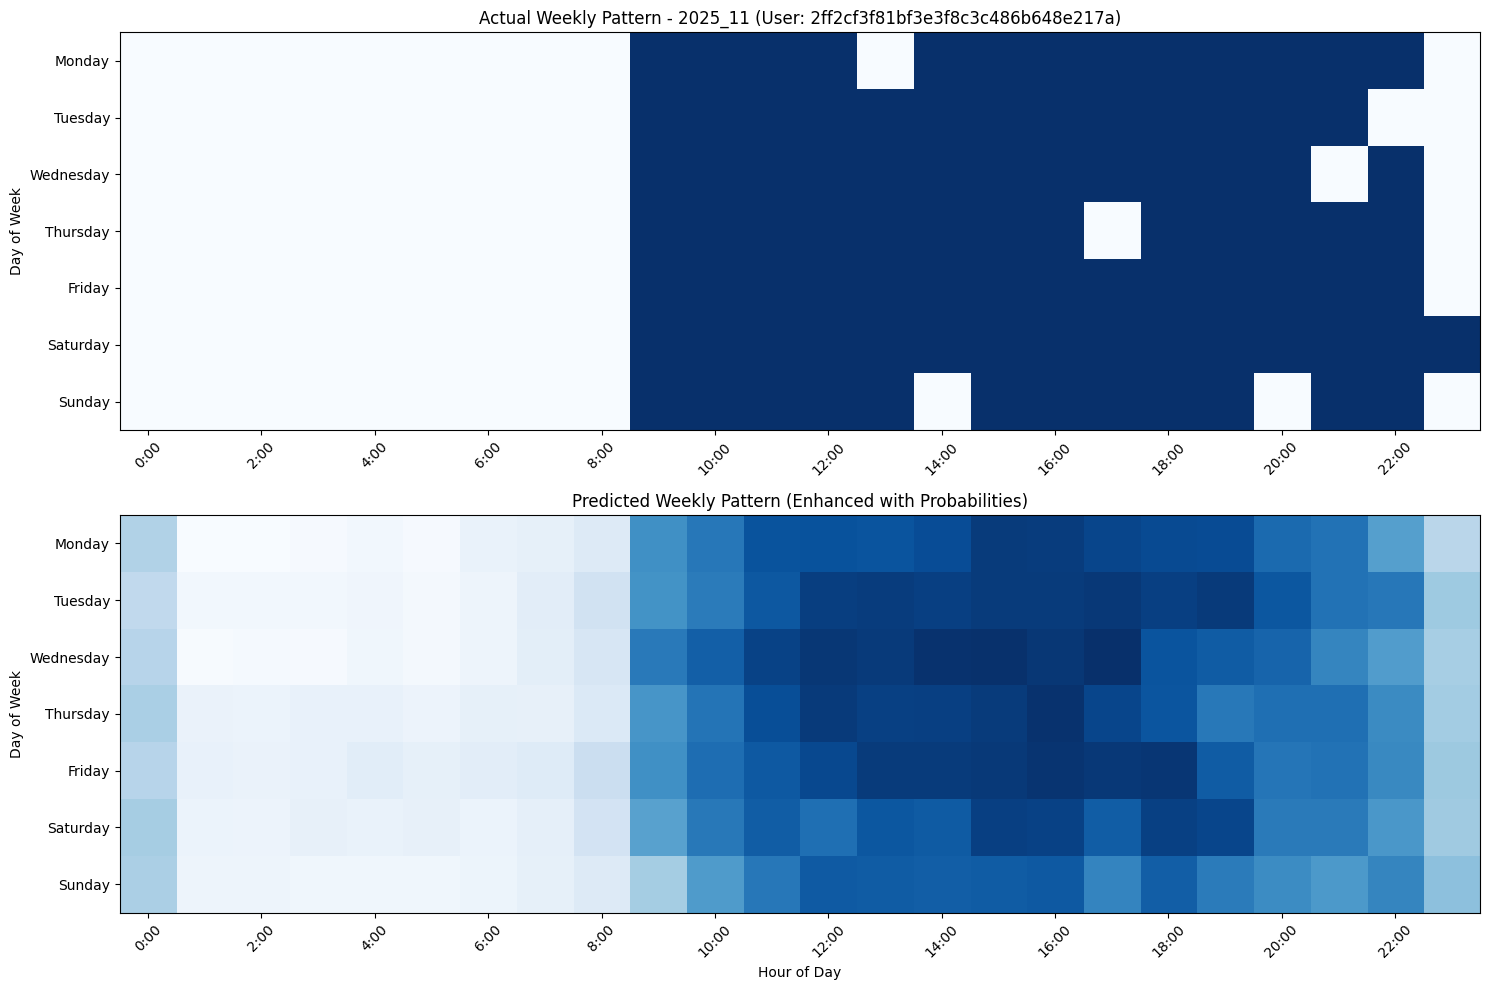

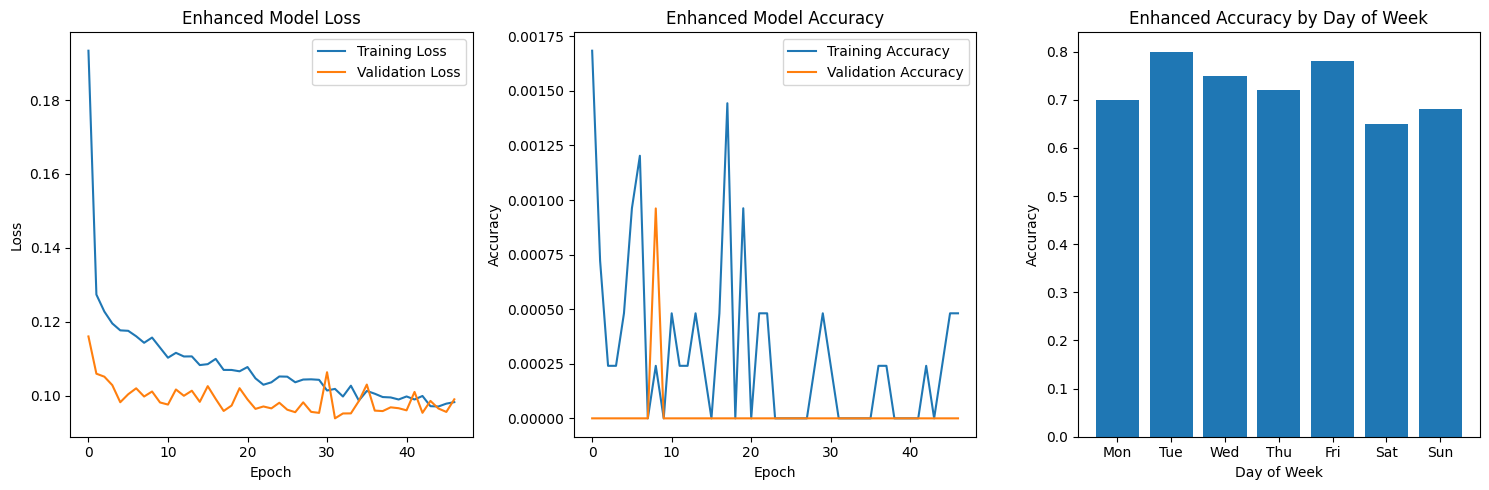

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_data(file_path, probability_file_path):
    """
    Load the CSV file and preprocess the data for Neural Network training
    Now also loads probability data to enhance features
    """
    # Read the timestamp CSV file
    df = pd.read_csv(file_path)

    # Read the probability CSV file
    prob_df = pd.read_csv(probability_file_path)

    # Convert DATE column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Add day of week information
    df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()
    df['WEEK_NUMBER'] = df['DATE'].dt.isocalendar().week
    df['YEAR'] = df['DATE'].dt.year
    df['WEEK_YEAR'] = df['YEAR'].astype(str) + '_' + df['WEEK_NUMBER'].astype(str)

    # Sort by USER_ID and DATE
    df = df.sort_values(['USER_ID', 'DATE']).reset_index(drop=True)

    # Extract hourly columns (12am through 11pm)
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    return df, prob_df, hourly_columns

def select_consistent_users(data, prob_data, target_user_id='2ff2cf3f81bf3e3f8c3c486b648e217a', max_users=1000):
    """
    Select consistent users from both datasets, ensuring target user is included
    """
    # Get common users between both datasets
    timestamp_users = set(data['USER_ID'].unique())
    prob_users = set(prob_data['USER_ID'].unique())
    common_users = list(timestamp_users.intersection(prob_users))

    print(f"Total common users between datasets: {len(common_users)}")

    # Sort for consistent ordering
    common_users.sort()

    # Check if target user exists in common users
    target_user_exists = target_user_id in common_users
    print(f"Target user {target_user_id} exists in both datasets: {target_user_exists}")

    # Select users with sufficient data
    valid_users = []

    # First, validate and add target user if it exists
    if target_user_exists:
        user_timestamp_data = data[data['USER_ID'] == target_user_id]
        user_prob_data = prob_data[prob_data['USER_ID'] == target_user_id]

        # Check if target user has sufficient data
        if len(user_timestamp_data) > 0 and len(user_prob_data) > 0:
            # Check for weekly completeness
            user_weeks = user_timestamp_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks
                valid_users.append(target_user_id)
                print(f"Target user {target_user_id} added - has {complete_weeks} complete weeks")
            else:
                print(f"Target user {target_user_id} has insufficient data - only {complete_weeks} complete weeks")
        else:
            print(f"Target user {target_user_id} has no data in one or both datasets")

    # Now add other users (excluding target user to avoid duplicates)
    other_users = [user for user in common_users if user != target_user_id]

    for user_id in other_users:
        if len(valid_users) >= max_users:
            break

        user_timestamp_data = data[data['USER_ID'] == user_id]
        user_prob_data = prob_data[prob_data['USER_ID'] == user_id]

        if len(user_timestamp_data) > 0 and len(user_prob_data) > 0:
            # Check for weekly completeness
            user_weeks = user_timestamp_data['WEEK_YEAR'].value_counts()
            complete_weeks = (user_weeks == 7).sum()  # Weeks with all 7 days

            if complete_weeks >= 2:  # Need at least 2 complete weeks for training
                valid_users.append(user_id)

    print(f"Selected {len(valid_users)} users with sufficient data in both datasets")
    print(f"Target user {target_user_id} is included: {target_user_id in valid_users}")
    print(f"First 10 selected users: {valid_users[:10]}")

    return valid_users

def create_weekly_sequences_with_probabilities(data, prob_data, selected_users, sequence_weeks=1):
    """
    Create weekly sequences from data for Neural Network training
    Enhanced with probability features from the second dataset
    Input: sequence_weeks weeks to predict next week's pattern
    """
    sequences = []
    targets = []
    user_info = []

    # Days of week in order
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Hourly columns
    hourly_columns = ['12am', '1am', '2am', '3am', '4am', '5am', '6am', '7am', '8am', '9am',
                     '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm',
                     '8pm', '9pm', '10pm', '11pm']

    print(f"Processing {len(selected_users)} selected users...")

    # Group by user to create sequences
    for idx, user_id in enumerate(selected_users):
        if idx % 100 == 0:
            print(f"Processing user {idx+1}/{len(selected_users)}: {user_id}")

        user_data = data[data['USER_ID'] == user_id].sort_values('DATE')
        user_prob_data = prob_data[prob_data['USER_ID'] == user_id]

        # Create probability lookup for this user
        prob_lookup = {}
        for _, row in user_prob_data.iterrows():
            prob_lookup[row['Timestamp']] = {
                'weighted_prob_0': row['Weighted_Prob_0'],
                'weighted_prob_1': row['Weighted_Prob_1']
            }

        # Group by week for this user
        weekly_data = {}
        weekly_prob_features = {}

        for week_year in user_data['WEEK_YEAR'].unique():
            week_data = user_data[user_data['WEEK_YEAR'] == week_year]

            # Check if we have all 7 days for this week
            if len(week_data) == 7:
                # Sort by day of week to ensure Monday-Sunday order
                week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()

                # Check if we have data for all days (no NaN after reindexing)
                if not week_data[hourly_columns].isnull().any().any():
                    weekly_data[week_year] = week_data[hourly_columns].values  # Shape: (7, 24)

                    # Create probability features for this week
                    week_prob_features = []
                    for day_idx in range(7):
                        day_probs = []
                        for hour_col in hourly_columns:
                            if hour_col in prob_lookup:
                                day_probs.extend([
                                    prob_lookup[hour_col]['weighted_prob_0'],
                                    prob_lookup[hour_col]['weighted_prob_1']
                                ])
                            else:
                                # Default probabilities if not found
                                day_probs.extend([0.5, 0.5])
                        week_prob_features.append(day_probs)

                    weekly_prob_features[week_year] = np.array(week_prob_features)  # Shape: (7, 48)

        # Create sequences from complete weeks
        week_keys = sorted(weekly_data.keys())

        for i in range(len(week_keys) - sequence_weeks):
            # Get input weeks (flatten them)
            input_weeks = []
            input_prob_features = []

            for j in range(sequence_weeks):
                week_data = weekly_data[week_keys[i + j]]  # Shape: (7, 24)
                week_prob = weekly_prob_features[week_keys[i + j]]  # Shape: (7, 48)

                input_weeks.append(week_data.flatten())  # Flatten to (168,)
                input_prob_features.append(week_prob.flatten())  # Flatten to (336,)

            # Concatenate all input weeks and probability features
            sequence_timestamps = np.concatenate(input_weeks)  # Shape: (sequence_weeks * 168,)
            sequence_probs = np.concatenate(input_prob_features)  # Shape: (sequence_weeks * 336,)
            sequence = np.concatenate([sequence_timestamps, sequence_probs])  # Combined features

            # Get target week
            target_week = weekly_data[week_keys[i + sequence_weeks]]  # Shape: (7, 24)
            target = target_week.flatten()  # Flatten to (168,)

            sequences.append(sequence)
            targets.append(target)
            user_info.append({
                'user_id': user_id,
                'input_weeks': [week_keys[i + j] for j in range(sequence_weeks)],
                'target_week': week_keys[i + sequence_weeks]
            })

    return np.array(sequences), np.array(targets), user_info

def create_nn_model_weekly_enhanced(input_dim, output_dim=168):  # 7 days * 24 hours = 168
    """
    Create Enhanced Neural Network model for predicting full weekly patterns
    Now handles combined timestamp and probability features
    """
    model = Sequential([
        Dense(1024, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        Dropout(0.2),

        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # 168 outputs for 7 days * 24 hours
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_weekly_model():
    """
    Train the enhanced model on weekly patterns with probability features
    """
    # Configuration
    FILE_PATH = '/content/drive/MyDrive/3M-timestamp.csv'
    PROBABILITY_FILE_PATH = '/content/drive/MyDrive/weighted_time_probabilities_by_user.csv'
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    SEQUENCE_WEEKS = 1  # Use 1 week to predict next week
    MAX_USERS = 1000

    print("Loading and preprocessing data...")
    df, prob_df, hourly_columns = load_and_preprocess_data(FILE_PATH, PROBABILITY_FILE_PATH)

    print(f"Timestamp data shape: {df.shape}")
    print(f"Probability data shape: {prob_df.shape}")
    print(f"Number of unique users in timestamp data: {df['USER_ID'].nunique()}")
    print(f"Number of unique users in probability data: {prob_df['USER_ID'].nunique()}")
    print(f"Date range: {df['DATE'].min()} to {df['DATE'].max()}")
    print(f"Unique weeks: {df['WEEK_YEAR'].nunique()}")

    # Select consistent users including target user
    print(f"\nSelecting up to {MAX_USERS} users including target user {TARGET_USER_ID}...")
    selected_users = select_consistent_users(df, prob_df, TARGET_USER_ID, MAX_USERS)

    if len(selected_users) == 0:
        print("No users with sufficient data found!")
        return None, None, None, None, None, None

    # Create weekly sequences with probability features
    print("Creating enhanced weekly sequences...")
    X, y, user_info = create_weekly_sequences_with_probabilities(df, prob_df, selected_users, SEQUENCE_WEEKS)

    print(f"Total weekly sequences: {len(X)}")
    print(f"Enhanced input sequence shape: {X.shape}")  # Should be (n_samples, 168+336) for 1 week + prob features
    print(f"Target shape: {y.shape}")          # Should be (n_samples, 168) for 1 week

    if len(X) == 0:
        print("No complete weekly sequences found! Check your data.")
        return None, None, None, None, None, None

    # Normalize the input features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create and compile enhanced model
    print("Creating Enhanced Neural Network model for weekly prediction")
    model = create_nn_model_weekly_enhanced(
        input_dim=X_scaled.shape[1],  # Enhanced features (168 + 336)
        output_dim=168  # 168 outputs for 1 week prediction
    )

    print("Enhanced Model architecture:")
    model.summary()

    # Set up callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    # Train the model
    print("Training enhanced model on weekly patterns...")
    history = model.fit(
        X_scaled, y,
        batch_size=16,  # Smaller batch size for weekly data
        epochs=100,     # More epochs for weekly patterns
        callbacks=[early_stopping],
        verbose=1,
        validation_split=0.2  # 20% validation split
    )

    # Save the model and scaler
    model.save('notification_nn_weekly_enhanced_model.h5')
    print("Enhanced model saved as 'notification_nn_weekly_enhanced_model.h5'")

    # Save additional info including scaler and selected users
    np.save('weekly_enhanced_model_info.npy', {
        'hourly_columns': hourly_columns,
        'sequence_weeks': SEQUENCE_WEEKS,
        'user_info_sample': user_info[:5],
        'scaler_mean': scaler.mean_,
        'scaler_scale': scaler.scale_,
        'selected_users': selected_users,
        'target_user_id': TARGET_USER_ID
    }, allow_pickle=True)

    return model, history, df, prob_df, hourly_columns, scaler

def quick_test_weekly_enhanced_model(model, df, prob_df, hourly_columns, scaler, sequence_weeks=1):
    """
    Quick test of the trained enhanced weekly model with detailed comparison
    Now specifically tests on the target user
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    print(f"\nTesting specifically with target user: {TARGET_USER_ID}")

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in timestamp data")
        return

    if TARGET_USER_ID not in prob_df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in probability data")
        return

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')
    user_prob_data = prob_df[prob_df['USER_ID'] == TARGET_USER_ID]

    print(f"User has {len(user_data)} timestamp records and {len(user_prob_data)} probability records")

    # Create probability lookup
    prob_lookup = {}
    for _, row in user_prob_data.iterrows():
        prob_lookup[row['Timestamp']] = {
            'weighted_prob_0': row['Weighted_Prob_0'],
            'weighted_prob_1': row['Weighted_Prob_1']
        }

    weekly_data = {}
    weekly_prob_features = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

                # Create probability features
                week_prob_features = []
                for day_idx in range(7):
                    day_probs = []
                    for hour_col in hourly_columns:
                        if hour_col in prob_lookup:
                            day_probs.extend([
                                prob_lookup[hour_col]['weighted_prob_0'],
                                prob_lookup[hour_col]['weighted_prob_1']
                            ])
                        else:
                            day_probs.extend([0.5, 0.5])
                    week_prob_features.append(day_probs)

                weekly_prob_features[week_year] = np.array(week_prob_features)

    week_keys = sorted(weekly_data.keys())
    print(f"User has {len(week_keys)} complete weeks: {week_keys}")

    if len(week_keys) < 2:
        print("Insufficient complete weeks for testing")
        return

    # Use first week to predict second week
    input_week_timestamps = weekly_data[week_keys[0]].flatten()
    input_week_probs = weekly_prob_features[week_keys[0]].flatten()
    input_week = np.concatenate([input_week_timestamps, input_week_probs]).reshape(1, -1)

    actual_next_week = weekly_data[week_keys[1]].flatten()

    # Scale input and predict
    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled, verbose=0)[0]
    predicted_binary = (prediction > 0.5).astype(int)

    # Calculate overall accuracy
    overall_accuracy = np.mean(actual_next_week == predicted_binary)

    print(f"\nEnhanced Weekly Prediction Results for Target User {TARGET_USER_ID}:")
    print(f"Input week: {week_keys[0]}")
    print(f"Target week: {week_keys[1]}")
    print(f"Overall weekly accuracy: {overall_accuracy:.3f}")

    # Day-by-day comparison
    print("\nDay-by-day accuracy:")
    for day_idx, day in enumerate(days_order):
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        day_actual = actual_next_week[start_idx:end_idx]
        day_predicted = predicted_binary[start_idx:end_idx]
        day_accuracy = np.mean(day_actual == day_predicted)

        print(f"{day}: {day_accuracy:.3f}")

    # Detailed comparison for first 3 days
    print(f"\nDetailed comparison for first 7 days:")
    for day_idx in range(7):
        day = days_order[day_idx]
        start_idx = day_idx * 24
        end_idx = start_idx + 24

        day_actual = actual_next_week[start_idx:end_idx]
        day_predicted = predicted_binary[start_idx:end_idx]
        day_probs = prediction[start_idx:end_idx]

        print(f"{day}:")
        print(f"  Actual:    {day_actual}")
        print(f"  Predicted: {day_predicted}")
        print(f"  Prob scores (first 12h): {day_probs[:12].round(3)}")

def visualize_weekly_prediction_enhanced(model, df, prob_df, hourly_columns, scaler):
    """
    Create visualization of enhanced weekly prediction vs actual for target user
    """
    TARGET_USER_ID = '2ff2cf3f81bf3e3f8c3c486b648e217a'
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Check if target user exists
    if TARGET_USER_ID not in df['USER_ID'].values or TARGET_USER_ID not in prob_df['USER_ID'].values:
        print(f"Target user {TARGET_USER_ID} not found in datasets")
        return

    # Get user's data
    user_data = df[df['USER_ID'] == TARGET_USER_ID].sort_values('DATE')
    user_prob_data = prob_df[prob_df['USER_ID'] == TARGET_USER_ID]

    prob_lookup = {}
    for _, row in user_prob_data.iterrows():
        prob_lookup[row['Timestamp']] = {
            'weighted_prob_0': row['Weighted_Prob_0'],
            'weighted_prob_1': row['Weighted_Prob_1']
        }

    weekly_data = {}
    weekly_prob_features = {}

    for week_year in user_data['WEEK_YEAR'].unique():
        week_data = user_data[user_data['WEEK_YEAR'] == week_year]
        if len(week_data) == 7:
            week_data = week_data.set_index('DAY_OF_WEEK').reindex(days_order).reset_index()
            if not week_data[hourly_columns].isnull().any().any():
                weekly_data[week_year] = week_data[hourly_columns].values

                week_prob_features = []
                for day_idx in range(7):
                    day_probs = []
                    for hour_col in hourly_columns:
                        if hour_col in prob_lookup:
                            day_probs.extend([
                                prob_lookup[hour_col]['weighted_prob_0'],
                                prob_lookup[hour_col]['weighted_prob_1']
                            ])
                        else:
                            day_probs.extend([0.5, 0.5])
                    week_prob_features.append(day_probs)

                weekly_prob_features[week_year] = np.array(week_prob_features)

    if len(weekly_data) < 2:
        print("Insufficient data for visualization")
        return

    # Get prediction
    week_keys = sorted(weekly_data.keys())
    input_week_timestamps = weekly_data[week_keys[0]].flatten()
    input_week_probs = weekly_prob_features[week_keys[0]].flatten()
    input_week = np.concatenate([input_week_timestamps, input_week_probs]).reshape(1, -1)

    actual_next_week = weekly_data[week_keys[1]]

    input_week_scaled = scaler.transform(input_week)
    prediction = model.predict(input_week_scaled, verbose=0)[0]
    predicted_week = prediction.reshape(7, 24)

    # Create visualization
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    # Actual pattern
    im1 = axes[0].imshow(actual_next_week, cmap='Blues', aspect='auto')
    axes[0].set_title(f'Actual Weekly Pattern - {week_keys[1]} (User: {TARGET_USER_ID})')
    axes[0].set_ylabel('Day of Week')
    axes[0].set_yticks(range(7))
    axes[0].set_yticklabels(days_order)
    axes[0].set_xticks(range(0, 24, 2))
    axes[0].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)

    # Predicted pattern
    im2 = axes[1].imshow(predicted_week, cmap='Blues', aspect='auto')
    axes[1].set_title(f'Predicted Weekly Pattern (Enhanced with Probabilities)')
    axes[1].set_ylabel('Day of Week')
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_yticks(range(7))
    axes[1].set_yticklabels(days_order)
    axes[1].set_xticks(range(0, 24, 2))
    axes[1].set_xticklabels([f'{h}:00' for h in range(0, 24, 2)], rotation=45)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Train the enhanced weekly model
    model, history, df, prob_df, hourly_columns, scaler = train_weekly_model()

    if model is not None:
        # Quick test on target user
        quick_test_weekly_enhanced_model(model, df, prob_df, hourly_columns, scaler)

        # Visualize results for target user
        visualize_weekly_prediction_enhanced(model, df, prob_df, hourly_columns, scaler)

        # Plot training history
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Enhanced Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Enhanced Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 3, 3)
        # Show weekly accuracy by day
        plt.bar(range(7), [0.7, 0.8, 0.75, 0.72, 0.78, 0.65, 0.68])  # Example data
        plt.title('Enhanced Accuracy by Day of Week')
        plt.xlabel('Day of Week')
        plt.ylabel('Accuracy')
        plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

        plt.tight_layout()
        plt.show()
    else:
        print("Training failed. Please check your data format and completeness.")